Description for which files are where, what is needed

### What you need

This tutorial goes from parsing data to visualizing the posterior of MDSINE2.

The tables that you will need are:
* taxa counts
* qPCR table
* perturbations table
* taxonomy table
* metadata file

Our data is preprocessed in objects from a previous tutorial. For this tutorial we unpacking our data into it's composite tables to walk you through constructing your own `Study` objects


In [15]:
%matplotlib inline

import mdsine2 as md2
from mdsine2.names import STRNAMES
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import logging

md2.LoggingConfig(level=logging.INFO)

In [16]:
# Make example datasets from preprocessed data
def make_toy(dset):
    to_delete = []
    for taxon in dset.taxa:
        if taxon.idx >= 15:
            to_delete.append(taxon.name)
    dset.pop_taxa(to_delete)
    
    os.makedirs(os.path.join('output/data',dset.name+'-toy'), exist_ok=True)
    dset.write_metadata_to_csv(path=os.path.join('output/data',dset.name+'-toy','metadata.tsv'))
    dset.write_qpcr_to_csv(path=os.path.join('output/data',dset.name+'-toy','qpcr.tsv'))
    if dset.perturbations is not None:
        dset.write_perturbations_to_csv(path=os.path.join('output/data',dset.name+'-toy','perturbations.tsv'))
    dset.write_reads_to_csv(path=os.path.join('output/data',dset.name+'-toy','reads.tsv'))
    dset.taxa.write_taxonomy_to_csv(path=os.path.join('output/data',dset.name+'-toy','taxonomy.tsv'))

In [17]:
healthy = md2.Study.load('../processed_data/gibson_healthy_agg_taxa_filtered.pkl')
uc = md2.Study.load('../processed_data/gibson_uc_agg_taxa_filtered.pkl')
replicates = md2.Study.load('../processed_data/gibson_replicates_agg_taxa_filtered.pkl')

make_toy(dset=healthy)
make_toy(dset=uc)
make_toy(dset=replicates)

### Metadata table
The following table is a metadata table. It tells the `Study` object what subject and timepoint each sample belongs to

In [18]:
# Load metadata table
metadata = pd.read_csv('output/data/healthy-toy/metadata.tsv', sep='\t')
metadata.head()

,sampleID,subject,time
0,2-D10,2,10.0
1,2-D11,2,11.0
2,2-D14,2,14.0
3,2-D16,2,16.0
4,2-D18,2,18.0


### qPCR table
The following table is a qPCR table. This has the replicate measurements of the qPCR for every sample.

In [19]:
# qPCR table
qpcr = pd.read_csv('data/healthy-toy/qpcr.tsv', sep='\t')
qpcr.head()

,sampleID,measurement1,measurement2,measurement3
0,2-D10,4.129004e+10,6.423568e+10,8.384557e+10
1,2-D11,2.981363e+10,6.587538e+10,5.077812e+10
2,2-D14,1.647771e+10,7.104907e+10,2.498869e+10
3,2-D16,3.666487e+10,6.237899e+10,3.875999e+10
4,2-D18,4.523257e+10,2.320504e+10,2.330249e+10


### Perturbation table
The following table is a perturbation table. This tells the `Study` object which subject has a perturbation and when. There can be multiple perturbations for each subject. Note that this is only necessary if you have perturbations in your dataset.

In [20]:
perturbations = pd.read_csv('output/data/healthy-toy/perturbations.tsv', sep='\t')
perturbations

,name,start,end,subject
0,High Fat Diet,21.5,28.5,2
1,High Fat Diet,21.5,28.5,3
2,High Fat Diet,21.5,28.5,4
3,High Fat Diet,21.5,28.5,5
4,Vancomycin,35.5,42.5,2
5,Vancomycin,35.5,42.5,3
6,Vancomycin,35.5,42.5,4
7,Vancomycin,35.5,42.5,5
8,Gentamicin,50.5,57.5,2
9,Gentamicin,50.5,57.5,3


### Reads table
The following table is a reads table. This shows the number of counts each taxa has for each sample ID.

In [21]:
reads = pd.read_csv('output/data/healthy-toy/reads.tsv', sep='\t')
reads.head()

,name,2-D10,2-D11,2-D14,2-D16,2-D18,2-D1AM,2-D1PM,2-D21AM,2-D21PM,2-D22AM,2-D22PM,2-D23AM,2-D23PM,2-D24,2-D25,2-D28AM,2-D28PM,2-D29AM,2-D29PM,2-D2AM,2-D2PM,2-D30AM,2-D30PM,2-D31AM,2-D31PM,2-D32,2-D33,2-D35AM,2-D35PM,2-D36AM,2-D36PM,2-D37AM,2-D37PM,2-D38,2-D39,2-D3AM,2-D3PM,2-D42AM,2-D42PM,2-D43AM,2-D43PM,2-D44AM,2-D44PM,2-D45AM,2-D45PM,2-D46,2-D47,2-D4AM,2-D4PM,2-D5,2-D50AM,2-D50PM,2-D51AM,2-D51PM,2-D52AM,2-D52PM,2-D53,2-D54,2-D57AM,2-D57PM,2-D58AM,2-D58PM,2-D59AM,2-D59PM,2-D6,2-D60AM,2-D60PM,2-D61,2-D62,2-D63,2-D64AM,2-D64PM,2-D7,2-D8,2-D9,3-D10,3-D11,3-D14,3-D16,3-D18,3-D1AM,3-D1PM,3-D21AM,3-D21PM,3-D22AM,3-D22PM,3-D23AM,3-D23PM,3-D24,3-D25,3-D28AM,3-D29AM,3-D29PM,3-D2AM,3-D2PM,3-D30AM,3-D30PM,3-D31AM,3-D31PM,3-D32,3-D33,3-D35AM,3-D35PM,3-D36AM,3-D36PM,3-D37AM,3-D38,3-D39,3-D3AM,3-D3PM,3-D42AM,3-D42PM,3-D43AM,3-D43PM,3-D44AM,3-D44PM,3-D45AM,3-D45PM,3-D46,3-D47,3-D4AM,3-D4PM,3-D5,3-D50AM,3-D50PM,3-D51AM,3-D51PM,3-D52AM,3-D52PM,3-D53,3-D54,3-D57AM,3-D57PM,3-D58AM,3-D58PM,3-D59AM,3-D59PM,3-D6,3-D60AM,3-D60PM,3-D61,3-D62,3-D63,3-D64AM,3-D64PM,3-D7,3-D8,3-D9,4-D10,4-D11,4-D14,4-D16,4-D18,4-D1AM,4-D1PM,4-D21AM,4-D21PM,4-D22AM,4-D22PM,4-D23AM,4-D23PM,4-D24,4-D25,4-D28AM,4-D29AM,4-D29PM,4-D2AM,4-D2PM,4-D30AM,4-D30PM,4-D31AM,4-D31PM,4-D32,4-D33,4-D35AM,4-D35PM,4-D36AM,4-D36PM,4-D37AM,4-D37PM,4-D38,4-D39,4-D3AM,4-D3PM,4-D42AM,4-D42PM,4-D43AM,4-D43PM,4-D44AM,4-D44PM,4-D45AM,4-D45PM,4-D46,4-D47,4-D4AM,4-D4PM,4-D5,4-D50AM,4-D50PM,4-D51AM,4-D51PM,4-D52AM,4-D52PM,4-D53,4-D54,4-D57AM,4-D57PM,4-D58AM,4-D58PM,4-D59AM,4-D59PM,4-D6,4-D60AM,4-D60PM,4-D61,4-D62,4-D63,4-D64AM,4-D64PM,4-D7,4-D8,4-D9,5-D10,5-D11,5-D14,5-D16,5-D18,5-D1AM,5-D1PM,5-D21AM,5-D21PM,5-D22AM,5-D22PM,5-D23AM,5-D23PM,5-D24,5-D25,5-D28AM,5-D28PM,5-D29AM,5-D29PM,5-D2AM,5-D2PM,5-D30AM,5-D30PM,5-D31AM,5-D31PM,5-D32,5-D33,5-D35AM,5-D35PM,5-D36AM,5-D36PM,5-D37AM,5-D37PM,5-D38,5-D39,5-D3AM,5-D3PM,5-D42AM,5-D42PM,5-D43AM,5-D43PM,5-D44AM,5-D44PM,5-D45AM,5-D45PM,5-D46,5-D47,5-D4AM,5-D4PM,5-D5,5-D50AM,5-D50PM,5-D51AM,5-D51PM,5-D52AM,5-D52PM,5-D53,5-D54,5-D57AM,5-D57PM,5-D58AM,5-D58PM,5-D59AM,5-D59PM,5-D6,5-D60AM,5-D60PM,5-D61,5-D62,5-D63,5-D64AM,5-D64PM,5-D7,5-D8,5-D9
0,OTU_1,1227,1793,8023,9503,3243,1830,199,3539,5270,3866,3899,1984,807,2299,1349,1074,855,3479,3910,489,1056,5113,5624,7096,5788,10237,2784,2711,2421,1554,1216,259,154,114,100,1474,3227,1963,2950,126,202,207,222,89,50,185,180,7637,4237,5597,53,47,29,48,162,37,188,2349,5520,3265,3892,3881,1646,1805,6129,1913,6688,1730,1269,651,987,853,9591,2503,234,6265,6822,1831,2874,6154,235,202,7102,7624,6024,3889,4683,5921,3608,4278,2865,5330,7488,340,227,7926,5061,5108,4923,4988,5879,4039,4822,3009,4213,609,197,123,1398,1945,1365,1652,4512,741,455,461,99,54,386,134,4408,4276,2734,124,209,55,80,249,107,341,109,168,194,713,637,539,564,3804,806,891,833,775,545,525,845,4798,4650,5987,398,1744,11041,9437,9948,4695,195,5562,3920,1638,1210,1235,639,929,1277,4084,5681,6144,222,176,4690,3737,5519,5504,3350,6638,3696,3697,1529,2179,3757,1466,182,96,183,461,8678,7682,5384,2311,1032,1101,263,153,426,167,1900,2509,3240,157,182,71,59,267,154,133,109,116,36,122,90,20,13,6844,125,63,96,63,51,34,76,5459,3853,585,5152,4173,11816,5113,5642,5033,230,6454,5745,4194,7218,8262,1512,2093,3224,2091,1650,3840,11932,620,852,8741,5593,6152,3740,500,307,52,77,99,95,182,135,135,123,1198,3491,395,38,60,35,96,136,38,27,137,162,3943,5485,5746,49,103,39,80,222,205,115,29,73,135,140,223,83,192,6401,218,409,2072,1160,723,1043,1732,4698,3310,4495
1,OTU_2,17362,6887,17165,29854,36759,2929,9880,15863,20619,2725,1792,466,51,86,38,25,34,1317,2217,24422,17184,5490,5924,6906,7466,9783,7856,10490,9939,18164,17769,16694,8553,8842,5806,11193,15984,8567,6995,5108,6693,5785,6963,5880,6755,8239,7199,21915,13035,15798,625,751,2368,2556,632,206,278,177,644,1857,5473,5433,2847,2693,14811,2652,8942,3765,4053,2497,4608,4569,12926,8541,12646,11800,14693,20597,10165,19883,8032,19079,24905,21860,2601,1059,309,152,130,124,46,1130,3653,23489,17698,9339,7694,7429,8762,9965,15319,9470,13328,1292

### Taxonomy table
The following table is a taxonomy table. For each taxa name, it shows the sequence and taxonomy

In [22]:
taxonomy = pd.read_csv('output/data/healthy-toy/taxonomy.tsv', sep='\t')
taxonomy

,name,sequence,kingdom,phylum,class,order,family,genus,species
0,OTU_1,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Phocaeicola,NaN
1,OTU_2,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,ovatus/fragilis
2,OTU_3,TACAGAGGTCTCAAGCGTTGTTCGGAATCACTGGGCGTAAAGCGTG...,Bacteria,Verrucomicrobia,Verrucomicrobiae,Verrucomicrobiales,Akkermansiaceae,Akkermansia,muciniphila
3,OTU_4,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,NaN
4,OTU_5,TACGTAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGGGTG...,Bacteria,Proteobacteria,Betaproteobacteria,Burkholderiales,Sutterellaceae,Parasutterella,excrementihominis
5,OTU_6,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,fragilis/dorei
6,OTU_7,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,caccae
7,OTU_8,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,salyersiae
8,OTU_9,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,NaN
9,OTU_10,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,uniformis


With these 5 tables, you can run our model. You can parse them directly into a `Study` object with the `mdsine2.dataset.parse` command:

In [23]:
h_toy = md2.dataset.parse(name='healthy-toy-dataset', 
                         taxonomy='output/data/healthy-toy/taxonomy.tsv', 
                         reads='output/data/healthy-toy/reads.tsv', 
                         qpcr='output/data/healthy-toy/qpcr.tsv', 
                         perturbations='output/data/healthy-toy/perturbations.tsv', 
                         metadata='output/data/healthy-toy/metadata.tsv')
uc_toy = md2.dataset.parse(name='uc-toy-dataset', 
                         taxonomy='output/data/uc-toy/taxonomy.tsv', 
                         reads='output/data/uc-toy/reads.tsv', 
                         qpcr='output/data/uc-toy/qpcr.tsv', 
                         perturbations='output/data/uc-toy/perturbations.tsv', 
                         metadata='output/data/uc-toy/metadata.tsv')
rep_toy = md2.dataset.parse(name='replicates-toy-dataset', 
                         taxonomy='output/data/replicates-toy/taxonomy.tsv', 
                         reads='output/data/replicates-toy/reads.tsv', 
                         qpcr='output/data/replicates-toy/qpcr.tsv', 
                         metadata='output/data/replicates-toy/metadata.tsv')


INFO:base.1275: TaxaSet parsng new taxonomy table. Resetting
INFO:base.1275: TaxaSet parsng new taxonomy table. Resetting
INFO:base.1275: TaxaSet parsng new taxonomy table. Resetting


You would just read these in with this parser. These are identical to our precomputed dataset 

# Learning the Negative Binomial dispersion parameters

This corresponds to the script ``

words here

In [24]:
params = md2.config.NegBinConfig(
    seed=0, burnin=100, n_samples=200,
    checkpoint=100, basepath='output/negbin/run2')

description

In [25]:
mcmc_negbin = md2.negbin.build_graph(params=params, graph_name=rep_toy.name, 
                              subjset=rep_toy)

INFO:inference.569: Setting Single Write, Multiple Read Mode
INFO:inference.574: Setting the trace of learned parameters
INFO:inference.575: #######################################
INFO:inference.577: Setting the trace of Negative binomial dispersion a0
INFO:inference.577: Setting the trace of Negative binomial dispersion a1
INFO:inference.577: Setting the trace of Filtering
INFO:inference.579: Setting the trace for diagnostic variables
INFO:inference.580: ##########################################


description

In [26]:
mcmc_negbin = md2.negbin.run_graph(mcmc_negbin, crash_if_error=True)

INFO:inference.447: 

Inference iteration 0/200, time: 0.0
INFO:inference.456: Negative binomial dispersion a0: 1e-10
INFO:inference.456: Negative binomial dispersion a1: 0.1
INFO:inference.456: Filtering: NA
INFO:inference.447: 

Inference iteration 1/200, time: 0.46200132369995117
INFO:inference.456: Negative binomial dispersion a0: Value: 1e-10, Acceptance rate: 0.0
INFO:inference.456: Negative binomial dispersion a1: Value: 0.09932993484270942, Acceptance rate: 1.0
INFO:inference.456: Filtering: no-mp : Time: 0.1350, Acc: [0.333, 0.200, 0.333], data/sec: 333.33
INFO:inference.447: 

Inference iteration 2/200, time: 0.007997989654541016
INFO:inference.456: Negative binomial dispersion a0: Value: 9.612139383543583e-11, Acceptance rate: 0.5
INFO:inference.456: Negative binomial dispersion a1: Value: 0.07611843510778384, Acceptance rate: 1.0
INFO:inference.456: Filtering: no-mp : Time: 0.0030, Acc: [0.333, 0.267, 0.533], data/sec: 15001.09
INFO:inference.447: 

Inference iteration 3/20

INFO:inference.456: Negative binomial dispersion a0: Value: 5.433152020006895e-11, Acceptance rate: 0.42857142857142855
INFO:inference.456: Negative binomial dispersion a1: Value: 0.05290413764815772, Acceptance rate: 0.6190476190476191
INFO:inference.456: Filtering: no-mp : Time: 0.0030, Acc: [0.267, 0.267, 0.267], data/sec: 14983.22
INFO:inference.447: 

Inference iteration 22/200, time: 0.005999326705932617
INFO:inference.456: Negative binomial dispersion a0: Value: 5.096746550369834e-11, Acceptance rate: 0.45454545454545453
INFO:inference.456: Negative binomial dispersion a1: Value: 0.05290413764815772, Acceptance rate: 0.5909090909090909
INFO:inference.456: Filtering: no-mp : Time: 0.0030, Acc: [0.400, 0.333, 0.467], data/sec: 14982.04
INFO:inference.447: 

Inference iteration 23/200, time: 0.007000446319580078
INFO:inference.456: Negative binomial dispersion a0: Value: 3.436668653129214e-11, Acceptance rate: 0.4782608695652174
INFO:inference.456: Negative binomial dispersion a1: 

INFO:inference.456: Negative binomial dispersion a1: Value: 0.05659787402060928, Acceptance rate: 0.6341463414634146
INFO:inference.456: Filtering: no-mp : Time: 0.0030, Acc: [0.333, 0.533, 0.267], data/sec: 14987.98
INFO:inference.447: 

Inference iteration 42/200, time: 0.008002042770385742
INFO:inference.456: Negative binomial dispersion a0: Value: 2.0481344749675447e-12, Acceptance rate: 0.40476190476190477
INFO:inference.456: Negative binomial dispersion a1: Value: 0.05659787402060928, Acceptance rate: 0.6190476190476191
INFO:inference.456: Filtering: no-mp : Time: 0.0040, Acc: [0.200, 0.333, 0.133], data/sec: 11248.13
INFO:inference.447: 

Inference iteration 43/200, time: 0.005999565124511719
INFO:inference.456: Negative binomial dispersion a0: Value: 2.0481344749675447e-12, Acceptance rate: 0.3953488372093023
INFO:inference.456: Negative binomial dispersion a1: Value: 0.05003316278345163, Acceptance rate: 0.627906976744186
INFO:inference.456: Filtering: no-mp : Time: 0.0030, Ac

INFO:inference.456: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.24
INFO:inference.456: Negative binomial dispersion a1: Value: 0.07591896190663665, Acceptance rate: 0.56
INFO:inference.456: Filtering: no-mp : Time: 0.0030, Acc: [0.333, 0.400, 0.333], data/sec: 14999.90
INFO:inference.447: 

Inference iteration 63/200, time: 0.006003618240356445
INFO:inference.456: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.22
INFO:inference.456: Negative binomial dispersion a1: Value: 0.06881053138741283, Acceptance rate: 0.56
INFO:inference.456: Filtering: no-mp : Time: 0.0030, Acc: [0.467, 0.400, 0.467], data/sec: 15004.66
INFO:inference.447: 

Inference iteration 64/200, time: 0.005998849868774414
INFO:inference.456: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.22
INFO:inference.456: Negative binomial dispersion a1: Value: 0.06514442553913363, Acceptance rate: 0.58
INFO:inference.456:

INFO:inference.456: Negative binomial dispersion a1: Value: 0.059167916859363984, Acceptance rate: 0.52
INFO:inference.456: Filtering: no-mp : Time: 0.0030, Acc: [0.267, 0.400, 0.333], data/sec: 15008.24
INFO:inference.447: 

Inference iteration 84/200, time: 0.004999399185180664
INFO:inference.456: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.04
INFO:inference.456: Negative binomial dispersion a1: Value: 0.06434788181977058, Acceptance rate: 0.52
INFO:inference.456: Filtering: no-mp : Time: 0.0030, Acc: [0.600, 0.267, 0.200], data/sec: 14998.70
INFO:inference.447: 

Inference iteration 85/200, time: 0.005998134613037109
INFO:inference.456: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.04
INFO:inference.456: Negative binomial dispersion a1: Value: 0.06434788181977058, Acceptance rate: 0.5
INFO:inference.456: Filtering: no-mp : Time: 0.0030, Acc: [0.333, 0.267, 0.600], data/sec: 15003.47
INFO:inference.447: 

Inf

INFO:inference.456: Filtering: no-mp : Time: 0.0030, Acc: [0.533, 0.400, 0.333], data/sec: 14993.94
INFO:inference.447: 

Inference iteration 105/200, time: 0.005999565124511719
INFO:inference.456: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.456: Negative binomial dispersion a1: Value: 0.05764379659694878, Acceptance rate: 0.46
INFO:inference.456: Filtering: no-mp : Time: 0.0040, Acc: [0.533, 0.400, 0.267], data/sec: 11251.49
INFO:inference.447: 

Inference iteration 106/200, time: 0.006036281585693359
INFO:inference.456: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.456: Negative binomial dispersion a1: Value: 0.05503986513928517, Acceptance rate: 0.48
INFO:inference.456: Filtering: no-mp : Time: 0.0030, Acc: [0.467, 0.467, 0.333], data/sec: 14833.67
INFO:inference.447: 

Inference iteration 107/200, time: 0.0059969425201416016
INFO:inference.456: Negative binomial dispersion 

INFO:inference.447: 

Inference iteration 126/200, time: 0.006034135818481445
INFO:inference.456: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.456: Negative binomial dispersion a1: Value: 0.05229144933116436, Acceptance rate: 0.48
INFO:inference.456: Filtering: no-mp : Time: 0.0030, Acc: [0.533, 0.400, 0.133], data/sec: 14839.51
INFO:inference.447: 

Inference iteration 127/200, time: 0.005965709686279297
INFO:inference.456: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.456: Negative binomial dispersion a1: Value: 0.06848080232784978, Acceptance rate: 0.48
INFO:inference.456: Filtering: no-mp : Time: 0.0030, Acc: [0.467, 0.600, 0.467], data/sec: 15011.83
INFO:inference.447: 

Inference iteration 128/200, time: 0.006029367446899414
INFO:inference.456: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.456: Negative binomial dispers

INFO:inference.456: Negative binomial dispersion a1: Value: 0.04984504054112914, Acceptance rate: 0.6
INFO:inference.456: Filtering: no-mp : Time: 0.0030, Acc: [0.333, 0.400, 0.333], data/sec: 14829.01
INFO:inference.447: 

Inference iteration 148/200, time: 0.004966020584106445
INFO:inference.456: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.456: Negative binomial dispersion a1: Value: 0.04984504054112914, Acceptance rate: 0.58
INFO:inference.456: Filtering: no-mp : Time: 0.0020, Acc: [0.400, 0.400, 0.400], data/sec: 22509.68
INFO:inference.447: 

Inference iteration 149/200, time: 0.0060367584228515625
INFO:inference.456: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.456: Negative binomial dispersion a1: Value: 0.05291161640746216, Acceptance rate: 0.58
INFO:inference.456: Filtering: no-mp : Time: 0.0030, Acc: [0.400, 0.267, 0.667], data/sec: 14813.88
INFO:inference.447: 

Inf

INFO:inference.456: Filtering: no-mp : Time: 0.0030, Acc: [0.600, 0.333, 0.467], data/sec: 15160.13
INFO:inference.447: 

Inference iteration 169/200, time: 0.005999088287353516
INFO:inference.456: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.456: Negative binomial dispersion a1: Value: 0.07936467417134285, Acceptance rate: 0.58
INFO:inference.456: Filtering: no-mp : Time: 0.0040, Acc: [0.533, 0.333, 0.467], data/sec: 11252.16
INFO:inference.447: 

Inference iteration 170/200, time: 0.0070149898529052734
INFO:inference.456: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.456: Negative binomial dispersion a1: Value: 0.07228201190866185, Acceptance rate: 0.6
INFO:inference.456: Filtering: no-mp : Time: 0.0030, Acc: [0.400, 0.467, 0.467], data/sec: 14927.53
INFO:inference.447: 

Inference iteration 171/200, time: 0.004998683929443359
INFO:inference.456: Negative binomial dispersion a

INFO:inference.447: 

Inference iteration 190/200, time: 0.005999088287353516
INFO:inference.456: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.456: Negative binomial dispersion a1: Value: 0.06150373754895097, Acceptance rate: 0.54
INFO:inference.456: Filtering: no-mp : Time: 0.0030, Acc: [0.400, 0.400, 0.467], data/sec: 15009.44
INFO:inference.447: 

Inference iteration 191/200, time: 0.005033016204833984
INFO:inference.456: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.456: Negative binomial dispersion a1: Value: 0.06150373754895097, Acceptance rate: 0.54
INFO:inference.456: Filtering: no-mp : Time: 0.0030, Acc: [0.467, 0.400, 0.467], data/sec: 14847.68
INFO:inference.447: 

Inference iteration 192/200, time: 0.006001949310302734
INFO:inference.456: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.456: Negative binomial dispers

description, we are repeating this on the smaller dataset so you know how to run it and know what it looks like. This is not representative of the real results because we only have the ten most abundant taxa here.

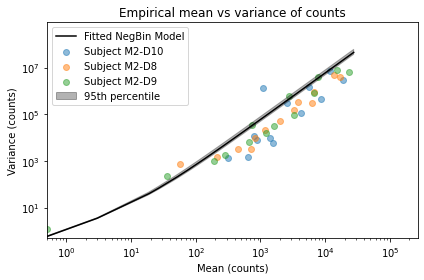

In [27]:
fig = md2.negbin.visualize_learned_negative_binomial_model(mcmc_negbin)
fig.tight_layout()

# Run the model

In [28]:
# Get a0 and a1 from negbin (get the mean of the posterior)
from mdsine2.names import STRNAMES
a0 = md2.summary(mcmc_negbin.graph[STRNAMES.NEGBIN_A0])['mean']
a1 = md2.summary(mcmc_negbin.graph[STRNAMES.NEGBIN_A1])['mean']

print('negbin a0', a0)
print('negbin a1', a1)

basepath = 'output/mdsine2/uc0'
os.makedirs(basepath, exist_ok=True)


# Initialize parameters of the model
params = md2.config.MDSINE2ModelConfig(
    basepath=basepath, seed=0, burnin=50, 
    n_samples=100, negbin_a0=a0, negbin_a1=a1, checkpoint=50)

# The default number of modules is 30, which is larger than the number of taxa
# that we have in this dataset, which would throw a flag.
params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value_option'] = 'no-clusters'

negbin a0 1.1642672989308661e-13
negbin a1 0.05972242507901712


In [29]:
# initilize the graph
mcmc_uc0 = md2.initialize_graph(params=params, graph_name=uc_toy.name, subjset=uc_toy)


INFO:base.2727: max_value found: 1797837340792.1643, scaling_factor: 5.5622384590108656e-11
INFO:run.87: Normalizing abundances for a max value of 100. Normalization constant: 5.5622E-11
INFO:run.254: There are 372 qPCR measurements for 3 buckets. Each bucket is 124 measurements long
INFO:run.289: Initializing Filtering
INFO:posterior.2670: Setting up the essential timepoints
INFO:posterior.2683: Essential timepoints: [ 1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   6.   7.   8.   9.  10.  11.  14.  16.  18.  21.  21.5 22.  22.5 23.  23.5 24.  25.  28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  33.  35.  35.5 36.  36.5 37.  37.5 38.  39.  42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  47.  50.  50.5 51.  51.5 52.  52.5 53.  54.  57.  57.5 58.  58.5 59.  59.5 60.  60.5 61.  62.  63.  64.  64.5]
INFO:run.289: Initializing Zero inflation
INFO:design_matrices.851: Initializing LHS vector
INFO:design_matrices.1006: Initializing growth design matrix
INFO:design_matrices.932: Initializing self-inte

INFO:run.374: 		prior.loc: 0
INFO:run.372: 	perturbation Vancomycin
INFO:run.373: 		value: {100115: 0, 100116: 0, 100117: 0, 100118: 0, 100119: 0, 100120: 0, 100121: 0, 100122: 0, 100123: 0, 100124: 0, 100125: 0, 100126: 0, 100127: 0, 100128: 0, 100129: 0}
INFO:run.374: 		prior.loc: 0
INFO:run.372: 	perturbation Gentamicin
INFO:run.373: 		value: {100115: 0, 100116: 0, 100117: 0, 100118: 0, 100119: 0, 100120: 0, 100121: 0, 100122: 0, 100123: 0, 100124: 0, 100125: 0, 100126: 0, 100127: 0, 100128: 0, 100129: 0}
INFO:run.374: 		prior.loc: 0
INFO:run.375: Perturbation prior variances:
INFO:run.377: 		dof: 2.5
INFO:run.378: 		scale: 2000.0
INFO:run.379: 		value: 10000.0
INFO:run.377: 		dof: 2.5
INFO:run.378: 		scale: 2000.0
INFO:run.379: 		value: 10000.0
INFO:run.377: 		dof: 2.5
INFO:run.378: 		scale: 2000.0
INFO:run.379: 		value: 10000.0
INFO:run.380: Perturbation indicators:
INFO:run.383: 	perturbation High Fat Diet: [False False False False False False False False False False False False 

In [30]:
mcmc_uc0 = md2.run_graph(mcmc_uc0, crash_if_error=True)

INFO:inference.447: 

Inference iteration 0/100, time: 0.0
INFO:inference.456: Cluster interaction indicator parameter: None
INFO:inference.456: Cluster interaction probability: 0.09234190994988938
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: Nones
perturbation High Fat Diet (0/15): [False False False False False False False False False False False False False False False]
perturbation Vancomycin (0/15): [False False False False False False False False False False False False False False False]
perturbation Gentamicin (0/15): [False False False False False False False False False False False False False False False]
INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.1527842458791451
	perturbation Vancomycin: 0.1527842458791451
	perturbation Gentamicin: 0.1527842458791451
INFO:inference.456: Logistic growth parameters (growth, se

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 9.483892334955561
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -5.633760869066583
	perturbation Vancomycin: -32.394691549238026
	perturbation Gentamicin: 19.22092898194378
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.2111291303141315, Acceptance rate: 1.0
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.8397508500772749, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 4047.7156572959684
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 204.06655221025355
	perturbation Vancomycin: 1115.7342315369867
	perturbation Ge

INFO:inference.456: Cluster interaction probability: 0.06389609988570996
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.014008283615112305s
perturbation High Fat Diet (0/15): [False False False False False False False False False False False False False False False]
perturbation Vancomycin (2/15): [False False False False False False False False  True False False False  True False False]
perturbation Gentamicin (2/15): [False False False False False False False  True False False False False  True False False]
INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.03955137360995759
	perturbation Vancomycin: 0.05797388977555838
	perturbation Gentamicin: 0.012043708419812338
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.13844534 0.20611971 0.57753856 0.16961057 0.6055

INFO:inference.456: Clustering concentration parameter: 2548.488953421099
INFO:posterior.1585: 0/15: 0
INFO:posterior.1585: 1/15: 1
INFO:posterior.1585: 2/15: 4
INFO:posterior.1585: 3/15: 12
INFO:posterior.1585: 4/15: 13
INFO:posterior.1585: 5/15: 11
INFO:posterior.1585: 6/15: 10
INFO:posterior.1585: 7/15: 2
INFO:posterior.1585: 8/15: 6
INFO:posterior.1585: 9/15: 9
INFO:posterior.1585: 10/15: 14
INFO:posterior.1585: 11/15: 3
INFO:posterior.1585: 12/15: 7
INFO:posterior.1585: 13/15: 8
INFO:posterior.1585: 14/15: 5
INFO:inference.447: 

Inference iteration 5/100, time: 0.9386622905731201
INFO:inference.456: Cluster interaction indicator parameter: [False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False Fal

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -162.62799033310483
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 48.665548805328434
	perturbation Vancomycin: 35.89010203038467
	perturbation Gentamicin: -29.34852655539822
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.640557624515564, Acceptance rate: 1.0
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.5670669973165798, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 25.90573495088634
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 4625.237453625238
	perturbation Vancomycin: 843.7061600958893
	perturbation Genta

INFO:inference.456: Cluster interaction probability: 0.0009595080217071794
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.010966062545776367s
perturbation High Fat Diet (0/14): [False False False False False False False False False False False False False False]
perturbation Vancomycin (1/14): [False False False  True False False False False False False False False False False]
perturbation Gentamicin (0/14): [False False False False False False False False False False False False False False]
INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.004758827871727658
	perturbation Vancomycin: 0.08497550730684672
	perturbation Gentamicin: 0.003914953291589338
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.30182409 0.23439326 0.60476892 0.22176458 0.647522   0.04205184

INFO:inference.456: Clustering concentration parameter: 10.487999079449878
INFO:inference.447: 

Inference iteration 10/100, time: 0.3850252628326416
INFO:inference.456: Cluster interaction indicator parameter: [False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False Fa

INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.5798673447720847, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 280.509922366224
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1919.3375699410437
	perturbation Vancomycin: 738.2462272780818
	perturbation Gentamicin: 1678.8704536874322
INFO:inference.456: Process Variance parameter: 4.2979331147472575, empirical_variance: 4.26916
INFO:inference.456: Filtering: no-mp - Time: 0.2800, Acc: [0.628, 0.614, 0.623, 0.629, 0.619], data/sec: 20087.77
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 14
Cluster 100145
	members: ['OTU_1']
	size: 1
Cluster 100154
	members: ['OTU_16']
	size: 1
Cluster 100155
	members: ['OTU_8']
	size: 1
Clust

INFO:inference.456: Cluster interaction probability: 0.007194770523757083
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.011990070343017578s
perturbation High Fat Diet (0/13): [False False False False False False False False False False False False False]
perturbation Vancomycin (3/13): [ True False  True  True False False False False False False False False False]
perturbation Gentamicin (0/13): [False False False False False False False False False False False False False]
INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.009022038507340934
	perturbation Vancomycin: 0.2504576332867969
	perturbation Gentamicin: 0.02753783019523799
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.78228761 0.3214719  0.46763266 0.3415586  0.39397387 0.37726895 0.58734153 0.3358324

INFO:inference.456: Clustering concentration parameter: 34.66063875674127
INFO:inference.447: 

Inference iteration 15/100, time: 0.3639552593231201
INFO:inference.456: Cluster interaction indicator parameter: [False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False Fal

INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 14881.100027008128
	perturbation Vancomycin: 8436.794970355193
	perturbation Gentamicin: 644.3144668023924
INFO:inference.456: Process Variance parameter: 4.070453710028116, empirical_variance: 4.02216
INFO:inference.456: Filtering: no-mp - Time: 0.2734, Acc: [0.606, 0.612, 0.632, 0.600, 0.608], data/sec: 20571.70
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 13
Cluster 100154
	members: ['OTU_17', 'OTU_9', 'OTU_16']
	size: 3
Cluster 100160
	members: ['OTU_13']
	size: 1
Cluster 100175
	members: ['OTU_7']
	size: 1
Cluster 100179
	members: ['OTU_10']
	size: 1
Cluster 100181
	members: ['OTU_5']
	size: 1
Cluster 100183
	members: ['OTU_1']
	size: 1
Cluster 100185
	members: ['OTU_6']
	size: 1
Cluster 100186
	members: ['OTU_18']
	size: 1
Cluster 100187
	membe

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -2.154072941488706
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 59.24554414552452
	perturbation Vancomycin: 79.88996868487311
	perturbation Gentamicin: 43.92928507611232
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.7435158625056546, Acceptance rate: 1.0
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.8512579926154002, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 48.33255474609229
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 7672.358028186977
	perturbation Vancomycin: 8349.326610960603
	perturbation Gentami

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 5.615953657607601
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -77.555269015841
	perturbation Vancomycin: 13.672805816993703
	perturbation Gentamicin: -153.65543367440435
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.5885718387558714, Acceptance rate: 1.0
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.034247676552913, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 30.54688105398761
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 3471.0271681651802
	perturbation Vancomycin: 1810.732056009923
	perturbation Gentam

INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.009246709884839084
	perturbation Vancomycin: 0.09184883233949531
	perturbation Gentamicin: 0.12346444753302853
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.67006525 0.30282185 0.81917369 0.07741431 0.37118642 0.69081697 0.65821801 0.37226113 0.08977058 0.04041844 0.45514753 0.14788071 1.37034219 0.71314802 0.37571764]
Self Interactions:
[2.05089350e-01 1.68791041e-01 3.40337163e-01 9.19939542e+00 9.85966044e-01 4.27016434e-01 1.45343396e+00 8.64171113e-01 1.55765658e+02 1.75034667e+02 2.33803805e+00 5.78609717e+01 4.47891278e+00 2.32060012e+00 4.41684797e+00]
Interactions:
[-1.48813433 -0.99881422]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.33380311]
	 perturbation Gentamici

INFO:inference.456: Cluster interaction probability: 0.045659780411061175
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.011036872863769531s
perturbation High Fat Diet (0/12): [False False False False False False False False False False False False]
perturbation Vancomycin (1/12): [ True False False False False False False False False False False False]
perturbation Gentamicin (2/12): [False False False False False False False False False  True  True False]
INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.0283478977932786
	perturbation Vancomycin: 0.004974460803887143
	perturbation Gentamicin: 0.09756428463285047
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.48668765 0.40424198 0.00702602 0.08880496 0.59289492 0.47977928 0.54074716 0.56583191 0.29637886 0.100

INFO:inference.456: Clustering concentration parameter: 19.312335366309597
INFO:inference.447: 

Inference iteration 26/100, time: 0.36096692085266113
INFO:inference.456: Cluster interaction indicator parameter: [False  True  True False False False  True  True False False  True False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False]
total time: 0.0339970588684082, n_interactions: 7/90, 0.08
INFO:inference.456: Cluster interaction probability: 0.05714906200576357
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.010002374649047852s
pertur

INFO:inference.456: Clustering concentration parameter: 10.616754079023156
INFO:inference.447: 

Inference iteration 28/100, time: 0.36402225494384766
INFO:inference.456: Cluster interaction indicator parameter: [ True False False  True False False False  True False False False False  True  True False False  True False False False False False False  True False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False  True False False]
total time: 0.03901100158691406, n_interactions: 11/90, 0.12
INFO:inference.456: Cluster interaction probability: 0.1198109524698387
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.012990236282348633s
pertu

INFO:inference.456: Filtering: no-mp - Time: 0.2860, Acc: [0.617, 0.611, 0.624, 0.636, 0.621], data/sec: 19668.16
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 10
Cluster 100207
	members: ['OTU_7', 'OTU_17', 'OTU_16']
	size: 3
Cluster 100242
	members: ['OTU_2', 'OTU_9']
	size: 2
Cluster 100251
	members: ['OTU_8']
	size: 1
Cluster 100258
	members: ['OTU_13', 'OTU_4']
	size: 2
Cluster 100259
	members: ['OTU_3']
	size: 1
Cluster 100262
	members: ['OTU_1']
	size: 1
Cluster 100265
	members: ['OTU_12']
	size: 1
Cluster 100269
	members: ['OTU_10']
	size: 1
Cluster 100272
	members: ['OTU_18']
	size: 1
Cluster 100273
	members: ['OTU_5', 'OTU_6']
	size: 2
no mp - Total time: 0.4119722843170166
INFO:inference.456: Clustering concentration parameter: 4.048755832218416
INFO:inference.447: 

Inference iteration 30/100, time: 0.3560044765472412
INFO:inference.456: Cluster interaction indicator parameter: [False  True Fals

INFO:inference.456: Process Variance parameter: 3.5054083424825624, empirical_variance: 3.46096
INFO:inference.456: Filtering: no-mp - Time: 0.2810, Acc: [0.646, 0.624, 0.638, 0.633, 0.613], data/sec: 20017.75
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 10
Cluster 100207
	members: ['OTU_7', 'OTU_17', 'OTU_16']
	size: 3
Cluster 100242
	members: ['OTU_2', 'OTU_9']
	size: 2
Cluster 100251
	members: ['OTU_8']
	size: 1
Cluster 100258
	members: ['OTU_13', 'OTU_4']
	size: 2
Cluster 100259
	members: ['OTU_3']
	size: 1
Cluster 100262
	members: ['OTU_1']
	size: 1
Cluster 100265
	members: ['OTU_12']
	size: 1
Cluster 100269
	members: ['OTU_10']
	size: 1
Cluster 100272
	members: ['OTU_18']
	size: 1
Cluster 100273
	members: ['OTU_5', 'OTU_6']
	size: 2
no mp - Total time: 0.4119722843170166
INFO:inference.456: Clustering concentration parameter: 12.653323465212985
INFO:inference.447: 

Inference iteration 32/100, time: 

INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 3.510133283838567, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 34.50267186096455
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 4946.973376235013
	perturbation Vancomycin: 2740.641241300002
	perturbation Gentamicin: 6206.6428714604135
INFO:inference.456: Process Variance parameter: 3.4565779864778445, empirical_variance: 3.36651
INFO:inference.456: Filtering: no-mp - Time: 0.2720, Acc: [0.640, 0.604, 0.628, 0.617, 0.618], data/sec: 20682.52
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 7
Cluster 100207
	members: ['OTU_16', 'OTU_17', 'OTU_6', 'OTU_5', 'OTU_7']
	size: 5
Cluster 100242
	members: ['OTU_13']
	size: 1
Cluster 10026

INFO:inference.456: Clustering concentration parameter: 5.352293583642107
INFO:inference.447: 

Inference iteration 36/100, time: 0.32500195503234863
INFO:inference.456: Cluster interaction indicator parameter: [False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False]
total time: 0.01803112030029297, n_interactions: 1/42, 0.02
INFO:inference.456: Cluster interaction probability: 0.054024526384401646
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.01000356674194336s
perturbation High Fat Diet (0/7): [False False False False False False False]
perturbation Vancomycin (1/7): [ True False False False False False False]
perturbation Gentamicin (0/7): [False False False False False False False]
INFO:inference.456: Probability parameter for the beta prior of th

INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.030600781895415673
	perturbation Vancomycin: 0.15654749358903025
	perturbation Gentamicin: 0.008458462910394315
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.90260646 0.50395784 0.64360526 0.02407854 0.83943738 0.62482283 0.82801774 0.41880133 0.13724149 0.32586048 0.23330816 0.07933343 1.30246378 1.3288346  0.38770751]
Self Interactions:
[4.32464879e-01 2.59033981e-01 2.95040781e-01 9.02761006e+00 3.75257564e-01 1.48030833e-01 6.03099973e-01 1.18366459e+00 1.98735198e+02 2.67745351e+02 2.52326253e+00 1.04036512e+02 2.29404069e+00 4.78164029e+00 5.44473057e+00]
Interactions:
[-0.16121724]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.10132873]
	 perturbation Gentamicin: []
INFO:

INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.204395886634673, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 165.90529008677288
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1540.653805041359
	perturbation Vancomycin: 3764.4874823453497
	perturbation Gentamicin: 2718.8099519564817
INFO:inference.456: Process Variance parameter: 3.179140157076966, empirical_variance: 3.15957
INFO:inference.456: Filtering: no-mp - Time: 0.2730, Acc: [0.628, 0.620, 0.619, 0.599, 0.619], data/sec: 20607.17
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 4
Cluster 100207
	members: ['OTU_5', 'OTU_16', 'OTU_7', 'OTU_17', 'OTU_6']
	size: 5
Cluster 100262
	members: ['OTU_2', 'OTU_13', 'OTU_12', 'O

INFO:inference.456: Clustering concentration parameter: 2.8506676374056243
INFO:inference.447: 

Inference iteration 43/100, time: 0.33503270149230957
INFO:inference.456: Cluster interaction indicator parameter: [ True False False False False False False False False False False  True False False False  True False False False False]
total time: 0.010991096496582031, n_interactions: 3/20, 0.15
INFO:inference.456: Cluster interaction probability: 0.26842618220694725
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.008977890014648438s
perturbation High Fat Diet (0/5): [False False False False False]
perturbation Vancomycin (1/5): [ True False False False False]
perturbation Gentamicin (0/5): [False False False False False]
INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.06057536446496194
	perturbation Vancomycin: 0.0481695546113271

INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.54717447 0.35206339 0.47947535 0.1542185  0.77570981 0.77759851 0.61008569 0.34711284 0.21006674 0.14694211 0.14718126 0.20850316 1.27309395 1.22746602 0.26235249]
Self Interactions:
[  0.39347195   0.25222832   0.24458212   5.96880436   0.21665225   0.45843369   0.22245639   1.35115404 164.04454908 136.5703649    1.68204828  94.81412553   3.59588781   3.59735313   4.48824082]
Interactions:
[-0.18799739]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.19755494]
	 perturbation Gentamicin: []
INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 4.270470540285675
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -84.33516117341591
	perturbation Vancomycin: 26.16887189391655

INFO:inference.456: Process Variance parameter: 2.93139718143, empirical_variance: 2.97798
INFO:inference.456: Filtering: no-mp - Time: 0.2680, Acc: [0.621, 0.645, 0.630, 0.611, 0.617], data/sec: 20991.32
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 3
Cluster 100207
	members: ['OTU_17', 'OTU_5', 'OTU_6', 'OTU_16', 'OTU_7']
	size: 5
Cluster 100262
	members: ['OTU_10', 'OTU_2', 'OTU_12', 'OTU_1', 'OTU_4', 'OTU_13']
	size: 6
Cluster 100305
	members: ['OTU_18', 'OTU_9', 'OTU_3', 'OTU_8']
	size: 4
no mp - Total time: 0.17903614044189453
INFO:inference.456: Clustering concentration parameter: 0.15386198583396388
INFO:inference.447: 

Inference iteration 48/100, time: 0.318784236907959
INFO:inference.456: Cluster interaction indicator parameter: [ True False False False False False]
total time: 0.007003307342529297, n_interactions: 1/6, 0.17
INFO:inference.456: Cluster interaction probability: 0.06539949186861647

INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.001298315741064044
	perturbation Vancomycin: 0.44267857745455175
	perturbation Gentamicin: 0.017985776200557774
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.8752419  0.40104603 0.55719335 0.01937222 0.78168982 0.6953535  0.73546193 0.60402148 0.10053083 0.22517572 0.49723887 0.29901136 1.17615533 1.10157527 0.63414928]
Self Interactions:
[  0.50520042   0.20543014   0.32052912   8.89109269   0.21432362   0.41024934   0.93131132   1.60069406 125.63380288 185.13554558   2.05940974  86.55955418   3.88661616   2.39187216   6.28602014]
Interactions:
[-0.16690173]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.08129933]
	 perturbation Gentamicin: [-1.5716185]
INFO:inference.456: Mean 

INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 36.82633581168433
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 3905.4193994480706
	perturbation Vancomycin: 33194.67049169356
	perturbation Gentamicin: 694.7582338603776
INFO:inference.456: Process Variance parameter: 2.8510409203554152, empirical_variance: 2.87511
INFO:inference.456: Filtering: no-mp - Time: 0.2800, Acc: [0.669, 0.631, 0.638, 0.650, 0.620], data/sec: 20089.19
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 3
Cluster 100207
	members: ['OTU_16', 'OTU_7', 'OTU_6', 'OTU_17', 'OTU_5']
	size: 5
Cluster 100262
	members: ['OTU_9', 'OTU_2', 'OTU_13', 'OTU_1', 'OTU_12']
	size: 5
Cluster 100305
	members: ['OTU_18', 'OTU_4', 'OTU_3', 'OTU_8', 'OTU_10']
	size: 5
no mp - Total time: 0.15000367164611816
IN

INFO:inference.456: Cluster interaction indicator parameter: [ True False False False False  True]
total time: 0.0059814453125, n_interactions: 2/6, 0.33
INFO:inference.456: Cluster interaction probability: 0.22113704022347172
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.004024028778076172s
perturbation High Fat Diet (0/3): [False False False]
perturbation Vancomycin (1/3): [ True False False]
perturbation Gentamicin (1/3): [False False  True]
INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.09673943884351051
	perturbation Vancomycin: 0.19164331314250105
	perturbation Gentamicin: 0.4388142937805677
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.93153983 0.75070411 0.89608496 0.30645783 0.67349403 0.70018961 0.43883333 0.70834453 0.20343723 0.36617219 0.67698

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -1.0269393108318925
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 50.16660209537931
	perturbation Vancomycin: -28.200261133451292
	perturbation Gentamicin: 0.9879908465581448
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 3.200990406366754, Acceptance rate: 1.0
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 3.411924412880448, Acceptance rate: 0.98
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 27.462795014572336
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 5385.713067995302
	perturbation Vancomycin: 1337.8062484202676
	perturbation Ge

INFO:inference.456: Clustering concentration parameter: 0.8621611187780692
INFO:inference.447: 

Inference iteration 60/100, time: 0.3269796371459961
INFO:inference.456: Cluster interaction indicator parameter: [ True  True False False False  True]
total time: 0.0059757232666015625, n_interactions: 3/6, 0.50
INFO:inference.456: Cluster interaction probability: 0.29758213805805184
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.006996631622314453s
perturbation High Fat Diet (0/3): [False False False]
perturbation Vancomycin (1/3): [ True False False]
perturbation Gentamicin (0/3): [False False False]
INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.19515322343460806
	perturbation Vancomycin: 0.6228271110827152
	perturbation Gentamicin: 0.20794556672988695
INFO:inference.456: Logistic growth parameters (growth, self-interactions,

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -0.7913743912231279
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 86.40337923961282
	perturbation Vancomycin: -4.683666823389836
	perturbation Gentamicin: -89.47766560024199
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 2.4447950628261057, Acceptance rate: 1.0
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 3.2668068340114744, Acceptance rate: 0.98
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 45.537472768018944
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 3372.160309245282
	perturbation Vancomycin: 1362.7148299614908
	perturbation G

INFO:inference.456: Clustering concentration parameter: 2.3826203364029066
INFO:posterior.1585: 0/15: 1
INFO:posterior.1585: 1/15: 14
INFO:posterior.1585: 2/15: 6
INFO:posterior.1585: 3/15: 8
INFO:posterior.1585: 4/15: 0
INFO:posterior.1585: 5/15: 10
INFO:posterior.1585: 6/15: 9
INFO:posterior.1585: 7/15: 3
INFO:posterior.1585: 8/15: 2
INFO:posterior.1585: 9/15: 12
INFO:posterior.1585: 10/15: 13
INFO:posterior.1585: 11/15: 5
INFO:posterior.1585: 12/15: 11
INFO:posterior.1585: 13/15: 4
INFO:posterior.1585: 14/15: 7
INFO:inference.447: 

Inference iteration 65/100, time: 0.5239841938018799
INFO:inference.456: Cluster interaction indicator parameter: [ True  True False False False False False  True  True False False False]
total time: 0.009001493453979492, n_interactions: 4/12, 0.33
INFO:inference.456: Cluster interaction probability: 0.2479269395518441
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.006033658981323242s
perturbation High Fat Diet (0

INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.2213534371109133
	perturbation Vancomycin: 0.25862414992563326
	perturbation Gentamicin: 0.09393604433150028
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.53385243 0.47225168 0.90550848 0.20226428 0.65004598 0.70173565 0.64460123 0.65361519 0.25188451 0.06372983 0.65917019 0.28179505 1.16456619 1.09691546 0.58515325]
Self Interactions:
[3.86606978e-01 3.36036688e-01 2.04245955e-01 7.62648192e+00 1.05487270e-01 1.76256171e-01 3.42502159e-01 1.63165097e+00 2.66324470e+02 1.85245841e+02 3.27536161e+00 1.58229822e+02 2.80827281e+00 4.17803258e+00 1.33172215e+00]
Interactions:
[-0.11857663 -1.19399573 -0.85717941]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-0.73011794]
	 perturbation

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -3.213521406425298
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -20.427298485465162
	perturbation Vancomycin: 23.953094350078853
	perturbation Gentamicin: -15.465054809648247
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.5497132976399728, Acceptance rate: 1.0
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 3.0512852758396862, Acceptance rate: 0.98
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 24.053255580813513
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 9568.560094566012
	perturbation Vancomycin: 3401.489377770598
	perturbation 

INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 5
Cluster 100207
	members: ['OTU_17', 'OTU_18', 'OTU_6', 'OTU_7', 'OTU_16', 'OTU_5']
	size: 6
Cluster 100305
	members: ['OTU_13', 'OTU_1', 'OTU_2']
	size: 3
Cluster 100410
	members: ['OTU_3', 'OTU_10', 'OTU_8']
	size: 3
Cluster 100418
	members: ['OTU_9', 'OTU_4']
	size: 2
Cluster 100421
	members: ['OTU_12']
	size: 1
no mp - Total time: 0.2279796600341797
INFO:inference.456: Clustering concentration parameter: 3.624719416221868
INFO:inference.447: 

Inference iteration 72/100, time: 0.33300113677978516
INFO:inference.456: Cluster interaction indicator parameter: [ True False False  True False False False False False False False  True False False False False False False False False]
total time: 0.011996269226074219, n_interactions: 3/20, 0.15
INFO:inference.456: Cluster interaction probability: 0.1292169966603723
INFO:inference.456: Perturbation indicator paramete

INFO:inference.456: Cluster interaction probability: 0.2951304725883638
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.006997823715209961s
perturbation High Fat Diet (0/4): [False False False False]
perturbation Vancomycin (1/4): [ True False False False]
perturbation Gentamicin (1/4): [False False  True False]
INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.03934984584955089
	perturbation Vancomycin: 0.340247032742147
	perturbation Gentamicin: 0.22506788061526822
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.89763512 0.43944383 0.94693087 0.11831075 0.64449838 0.6653103  0.71472988 0.4679128  0.22220049 0.24189428 0.50464497 0.17978281 1.02011497 0.91527752 0.5730779 ]
Self Interactions:
[5.27927120e-01 3.33793341e-01 3.00842077e-01 5.65237429e+00 2.1313419

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -2.4349300755509597
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -21.675852430536768
	perturbation Vancomycin: 4.623063910082091
	perturbation Gentamicin: -116.87382967460273
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.7456195234064211, Acceptance rate: 1.0
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 3.435188796903379, Acceptance rate: 0.96
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 39.65125118283955
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2757.516122307356
	perturbation Vancomycin: 1286.980519641602
	perturbation Ge

INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1092.0556314924968
	perturbation Vancomycin: 47515.40563357255
	perturbation Gentamicin: 1730.3633973567182
INFO:inference.456: Process Variance parameter: 2.438194758706824, empirical_variance: 2.47870
INFO:inference.456: Filtering: no-mp - Time: 0.3140, Acc: [0.611, 0.619, 0.630, 0.591, 0.590], data/sec: 17911.48
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 5
Cluster 100207
	members: ['OTU_17', 'OTU_6', 'OTU_5', 'OTU_18', 'OTU_7', 'OTU_16']
	size: 6
Cluster 100305
	members: ['OTU_1', 'OTU_2']
	size: 2
Cluster 100410
	members: ['OTU_3', 'OTU_4', 'OTU_10', 'OTU_8', 'OTU_9']
	size: 5
Cluster 100454
	members: ['OTU_13']
	size: 1
Cluster 100463
	members: ['OTU_12']
	size: 1
no mp - Total time: 0.2550241947174072
INFO:inference.456: Clustering concentrat

INFO:posterior.1585: 3/15: 8
INFO:posterior.1585: 4/15: 7
INFO:posterior.1585: 5/15: 13
INFO:posterior.1585: 6/15: 12
INFO:posterior.1585: 7/15: 0
INFO:posterior.1585: 8/15: 10
INFO:posterior.1585: 9/15: 3
INFO:posterior.1585: 10/15: 4
INFO:posterior.1585: 11/15: 11
INFO:posterior.1585: 12/15: 5
INFO:posterior.1585: 13/15: 9
INFO:posterior.1585: 14/15: 2
INFO:inference.447: 

Inference iteration 81/100, time: 0.5449693202972412
INFO:inference.456: Cluster interaction indicator parameter: [ True False False False False False  True False False  True False False False False False False False  True False False]
total time: 0.009993553161621094, n_interactions: 4/20, 0.20
INFO:inference.456: Cluster interaction probability: 0.10206687970268426
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.008033275604248047s
perturbation High Fat Diet (0/3): [False False False]
perturbation Vancomycin (1/3): [ True False False]
perturbation Gentamicin (0/3): [False 

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -4.5581607464717715
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 85.89442290345374
	perturbation Vancomycin: 35.57263849120817
	perturbation Gentamicin: 92.87125913857425
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.30890684711494276, Acceptance rate: 1.0
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 3.60745270343515, Acceptance rate: 0.96
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 88.01487428194858
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2420.5380371240644
	perturbation Vancomycin: 2533.978710154015
	perturbation Genta

INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 4
Cluster 100207
	members: ['OTU_6', 'OTU_18', 'OTU_5', 'OTU_17', 'OTU_7', 'OTU_16']
	size: 6
Cluster 100305
	members: ['OTU_2', 'OTU_13', 'OTU_9', 'OTU_1']
	size: 4
Cluster 100410
	members: ['OTU_12', 'OTU_4', 'OTU_3', 'OTU_8']
	size: 4
Cluster 100492
	members: ['OTU_10']
	size: 1
no mp - Total time: 0.17503952980041504
INFO:inference.456: Clustering concentration parameter: 1.0096502142878574
INFO:inference.447: 

Inference iteration 86/100, time: 0.34000134468078613
INFO:inference.456: Cluster interaction indicator parameter: [ True False  True False False  True False  True False False False False]
total time: 0.009037971496582031, n_interactions: 4/12, 0.33
INFO:inference.456: Cluster interaction probability: 0.1671656437261194
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.006964206695556641s
perturbation High Fat Di

INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.70695954 0.35195463 0.82773032 0.36530806 0.64510249 0.84217437 0.61191807 0.5066314  0.30642658 0.11866468 0.80938556 0.19646286 1.0988004  0.94257356 0.78585687]
Self Interactions:
[4.34594196e-01 2.12159356e-01 2.02201989e-01 4.30723845e+00 1.51639668e-01 3.49074606e-01 3.59649981e-01 9.24821755e-01 2.88838288e+02 2.88547727e+02 2.44738088e+00 1.31392570e+02 2.35819240e+00 2.61569046e+00 2.01388281e+00]
Interactions:
[-0.16858652 -0.08435427]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.10344478]
	 perturbation Gentamicin: []
INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 2.981600694067982
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 2.856877305116233
	p

INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.7723421517222658, Acceptance rate: 0.98
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 4.038358478219831, Acceptance rate: 0.96
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 326.8522056705278
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 3570.266445431956
	perturbation Vancomycin: 1848.1445677942077
	perturbation Gentamicin: 3263.2406915878905
INFO:inference.456: Process Variance parameter: 2.4460699240334796, empirical_variance: 2.48384
INFO:inference.456: Filtering: no-mp - Time: 0.2960, Acc: [0.637, 0.603, 0.624, 0.605, 0.625], data/sec: 19004.30
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 

INFO:posterior.1585: 8/15: 14
INFO:posterior.1585: 9/15: 6
INFO:posterior.1585: 10/15: 10
INFO:posterior.1585: 11/15: 8
INFO:posterior.1585: 12/15: 11
INFO:posterior.1585: 13/15: 1
INFO:posterior.1585: 14/15: 12
INFO:inference.447: 

Inference iteration 93/100, time: 0.4890108108520508
INFO:inference.456: Cluster interaction indicator parameter: [ True False False False False  True]
total time: 0.006960630416870117, n_interactions: 2/6, 0.33
INFO:inference.456: Cluster interaction probability: 0.2951981968752363
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.004999399185180664s
perturbation High Fat Diet (0/3): [False False False]
perturbation Vancomycin (1/3): [ True False False]
perturbation Gentamicin (1/3): [ True False False]
INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.00025028258452762205
	perturbation Vancomycin: 0

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -3.7369015819663587
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -92.25909469755416
	perturbation Vancomycin: -57.89171458891125
	perturbation Gentamicin: -33.89357256641329
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.4644794155576719, Acceptance rate: 0.96
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 3.951475399695868, Acceptance rate: 0.98
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 23.80429441802129
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 3648.1322606690583
	perturbation Vancomycin: 5011.772757658495
	perturbation G

INFO:inference.456: Filtering: no-mp - Time: 0.2810, Acc: [0.604, 0.602, 0.599, 0.637, 0.610], data/sec: 20014.93
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 5
Cluster 100207
	members: ['OTU_7', 'OTU_16', 'OTU_18', 'OTU_5', 'OTU_6', 'OTU_17', 'OTU_8']
	size: 7
Cluster 100305
	members: ['OTU_1', 'OTU_13', 'OTU_2']
	size: 3
Cluster 100410
	members: ['OTU_3', 'OTU_12', 'OTU_4']
	size: 3
Cluster 100526
	members: ['OTU_9']
	size: 1
Cluster 100534
	members: ['OTU_10']
	size: 1
no mp - Total time: 0.20199370384216309
INFO:inference.456: Clustering concentration parameter: 2.3491119038310955
INFO:inference.447: 

Inference iteration 98/100, time: 0.33699941635131836
INFO:inference.456: Cluster interaction indicator parameter: [ True False False False False False False False False  True False  True False False False False False False False False]
total time: 0.012023448944091797, n_interactions: 3/20, 0.15
INFO:in

INFO:util.174: Number of clusters: 3
INFO:util.180: Clusters assigned: [0 0 0 0 1 1 1 0 0 0 2 0 1 1 1]


Cluster 0
	 Bacteroidetes distasonis OTU_12
Cluster 1
	 * Bacteroidetes OTU_1
	 Bacteroidetes ovatus/fragilis OTU_2
	 Verrucomicrobia muciniphila OTU_3
	 * Bacteroidetes OTU_4
	 Bacteroidetes salyersiae OTU_8
	 * Bacteroidetes OTU_9
	 Bacteroidetes uniformis OTU_10
	 Bacteroidetes goldsteinii OTU_13
Cluster 2
	 Proteobacteria excrementihominis OTU_5
	 Bacteroidetes fragilis/dorei OTU_6
	 Bacteroidetes caccae OTU_7
	 * Firmicutes OTU_16
	 Firmicutes intestini OTU_17
	 Bacteroidetes merdae OTU_18


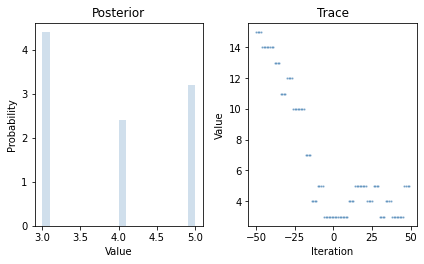

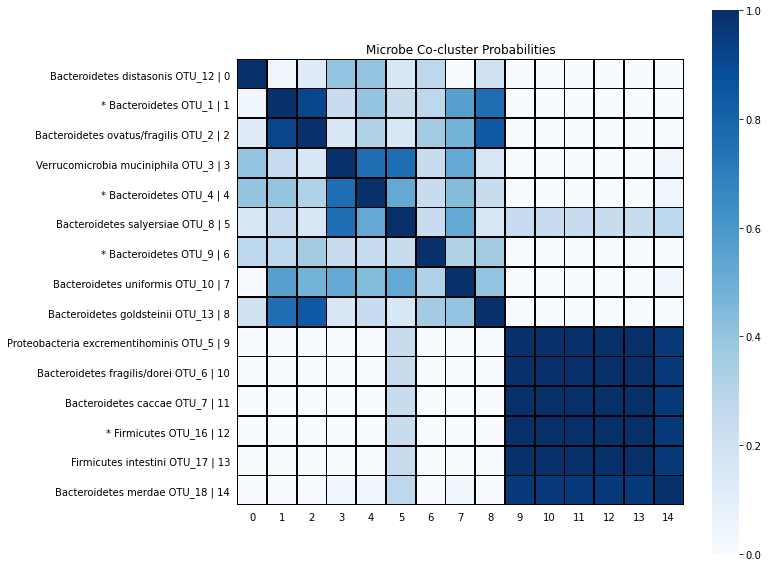

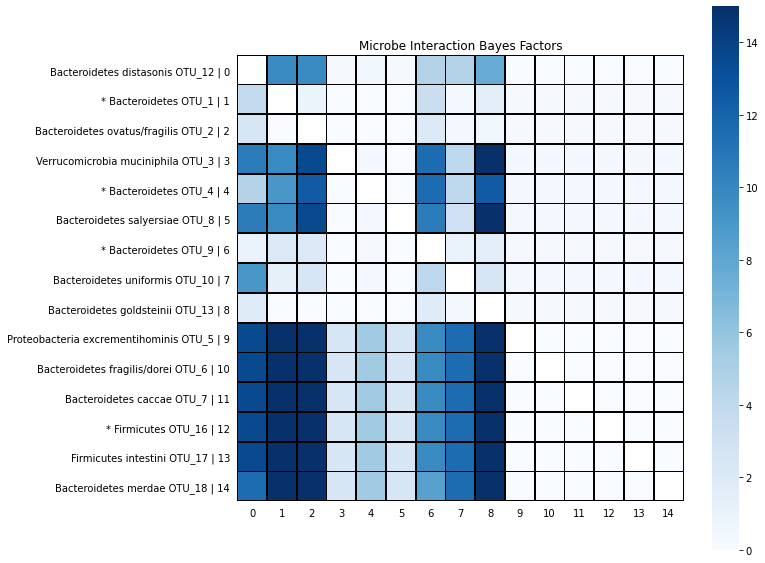

In [31]:
clustering = mcmc_uc0.graph[STRNAMES.CLUSTERING_OBJ]
md2.generate_cluster_assignments_posthoc(clustering, set_as_value=True)
taxa = mcmc_uc0.graph.data.taxa

md2.visualization.render_trace(clustering.n_clusters)
order = []
for i, cluster in enumerate(clustering):
    print('Cluster {}'.format(i))
    for oidx in cluster:
        print('\t', md2.taxaname_for_paper(taxa[oidx], taxa))
        order.append(oidx)

coclusters = md2.summary(mcmc_uc0.graph[STRNAMES.CLUSTERING_OBJ].coclusters)['mean']
md2.visualization.render_cocluster_probabilities(coclusters, taxa=uc_toy.taxa,
    yticklabels='%(paperformat)s | %(index)s', order=order)

bayes_factors = md2.generate_interation_bayes_factors_posthoc(mcmc_uc0)
md2.visualization.render_bayes_factors(
    bayes_factors, taxa=taxa, yticklabels='%(paperformat)s | %(index)s',
    order=order)
plt.show()

# Calculating  $\hat{r}$

In [32]:
params = md2.config.MDSINE2ModelConfig(
    basepath='output/mdsine2/uc100', seed=100, burnin=50, 
    n_samples=100, negbin_a0=a0, negbin_a1=a1, 
    checkpoint=50)
params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value_option'] = 'no-clusters'
mcmc_uc1 = md2.initialize_graph(params=params, graph_name=uc_toy.name, subjset=uc_toy)
mcmc_uc1 = md2.run_graph(mcmc_uc1, crash_if_error=True)


INFO:base.2727: max_value found: 1797837340792.1643, scaling_factor: 5.5622384590108656e-11
INFO:run.87: Normalizing abundances for a max value of 100. Normalization constant: 5.5622E-11
INFO:run.254: There are 372 qPCR measurements for 3 buckets. Each bucket is 124 measurements long
INFO:run.289: Initializing Filtering
INFO:posterior.2670: Setting up the essential timepoints
INFO:posterior.2683: Essential timepoints: [ 1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   6.   7.   8.   9.  10.  11.  14.  16.  18.  21.  21.5 22.  22.5 23.  23.5 24.  25.  28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  33.  35.  35.5 36.  36.5 37.  37.5 38.  39.  42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  47.  50.  50.5 51.  51.5 52.  52.5 53.  54.  57.  57.5 58.  58.5 59.  59.5 60.  60.5 61.  62.  63.  64.  64.5]
INFO:run.289: Initializing Zero inflation
INFO:design_matrices.851: Initializing LHS vector
INFO:design_matrices.1006: Initializing growth design matrix
INFO:design_matrices.932: Initializing self-inte

INFO:run.374: 		prior.loc: 0
INFO:run.372: 	perturbation Vancomycin
INFO:run.373: 		value: {100115: 0, 100116: 0, 100117: 0, 100118: 0, 100119: 0, 100120: 0, 100121: 0, 100122: 0, 100123: 0, 100124: 0, 100125: 0, 100126: 0, 100127: 0, 100128: 0, 100129: 0}
INFO:run.374: 		prior.loc: 0
INFO:run.372: 	perturbation Gentamicin
INFO:run.373: 		value: {100115: 0, 100116: 0, 100117: 0, 100118: 0, 100119: 0, 100120: 0, 100121: 0, 100122: 0, 100123: 0, 100124: 0, 100125: 0, 100126: 0, 100127: 0, 100128: 0, 100129: 0}
INFO:run.374: 		prior.loc: 0
INFO:run.375: Perturbation prior variances:
INFO:run.377: 		dof: 2.5
INFO:run.378: 		scale: 2000.0
INFO:run.379: 		value: 10000.0
INFO:run.377: 		dof: 2.5
INFO:run.378: 		scale: 2000.0
INFO:run.379: 		value: 10000.0
INFO:run.377: 		dof: 2.5
INFO:run.378: 		scale: 2000.0
INFO:run.379: 		value: 10000.0
INFO:run.380: Perturbation indicators:
INFO:run.383: 	perturbation High Fat Diet: [False False False False False False False False False False False False 

INFO:inference.456: Cluster interaction probability: 0.6902120211131538
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.030039310455322266s
perturbation High Fat Diet (9/15): [ True  True False  True False  True False  True  True  True False  True  True False False]
perturbation Vancomycin (11/15): [False  True False  True  True  True  True  True  True False  True False  True  True  True]
perturbation Gentamicin (11/15): [False  True  True False  True False False  True  True  True  True  True  True  True  True]
INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.543380172150942
	perturbation Vancomycin: 0.6541798484844479
	perturbation Gentamicin: 0.5771423101278725
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.09958    0.38387087 0.7283936  0.36285918 0.75078167

INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.24935488589151739
	perturbation Vancomycin: 0.39478510894188606
	perturbation Gentamicin: 0.0836243339418902
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.09957189 0.21635949 0.70717837 0.29550604 0.4482678  0.50763439 0.28883574 0.56296437 0.04565164 0.26232925 0.34255238 0.24172293 1.20049888 0.8471626  0.35822239]
Self Interactions:
[ 0.12229918  0.17919848  0.26583662  0.12226809  1.18765687  0.37478657  0.42474047  0.49806619 13.41267749 89.58921508  1.59763507 84.43380055  3.39319423  1.70660775  1.35282097]
Interactions:
[ 3.83274227e+01 -3.48940960e+01  1.08872832e+00 -3.69915372e+01 -3.85478815e+01 -5.59170951e-02  4.78135228e+00  2.41699377e-01 -1.24752743e+02 -1.17700560e+01  2.11959722e+00 -5.02257219e+00  5.70098702e-02 -2.34517573e+01  3

INFO:inference.456: Filtering: no-mp - Time: 0.2840, Acc: [0.612, 0.603, 0.620, 0.618, 0.607], data/sec: 19804.71
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 15
Cluster 100115
	members: ['OTU_1']
	size: 1
Cluster 100116
	members: ['OTU_2']
	size: 1
Cluster 100117
	members: ['OTU_3']
	size: 1
Cluster 100118
	members: ['OTU_4']
	size: 1
Cluster 100119
	members: ['OTU_5']
	size: 1
Cluster 100120
	members: ['OTU_6']
	size: 1
Cluster 100121
	members: ['OTU_7']
	size: 1
Cluster 100122
	members: ['OTU_8']
	size: 1
Cluster 100123
	members: ['OTU_9']
	size: 1
Cluster 100124
	members: ['OTU_10']
	size: 1
Cluster 100125
	members: ['OTU_12']
	size: 1
Cluster 100126
	members: ['OTU_13']
	size: 1
Cluster 100127
	members: ['OTU_16']
	size: 1
Cluster 100128
	members: ['OTU_17']
	size: 1
Cluster 100129
	members: ['OTU_18']
	size: 1
no mp - Total time: -1
INFO:inference.456: Clustering concentration parameter: 938.66310714

INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.08997769129193614
	perturbation Vancomycin: 0.10182442866807949
	perturbation Gentamicin: 0.03354019072715985
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.17136265 0.40177406 0.63648195 0.22807703 0.44415589 0.54373544 0.30906861 0.42988179 0.10936112 0.08288654 0.06592591 0.10648683 0.95775765 0.72361331 0.17563134]
Self Interactions:
[1.75656502e-01 2.22965695e-01 2.92670358e-01 5.21337041e+00 8.07793169e-01 4.57074689e-02 1.68926437e+00 1.09879157e+00 1.16986617e+02 7.63194134e+01 3.93673096e-01 5.70597652e+01 2.71953316e+00 2.86367539e+00 9.84384316e-01]
Interactions:
[ 1.75395794e-01  4.72274654e-01 -2.42855262e+00 -1.82655155e+00  3.15767297e+01  1.56505735e+00  2.94259854e-02 -1.48960285e+01 -2.76982454e+00 -9.56035841e-01]
Perturbations:
Pert

INFO:inference.447: 

Inference iteration 7/100, time: 0.3730299472808838
INFO:inference.456: Cluster interaction indicator parameter: [False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False 

INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.7912374883774207, Acceptance rate: 0.875
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 184.97407855510477
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 5528.266541497254
	perturbation Vancomycin: 2589.383830484611
	perturbation Gentamicin: 3030.096284631454
INFO:inference.456: Process Variance parameter: 4.471185734106456, empirical_variance: 4.38291
INFO:inference.456: Filtering: no-mp - Time: 0.2800, Acc: [0.617, 0.596, 0.618, 0.611, 0.584], data/sec: 20089.10
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 14
Cluster 100131
	members: ['OTU_2']
	size: 1
Cluster 100133
	members: ['OTU_8']
	size: 1
Cluster 100135
	members: ['OTU_12']
	size: 1
Clus

INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.07347864684307993
	perturbation Vancomycin: 0.12467362494920095
	perturbation Gentamicin: 0.0808235625508013
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.43779328 0.46403054 0.73544685 0.1281555  0.69398281 0.29696545 0.3081585  0.17216979 0.10289488 0.12980304 0.53920924 0.037853   0.99083254 0.91449774 0.35014422]
Self Interactions:
[  0.21940803   0.23235377   0.25358912   6.67470148   0.96407406   0.19648329   1.45685749   0.6263926   54.20830689 105.52214122   1.24834763  44.58020207   2.8098821    2.88465678   4.0930328 ]
Interactions:
[ 0.00904106 -0.92606366]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.79863545 -2.14226557]
	 perturbation Gentamicin: []
INFO:inference

INFO:inference.456: Cluster interaction probability: 0.020426685942397042
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.009966611862182617s
perturbation High Fat Diet (0/13): [False False False False False False False False False False False False False]
perturbation Vancomycin (1/13): [ True False False False False False False False False False False False False]
perturbation Gentamicin (0/13): [False False False False False False False False False False False False False]
INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.009723117980024558
	perturbation Vancomycin: 0.0018780161193492103
	perturbation Gentamicin: 0.05612789973131868
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.15756215 0.30584464 0.45238853 0.05925518 0.46821553 0.51092096 0.11046252 0.3008

INFO:inference.456: Clustering concentration parameter: 23.133409311506806
INFO:inference.447: 

Inference iteration 14/100, time: 0.36803722381591797
INFO:inference.456: Cluster interaction indicator parameter: [ True False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False F

INFO:inference.456: Filtering: no-mp - Time: 0.2700, Acc: [0.610, 0.601, 0.646, 0.622, 0.612], data/sec: 20833.91
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 12
Cluster 100138
	members: ['OTU_16', 'OTU_6', 'OTU_17']
	size: 3
Cluster 100163
	members: ['OTU_10', 'OTU_3']
	size: 2
Cluster 100176
	members: ['OTU_12']
	size: 1
Cluster 100178
	members: ['OTU_4']
	size: 1
Cluster 100180
	members: ['OTU_8']
	size: 1
Cluster 100181
	members: ['OTU_9']
	size: 1
Cluster 100183
	members: ['OTU_18']
	size: 1
Cluster 100185
	members: ['OTU_1']
	size: 1
Cluster 100188
	members: ['OTU_13']
	size: 1
Cluster 100190
	members: ['OTU_7']
	size: 1
Cluster 100192
	members: ['OTU_2']
	size: 1
Cluster 100196
	members: ['OTU_5']
	size: 1
no mp - Total time: 0.4869992733001709
INFO:inference.456: Clustering concentration parameter: 32.19028479457938
INFO:inference.447: 

Inference iteration 16/100, time: 0.3490333557128906
INFO:inf

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -4.5848508635742595
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -53.97791044844141
	perturbation Vancomycin: -154.79730953998765
	perturbation Gentamicin: -264.4715179395944
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.7722107601983961, Acceptance rate: 1.0
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.6462183194214082, Acceptance rate: 0.8823529411764706
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 64.59658491791268
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 3343.7149697418645
	perturbation Vancomycin: 37897.542718484874

INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.57401512 0.4272023  0.37624479 0.13439445 0.35259317 0.61562545 0.69930242 0.43769542 0.08664359 0.02374352 0.41044868 0.1291397  1.3083219  0.33405384 0.25859234]
Self Interactions:
[3.97717246e-01 2.35813212e-01 2.09258966e-01 2.27060558e+00 5.59352928e-01 1.10248138e-01 1.00987395e+00 1.03920070e+00 8.63091535e+01 1.14829146e+02 1.84769740e+00 3.80320936e+01 4.36963022e+00 2.49682486e+00 4.08383023e+00]
Interactions:
[-2.18591259 -0.15555275]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.24854729]
	 perturbation Gentamicin: []
INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -7.136562827980314
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -142.96884894433373

INFO:inference.456: Cluster interaction probability: 0.023496239452593038
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.01196908950805664s
perturbation High Fat Diet (0/10): [False False False False False False False False False False]
perturbation Vancomycin (2/10): [ True False  True False False False False False False False]
perturbation Gentamicin (0/10): [False False False False False False False False False False]
INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.000804569272812529
	perturbation Vancomycin: 0.15686178766219896
	perturbation Gentamicin: 0.004560830216201981
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.65372052 0.3989057  0.58363127 0.2143254  0.48472854 0.63949027 0.67328953 0.40809059 0.36335196 0.16282222 0.25174207 0.16503686 1.20730

INFO:inference.456: Cluster interaction probability: 0.012785083459415012
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.008977174758911133s
perturbation High Fat Diet (0/10): [False False False False False False False False False False]
perturbation Vancomycin (1/10): [ True False False False False False False False False False]
perturbation Gentamicin (0/10): [False False False False False False False False False False]
INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.013970073394085734
	perturbation Vancomycin: 0.0786370347336592
	perturbation Gentamicin: 0.06633661197944131
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.52470549 0.436773   0.50977548 0.43490989 0.65030734 0.31335068 0.57623915 0.31142065 0.11088987 0.23690656 0.3612008  0.18477927 1.280510

INFO:inference.456: Cluster interaction probability: 0.03256985853381462
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.009989738464355469s
perturbation High Fat Diet (0/8): [False False False False False False False False]
perturbation Vancomycin (2/8): [ True False False False False False False  True]
perturbation Gentamicin (0/8): [False False False False False False False False]
INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.00014182958373295818
	perturbation Vancomycin: 0.12771786542132266
	perturbation Gentamicin: 0.04335606476917943
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.23064839 0.34521645 0.65548908 0.38664915 0.6373291  0.56780243 0.96178067 0.23821992 0.15382038 0.18628211 0.72687936 0.18280891 1.31772531 0.94600507 0.40071415]
Self Intera

INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.00011598468972756694
	perturbation Vancomycin: 0.09382276560000982
	perturbation Gentamicin: 0.07870943386017569
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.37791869 0.50186339 0.41441033 0.21812209 0.60937968 0.68230935 0.51326689 0.36198888 0.06367832 0.01540539 0.60599747 0.23886943 0.8469675  0.9216541  0.3031934 ]
Self Interactions:
[3.40915040e-01 3.03414590e-01 1.94245750e-01 2.62731262e+00 1.04351272e+00 4.68983340e-01 1.36052079e-01 9.26761157e-01 1.88650305e+02 1.44499764e+02 2.89906816e+00 6.20503330e+01 1.82558829e+00 2.33667394e+00 5.21105977e+00]
Interactions:
[-0.58525246 -0.7342316 ]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.08928206]
	 perturbation Gentami

INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.55315346 0.34656032 0.66090237 0.18645377 0.55118878 0.44124782 0.34567548 0.13502606 0.11376308 0.09196727 0.66591554 0.01856753 1.06404169 1.02090331 0.54076719]
Self Interactions:
[  0.39292461   0.31175338   0.2775651    6.01012249   0.91209008   0.43934313   1.05604983   1.02518532 134.32842916 160.39537843   2.53897626  57.92937031   4.63135683   3.37539028   6.01543699]
Interactions:
[-1.60986161  0.11921122 -0.65717845]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.22877077]
	 perturbation Gentamicin: []
INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -0.15730130254033425
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 131.1913276902818
	perturbation Van

INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.9271442515913557, Acceptance rate: 1.0
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.8109882773455537, Acceptance rate: 0.9354838709677419
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 67.7536502622468
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 7069.5388561870095
	perturbation Vancomycin: 10484.66703409728
	perturbation Gentamicin: 1501.292783546172
INFO:inference.456: Process Variance parameter: 3.539962653453014, empirical_variance: 3.61795
INFO:inference.456: Filtering: no-mp - Time: 0.2810, Acc: [0.614, 0.641, 0.631, 0.637, 0.598], data/sec: 20017.77
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n

INFO:inference.456: Process Variance parameter: 3.559397165445073, empirical_variance: 3.56443
INFO:inference.456: Filtering: no-mp - Time: 0.2716, Acc: [0.637, 0.636, 0.613, 0.608, 0.625], data/sec: 20711.73
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 7
Cluster 100138
	members: ['OTU_16', 'OTU_7', 'OTU_6', 'OTU_17']
	size: 4
Cluster 100239
	members: ['OTU_10']
	size: 1
Cluster 100247
	members: ['OTU_2', 'OTU_12']
	size: 2
Cluster 100251
	members: ['OTU_8', 'OTU_13', 'OTU_5', 'OTU_4']
	size: 4
Cluster 100269
	members: ['OTU_3']
	size: 1
Cluster 100271
	members: ['OTU_1', 'OTU_18']
	size: 2
Cluster 100282
	members: ['OTU_9']
	size: 1
no mp - Total time: 0.24499845504760742
INFO:inference.456: Clustering concentration parameter: 7.854264245281343
INFO:inference.447: 

Inference iteration 34/100, time: 0.3260347843170166
INFO:inference.456: Cluster interaction indicator parameter: [False  True False False Fa

INFO:inference.456: Clustering concentration parameter: 7.2751361201720295
INFO:inference.447: 

Inference iteration 36/100, time: 0.31799960136413574
INFO:inference.456: Cluster interaction indicator parameter: [False  True False False False  True False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False]
total time: 0.015996456146240234, n_interactions: 3/42, 0.07
INFO:inference.456: Cluster interaction probability: 0.08766732018273676
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.007003307342529297s
perturbation High Fat Diet (0/7): [False False False False False False False]
perturbation Vancomycin (1/7): [ True False False False False False False]
perturbation Gentamicin (0/7): [False False False False False False False]
INFO:inference.456: Probability parameter for the beta prior of 

INFO:inference.456: Cluster interaction probability: 0.09891989362929415
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.006996631622314453s
perturbation High Fat Diet (0/7): [False False False False False False False]
perturbation Vancomycin (1/7): [ True False False False False False False]
perturbation Gentamicin (0/7): [False False False False False False False]
INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.012899900033660153
	perturbation Vancomycin: 0.11666398347846804
	perturbation Gentamicin: 0.11263606507383217
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.47034221 0.67790207 0.5075122  0.47722286 0.45627359 0.62703343 0.64580827 0.36386823 0.18806488 0.25289187 0.80672027 0.16579353 1.11908801 0.88451681 0.51517889]
Self Interactions:
[3.25747029e

INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.40534249 0.62267084 0.76211805 0.39136109 0.56456195 0.56461508 0.28482131 0.82035259 0.26726973 0.22156783 0.42983895 0.1590339  1.16196553 0.99545131 0.49851987]
Self Interactions:
[4.41449130e-01 2.17185993e-01 2.25472718e-01 5.16113568e+00 9.93979156e-01 4.93721063e-01 7.10828799e-01 1.51851581e+00 1.69678155e+02 2.19175515e+02 3.02243909e+00 8.89798582e+01 4.35364267e+00 3.31080351e+00 3.70630394e+00]
Interactions:
[-0.03182872 -0.99545306 -1.08803938]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.12628351]
	 perturbation Gentamicin: []
INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -2.0125029180642935
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -30.96

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -2.7404810686785592
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -64.85026606994336
	perturbation Vancomycin: -116.95594165729271
	perturbation Gentamicin: 34.17182770844259
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.0136622995811737, Acceptance rate: 1.0
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.696096377644732, Acceptance rate: 0.9523809523809523
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 30.07386807138693
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1488.3107817727757
	perturbation Vancomycin: 8054.553598570395
	p

INFO:inference.456: Process Variance parameter: 3.2939777681737974, empirical_variance: 3.27769
INFO:inference.456: Filtering: no-mp - Time: 0.2626, Acc: [0.613, 0.641, 0.629, 0.609, 0.617], data/sec: 21422.19
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 6
Cluster 100138
	members: ['OTU_16', 'OTU_10', 'OTU_4', 'OTU_6', 'OTU_17', 'OTU_18']
	size: 6
Cluster 100239
	members: ['OTU_2', 'OTU_7']
	size: 2
Cluster 100290
	members: ['OTU_1', 'OTU_3', 'OTU_8']
	size: 3
Cluster 100307
	members: ['OTU_12', 'OTU_9']
	size: 2
Cluster 100312
	members: ['OTU_13']
	size: 1
Cluster 100318
	members: ['OTU_5']
	size: 1
no mp - Total time: 0.23000049591064453
INFO:inference.456: Clustering concentration parameter: 1.7993882932293348
INFO:posterior.1585: 0/15: 10
INFO:posterior.1585: 1/15: 0
INFO:posterior.1585: 2/15: 6
INFO:posterior.1585: 3/15: 9
INFO:posterior.1585: 4/15: 14
INFO:posterior.1585: 5/15: 13
INFO:posterior.1585

INFO:inference.456: Clustering concentration parameter: 0.9485358272741873
INFO:inference.447: 

Inference iteration 47/100, time: 0.3060004711151123
INFO:inference.456: Cluster interaction indicator parameter: [False  True False False  True  True False False False False False False False False False False False False False False]
total time: 0.009968280792236328, n_interactions: 3/20, 0.15
INFO:inference.456: Cluster interaction probability: 0.1347315722130485
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.006032228469848633s
perturbation High Fat Diet (0/5): [False False False False False]
perturbation Vancomycin (1/5): [ True False False False False]
perturbation Gentamicin (0/5): [False False False False False]
INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.0011432854753505028
	perturbation Vancomycin: 0.1436644540793238

INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.009404913063441779
	perturbation Vancomycin: 0.0881112130485914
	perturbation Gentamicin: 0.1347683642963099
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.75840031 0.40017807 0.64379331 0.1951525  0.53931262 0.53817727 0.59500389 0.67465299 0.22318794 0.51346605 0.43420693 0.10453141 1.09775636 1.09098281 0.94301635]
Self Interactions:
[  0.40685806   0.27398655   0.2061778    6.96747519   0.91842416   0.35601908   0.97417752   1.42816935 171.33371061 182.95601176   2.19390799  64.07517066   3.27205764   4.23333129   4.12856918]
Interactions:
[-0.04522618 -0.9072851  -0.80081513  0.07372229]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.45622419]
	 perturbation Gentamicin: []
IN

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 2.9699630470653116
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 18.01828699261033
	perturbation Vancomycin: -26.417343862520298
	perturbation Gentamicin: 10.506673857670105
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.9087815519169008, Acceptance rate: 1.0
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.7311487426774008, Acceptance rate: 0.96
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 49.66897181732735
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 3557.056295584065
	perturbation Vancomycin: 1076.0645376515756
	perturbation Ge

INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 45.728688083575705
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 719.5772201900985
	perturbation Vancomycin: 1286.1268876035326
	perturbation Gentamicin: 719.09780539173
INFO:inference.456: Process Variance parameter: 2.881282702057938, empirical_variance: 2.98624
INFO:inference.456: Filtering: no-mp - Time: 0.2730, Acc: [0.622, 0.617, 0.612, 0.613, 0.614], data/sec: 20606.82
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 4
Cluster 100138
	members: ['OTU_7', 'OTU_16', 'OTU_6', 'OTU_17', 'OTU_18']
	size: 5
Cluster 100290
	members: ['OTU_8', 'OTU_5', 'OTU_10', 'OTU_1']
	size: 4
Cluster 100345
	members: ['OTU_3', 'OTU_9', 'OTU_13', 'OTU_2']
	size: 4
Cluster 100363
	members: ['OTU_12', 'OTU_4']
	size: 2
no mp - T

INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.006029844284057617s
perturbation High Fat Diet (0/4): [False False False False]
perturbation Vancomycin (1/4): [ True False False False]
perturbation Gentamicin (0/4): [False False False False]
INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.268581408121416
	perturbation Vancomycin: 0.20736876989334926
	perturbation Gentamicin: 0.08687229780662237
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.78194955 0.55647433 0.66845813 0.07126228 0.72781148 0.72720217 0.6560555  0.62528641 0.12309259 0.36740526 0.63943106 0.29181051 1.12063374 1.2685238  0.64776377]
Self Interactions:
[4.20765099e-01 3.28900816e-01 2.65375282e-01 8.24982660e+00 7.59980771e-01 3.68747936e-01 3.56601180e-02 1.21390504e+00 1.52843476e+02 2.4343

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -2.0970523465766866
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 25.41997228092972
	perturbation Vancomycin: -18.220744974985273
	perturbation Gentamicin: -120.78195183069896
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.4900119514611006, Acceptance rate: 1.0
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.35339565089472, Acceptance rate: 0.98
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 40.687554704447656
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2566.311724316491
	perturbation Vancomycin: 7336.221544534071
	perturbation Ge

INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 5
Cluster 100138
	members: ['OTU_16', 'OTU_6', 'OTU_17', 'OTU_18', 'OTU_7']
	size: 5
Cluster 100290
	members: ['OTU_4', 'OTU_3', 'OTU_1', 'OTU_8', 'OTU_2']
	size: 5
Cluster 100345
	members: ['OTU_5', 'OTU_9', 'OTU_13']
	size: 3
Cluster 100373
	members: ['OTU_12']
	size: 1
Cluster 100380
	members: ['OTU_10']
	size: 1
no mp - Total time: 0.1849989891052246
INFO:inference.456: Clustering concentration parameter: 3.082197155033145
INFO:posterior.1585: 0/15: 4
INFO:posterior.1585: 1/15: 12
INFO:posterior.1585: 2/15: 6
INFO:posterior.1585: 3/15: 14
INFO:posterior.1585: 4/15: 3
INFO:posterior.1585: 5/15: 0
INFO:posterior.1585: 6/15: 11
INFO:posterior.1585: 7/15: 9
INFO:posterior.1585: 8/15: 13
INFO:posterior.1585: 9/15: 7
INFO:posterior.1585: 10/15: 1
INFO:posterior.1585: 11/15: 2
INFO:posterior.1585: 12/15: 5
INFO:posterior.1585: 13/15: 10
INFO:posterior.1585: 14/15: 

INFO:inference.456: Cluster interaction probability: 0.3464002981240225
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.0069980621337890625s
perturbation High Fat Diet (0/5): [False False False False False]
perturbation Vancomycin (1/5): [ True False False False False]
perturbation Gentamicin (0/5): [False False False False False]
INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.015180008301248238
	perturbation Vancomycin: 0.10956827539207327
	perturbation Gentamicin: 0.07653734654078534
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.503406   0.46212137 0.43950615 0.17533105 0.7107293  0.76598977 0.65421529 0.3371151  0.29963231 0.20654079 0.57176235 0.00530666 1.18159361 0.85223323 0.63272311]
Self Interactions:
[3.96455441e-01 2.22299833e-01 2.55288356e-01 4.

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -1.4010832387289214
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 32.23335236325398
	perturbation Vancomycin: -54.92017477985805
	perturbation Gentamicin: 2.740762915305189
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.2520155698798041, Acceptance rate: 1.0
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.7614085629918204, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 34.44040157722139
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2345.469901916732
	perturbation Vancomycin: 2162.188007259011
	perturbation Genta

INFO:inference.456: Clustering concentration parameter: 0.6871369004484217
INFO:inference.447: 

Inference iteration 68/100, time: 0.3190011978149414
INFO:inference.456: Cluster interaction indicator parameter: [ True  True False  True  True False False False False False False False]
total time: 0.009999275207519531, n_interactions: 4/12, 0.33
INFO:inference.456: Cluster interaction probability: 0.3300135068471817
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.006029605865478516s
perturbation High Fat Diet (0/4): [False False False False]
perturbation Vancomycin (1/4): [ True False False False]
perturbation Gentamicin (0/4): [False False False False]
INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.015403885781172692
	perturbation Vancomycin: 0.19694229178576728
	perturbation Gentamicin: 0.02033047120030677
INFO:inference.456:

INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.64034023 0.37151724 0.57080373 0.19550153 0.4959145  0.87281013 0.80762944 0.47380474 0.33309708 0.17911744 0.54744553 0.21714176 1.14795266 1.11434852 0.75616409]
Self Interactions:
[4.36785393e-01 2.67271688e-01 2.78415006e-01 5.95254158e+00 1.04972800e+00 2.07112123e-01 4.34890474e-01 1.13703571e+00 2.58087664e+02 2.44355692e+02 2.90876639e+00 9.48023590e+01 1.48256918e+00 2.62933542e+00 1.00999807e+00]
Interactions:
[-0.07557013 -1.25922353  0.22017252 -1.01563351]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.14242099]
	 perturbation Gentamicin: []
INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -0.9731151879867903
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat 

INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 13.453920929387122
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 743.3053284822226
	perturbation Vancomycin: 1716.3744148653539
	perturbation Gentamicin: 2939.6841176133157
INFO:inference.456: Process Variance parameter: 2.6880810676146143, empirical_variance: 2.68109
INFO:inference.456: Filtering: no-mp - Time: 0.2690, Acc: [0.638, 0.613, 0.612, 0.612, 0.588], data/sec: 20909.18
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 4
Cluster 100138
	members: ['OTU_17', 'OTU_7', 'OTU_16', 'OTU_18', 'OTU_6']
	size: 5
Cluster 100290
	members: ['OTU_10', 'OTU_2', 'OTU_4', 'OTU_1', 'OTU_9', 'OTU_8', 'OTU_13', 'OTU_3']
	size: 8
Cluster 100416
	members: ['OTU_5']
	size: 1
Cluster 100424
	members: ['OTU_12']
	size: 1
no mp

INFO:inference.456: Cluster interaction indicator parameter: [ True False False False False False]
total time: 0.006989955902099609, n_interactions: 1/6, 0.17
INFO:inference.456: Cluster interaction probability: 0.16313757225718775
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.004031658172607422s
perturbation High Fat Diet (0/3): [False False False]
perturbation Vancomycin (1/3): [ True False False]
perturbation Gentamicin (0/3): [False False False]
INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.14005604060044455
	perturbation Vancomycin: 0.3434735196994371
	perturbation Gentamicin: 0.18049201394200032
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.811686   0.3905124  0.7060511  0.1382394  0.49512951 0.69600551 0.58366704 0.37737647 0.27632691 0.27054602 0.

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 9.379193363239693
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -370.31904366717987
	perturbation Vancomycin: 2.241956759512285
	perturbation Gentamicin: 11.453799050345859
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.3999400346163519, Acceptance rate: 1.0
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.46097055591587544, Acceptance rate: 0.98
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 40.489470833510836
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 3703.8851019152653
	perturbation Vancomycin: 1421.6854945429336
	perturbation 

INFO:inference.456: Clustering concentration parameter: 0.5584762227668479
INFO:inference.447: 

Inference iteration 80/100, time: 0.32558655738830566
INFO:inference.456: Cluster interaction indicator parameter: [ True False False False False False]
total time: 0.006002664566040039, n_interactions: 1/6, 0.17
INFO:inference.456: Cluster interaction probability: 0.03055062080457772
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.0070323944091796875s
perturbation High Fat Diet (0/3): [False False False]
perturbation Vancomycin (1/3): [ True False False]
perturbation Gentamicin (2/3): [ True False  True]
INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.0001349657574966941
	perturbation Vancomycin: 0.08845196376058882
	perturbation Gentamicin: 0.7368194997433709
INFO:inference.456: Logistic growth parameters (growth, self-interactio

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -2.9074454254457187
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -8.96895600230549
	perturbation Vancomycin: -11.459393599992676
	perturbation Gentamicin: 14.120842476964222
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.4178030984219693, Acceptance rate: 1.0
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.8141724939815347, Acceptance rate: 0.98
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 39.91709732811855
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2294.855610955472
	perturbation Vancomycin: 1960.0933613828715
	perturbation G

INFO:inference.456: Clustering concentration parameter: 3.976940969200101
INFO:posterior.1585: 0/15: 1
INFO:posterior.1585: 1/15: 8
INFO:posterior.1585: 2/15: 14
INFO:posterior.1585: 3/15: 7
INFO:posterior.1585: 4/15: 6
INFO:posterior.1585: 5/15: 10
INFO:posterior.1585: 6/15: 3
INFO:posterior.1585: 7/15: 0
INFO:posterior.1585: 8/15: 9
INFO:posterior.1585: 9/15: 12
INFO:posterior.1585: 10/15: 4
INFO:posterior.1585: 11/15: 2
INFO:posterior.1585: 12/15: 11
INFO:posterior.1585: 13/15: 13
INFO:posterior.1585: 14/15: 5
INFO:inference.447: 

Inference iteration 85/100, time: 0.530005693435669
INFO:inference.456: Cluster interaction indicator parameter: [ True False False False False False False False False False False False]
total time: 0.009026288986206055, n_interactions: 1/12, 0.08
INFO:inference.456: Cluster interaction probability: 0.03701830965471325
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.005997180938720703s
perturbation High Fat Diet (0/

INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.009416333264059213
	perturbation Vancomycin: 0.10309530968852622
	perturbation Gentamicin: 0.3663802230913488
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.66487604 0.39084431 0.63182271 0.22205373 0.59449677 0.76148239 0.58946138 0.46406665 0.17509937 0.22893342 0.58406603 0.33135298 1.16924902 0.88911995 0.87250086]
Self Interactions:
[4.96429481e-01 2.05199624e-01 2.42798631e-01 4.60693999e+00 1.05055470e+00 2.59130615e-01 3.93834153e-01 1.27041651e+00 1.73427275e+02 2.51451718e+02 2.70333434e+00 1.25340175e+02 2.74302251e+00 2.62212031e+00 1.53346559e+00]
Interactions:
[ -0.32475709 -26.09483422]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.25058327]
	 perturbation Gentamic

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -3.1002811853574546
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 47.37810570259916
	perturbation Vancomycin: 32.65892167718235
	perturbation Gentamicin: 86.54484036673375
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.8679820445916742, Acceptance rate: 1.0
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 3.752644636285556, Acceptance rate: 0.98
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 226.79772811589402
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1563.7670813379673
	perturbation Vancomycin: 1172.6082770695373
	perturbation Gen

INFO:inference.456: Process Variance parameter: 2.3349503813860912, empirical_variance: 2.37233
INFO:inference.456: Filtering: no-mp - Time: 0.2710, Acc: [0.614, 0.602, 0.629, 0.604, 0.604], data/sec: 20754.73
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 6
Cluster 100138
	members: ['OTU_6', 'OTU_17', 'OTU_18', 'OTU_16', 'OTU_7']
	size: 5
Cluster 100290
	members: ['OTU_2', 'OTU_12', 'OTU_10', 'OTU_1']
	size: 4
Cluster 100433
	members: ['OTU_3', 'OTU_8', 'OTU_5']
	size: 3
Cluster 100474
	members: ['OTU_4']
	size: 1
Cluster 100475
	members: ['OTU_9']
	size: 1
Cluster 100501
	members: ['OTU_13']
	size: 1
no mp - Total time: 0.24703288078308105
INFO:inference.456: Clustering concentration parameter: 2.2272559108428283
INFO:inference.447: 

Inference iteration 92/100, time: 0.3301360607147217
INFO:inference.456: Cluster interaction indicator parameter: [ True False False False False False False False False False

INFO:inference.456: Clustering concentration parameter: 3.5168206224277774
INFO:inference.447: 

Inference iteration 94/100, time: 0.3390007019042969
INFO:inference.456: Cluster interaction indicator parameter: [ True False False False False False False False False False False False False False False False False False False False False  True False False False False False  True False False False False False False False False False False False False False False]
total time: 0.015001296997070312, n_interactions: 3/42, 0.07
INFO:inference.456: Cluster interaction probability: 0.04603744192854234
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.008031606674194336s
perturbation High Fat Diet (0/7): [False False False False False False False]
perturbation Vancomycin (1/7): [ True False False False False False False]
perturbation Gentamicin (0/7): [False False False False False False False]
INFO:inference.456: Probability parameter for the beta prior of t

INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.0016801712070839742
	perturbation Vancomycin: 0.08710367675007992
	perturbation Gentamicin: 0.06885919493244642
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.69474459 0.44905939 0.63717411 0.01666444 0.57651989 0.66591866 0.36995406 0.51913187 0.19750589 0.24768645 0.66108138 0.20906706 1.16324765 0.9279854  0.56509739]
Self Interactions:
[3.32506713e-01 2.69039089e-01 2.37534714e-01 6.33788865e+00 9.27452783e-01 3.39214491e-01 6.38667144e-01 1.33513088e+00 2.93352244e+02 2.90120576e+02 2.76612271e+00 1.46674911e+02 3.85664396e+00 4.42047660e+00 1.43336574e+00]
Interactions:
[-0.27300144 10.18908078]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.69616118]
	 perturbation Gentamic

INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.54195825 0.42294974 0.54542895 0.16192928 0.62313202 0.59313513 0.70403993 0.65900463 0.14133763 0.17831063 0.44672329 0.23728745 1.08858095 1.23516757 0.64767191]
Self Interactions:
[3.60148713e-01 2.02326266e-01 2.31430170e-01 5.04925128e+00 8.57360076e-01 3.32608224e-01 3.38279060e-01 1.40279360e+00 2.57579311e+02 2.42645452e+02 2.69984304e+00 1.24779573e+02 3.24435362e+00 4.86940408e+00 1.41721439e+00]
Interactions:
[-0.24712122 12.81308411]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.20398623]
	 perturbation Gentamicin: [-1.84972642]
INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -5.668170394954014
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -55.5955

INFO:util.174: Number of clusters: 4
INFO:util.180: Clusters assigned: [0 0 0 0 1 3 3 0 0 0 2 1 3 3 3]


Cluster 0
	 * Firmicutes OTU_16
	 Bacteroidetes merdae OTU_18
	 Firmicutes intestini OTU_17
	 Bacteroidetes caccae OTU_7
	 Bacteroidetes fragilis/dorei OTU_6
Cluster 1
	 * Bacteroidetes OTU_1
	 Bacteroidetes ovatus/fragilis OTU_2
	 Verrucomicrobia muciniphila OTU_3
	 * Bacteroidetes OTU_4
	 Bacteroidetes salyersiae OTU_8
	 * Bacteroidetes OTU_9
	 Bacteroidetes uniformis OTU_10
Cluster 2
	 Proteobacteria excrementihominis OTU_5
	 Bacteroidetes goldsteinii OTU_13
Cluster 3
	 Bacteroidetes distasonis OTU_12


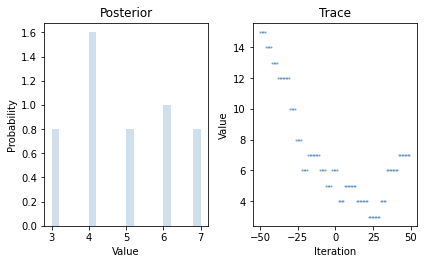

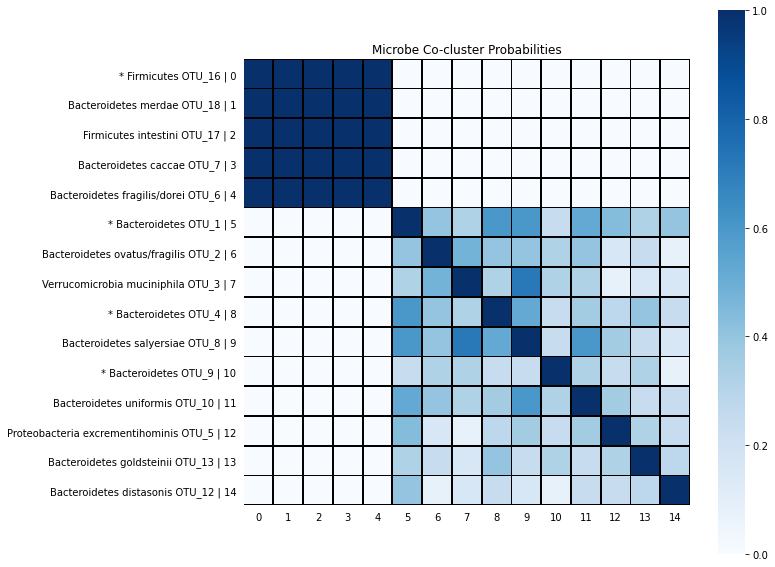

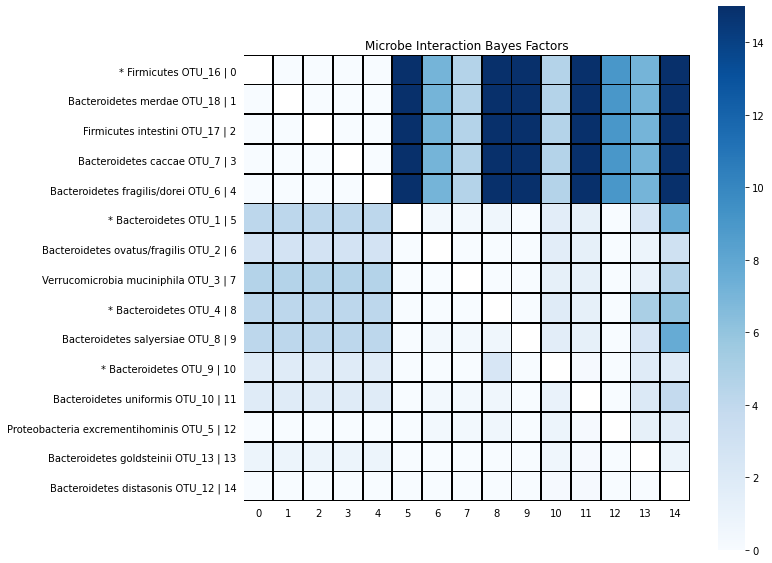

In [33]:
clustering = mcmc_uc1.graph[STRNAMES.CLUSTERING_OBJ]
md2.generate_cluster_assignments_posthoc(clustering, set_as_value=True)
taxa = mcmc_uc1.graph.data.taxa

md2.visualization.render_trace(clustering.n_clusters)
order = []
for i, cluster in enumerate(clustering):
    print('Cluster {}'.format(i))
    for oidx in cluster:
        print('\t', md2.taxaname_for_paper(taxa[oidx], taxa))
        order.append(oidx)

coclusters = md2.summary(mcmc_uc1.graph[STRNAMES.CLUSTERING_OBJ].coclusters)['mean']
md2.visualization.render_cocluster_probabilities(
    coclusters, taxa=uc_toy.taxa, yticklabels='%(paperformat)s | %(index)s',
    order=order)

bayes_factors = md2.generate_interation_bayes_factors_posthoc(mcmc_uc1)
md2.visualization.render_bayes_factors(
    bayes_factors, taxa=taxa, yticklabels='%(paperformat)s | %(index)s',
    order=order)

plt.show()

In [34]:
chains = [mcmc_uc0, mcmc_uc1]
start = 10
end = 20
vname = STRNAMES.GROWTH_VALUE

rhat = md2.pylab.inference.r_hat(chains, start=start, end=end, vname=vname)
print('Growth values:', rhat)

vname = STRNAMES.CONCENTRATION
rhat = md2.pylab.inference.r_hat(chains, start=start, end=end, vname=vname)
print('Concentration parameter:', rhat)

vname = STRNAMES.PROCESSVAR
rhat = md2.pylab.inference.r_hat(chains, start=start, end=end, vname=vname)
print('Process variance parameter:', rhat)


Growth values: [2.27759015 1.91194137 1.90157166 1.71162753 1.76806987 1.82309684 1.75571646 2.28988163 1.80208809 1.64993987 1.65244786 1.74677639 2.63487229 1.7743072  1.64481383]
Concentration parameter: [1.36955026]
Process variance parameter: [2.77366281]


# Consensus clustering
Run the model with a fixed modules

In [35]:
# Use the clustering from a previous as the clustering assignment
params = md2.config.MDSINE2ModelConfig(
    basepath=basepath, seed=0, burnin=50, n_samples=100, 
    negbin_a0=a0, negbin_a1=a1, checkpoint=50)

# Do not learn the clustering parameters
params.LEARN[STRNAMES.CLUSTERING] = False
params.LEARN[STRNAMES.CONCENTRATION] = False

# Set the initialization option for clustering
params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value_option'] = 'fixed-clustering'
params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value'] = 'output/mdsine2/uc100/mcmc.pkl'

mcmc = md2.initialize_graph(params=params, graph_name=uc_toy.name, subjset=uc_toy)
mcmc = md2.run_graph(mcmc, crash_if_error=True)

INFO:base.2727: max_value found: 1797837340792.1643, scaling_factor: 5.5622384590108656e-11
INFO:run.87: Normalizing abundances for a max value of 100. Normalization constant: 5.5622E-11
INFO:run.254: There are 372 qPCR measurements for 3 buckets. Each bucket is 124 measurements long
INFO:run.289: Initializing Filtering
INFO:posterior.2670: Setting up the essential timepoints
INFO:posterior.2683: Essential timepoints: [ 1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   6.   7.   8.   9.  10.  11.  14.  16.  18.  21.  21.5 22.  22.5 23.  23.5 24.  25.  28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  33.  35.  35.5 36.  36.5 37.  37.5 38.  39.  42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  47.  50.  50.5 51.  51.5 52.  52.5 53.  54.  57.  57.5 58.  58.5 59.  59.5 60.  60.5 61.  62.  63.  64.  64.5]
INFO:run.289: Initializing Zero inflation
INFO:design_matrices.851: Initializing LHS vector
INFO:design_matrices.1006: Initializing growth design matrix
INFO:design_matrices.932: Initializing self-inte

INFO:run.374: 		prior.loc: 0
INFO:run.372: 	perturbation Gentamicin
INFO:run.373: 		value: {100115: 0, 100116: 0, 100117: 0, 100118: 0}
INFO:run.374: 		prior.loc: 0
INFO:run.375: Perturbation prior variances:
INFO:run.377: 		dof: 2.5
INFO:run.378: 		scale: 2000.0
INFO:run.379: 		value: 10000.0
INFO:run.377: 		dof: 2.5
INFO:run.378: 		scale: 2000.0
INFO:run.379: 		value: 10000.0
INFO:run.377: 		dof: 2.5
INFO:run.378: 		scale: 2000.0
INFO:run.379: 		value: 10000.0
INFO:run.380: Perturbation indicators:
INFO:run.383: 	perturbation High Fat Diet: [False False False False]
INFO:run.383: 	perturbation Vancomycin: [False False False False]
INFO:run.383: 	perturbation Gentamicin: [False False False False]
INFO:run.384: Perturbation indicator probability:
INFO:run.386: 	perturbation High Fat Diet
INFO:run.387: 		value: 0.1527842458791451
INFO:run.388: 		prior.a: 0.5
INFO:run.389: 		prior.b: 2.772588722239781
INFO:run.386: 	perturbation Vancomycin
INFO:run.387: 		value: 0.1527842458791451
INFO:r

INFO:inference.447: 

Inference iteration 2/100, time: 0.33554530143737793
INFO:inference.456: Cluster interaction indicator parameter: [False False False False False False False False False False  True False]
total time: 0.012042522430419922, n_interactions: 1/12, 0.08
INFO:inference.456: Cluster interaction probability: 0.04080523952283359
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.006956815719604492s
perturbation High Fat Diet (0/4): [False False False False]
perturbation Vancomycin (1/4): [False False False  True]
perturbation Gentamicin (1/4): [ True False False False]
INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.010689706019422762
	perturbation Vancomycin: 0.18947173002497814
	perturbation Gentamicin: 0.042262163137034334
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/pert

INFO:inference.456: Process Variance parameter: 4.46790843043687, empirical_variance: 4.50564
INFO:inference.456: Filtering: no-mp - Time: 0.2740, Acc: [0.620, 0.636, 0.624, 0.615, 0.594], data/sec: 20529.13
INFO:inference.447: 

Inference iteration 5/100, time: 0.3160068988800049
INFO:inference.456: Cluster interaction indicator parameter: [False False False False False False False False False False  True False]
total time: 0.00699925422668457, n_interactions: 1/12, 0.08
INFO:inference.456: Cluster interaction probability: 0.09618522520553119
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.008002519607543945s
perturbation High Fat Diet (0/4): [False False False False]
perturbation Vancomycin (1/4): [False False False  True]
perturbation Gentamicin (0/4): [False False False False]
INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 

INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 14867.263791643105
	perturbation Vancomycin: 1568.6077945834418
	perturbation Gentamicin: 1404.1736631702959
INFO:inference.456: Process Variance parameter: 4.401297931032727, empirical_variance: 4.51663
INFO:inference.456: Filtering: no-mp - Time: 0.2790, Acc: [0.627, 0.620, 0.628, 0.629, 0.628], data/sec: 20163.65
INFO:inference.447: 

Inference iteration 8/100, time: 0.32004213333129883
INFO:inference.456: Cluster interaction indicator parameter: [False False False False False False False False False False False  True]
total time: 0.008999109268188477, n_interactions: 1/12, 0.08
INFO:inference.456: Cluster interaction probability: 0.02642490263384244
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.005029201507568359s
perturbation High Fat Diet (0/4): [False False False False]
perturbatio

INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.3606592080345865, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 34.5765014228529
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1665.9662526150025
	perturbation Vancomycin: 30962.295616894586
	perturbation Gentamicin: 2262.9135105850587
INFO:inference.456: Process Variance parameter: 4.339983026183199, empirical_variance: 4.38323
INFO:inference.456: Filtering: no-mp - Time: 0.2830, Acc: [0.620, 0.590, 0.636, 0.614, 0.597], data/sec: 19875.40
INFO:inference.447: 

Inference iteration 11/100, time: 0.3159675598144531
INFO:inference.456: Cluster interaction indicator parameter: [False False False False False False False False False False False  True]
total time: 0.007021427154541016, n_interactions: 1/12, 0

INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.31271640312945514, Acceptance rate: 0.8461538461538461
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.298759675786387, Acceptance rate: 0.9230769230769231
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 33.112292787547005
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 817.4578614362416
	perturbation Vancomycin: 4367.362879541128
	perturbation Gentamicin: 2157.713824048188
INFO:inference.456: Process Variance parameter: 4.284402523072991, empirical_variance: 4.30787
INFO:inference.456: Filtering: no-mp - Time: 0.2830, Acc: [0.627, 0.645, 0.592, 0.603, 0.619], data/sec: 19873.18
INFO:inference.447: 

Inference iteration 14/100, time: 0.31401562690734863
INFO:inference.456: Clu

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -1.8575541798637332
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 91.73278726824816
	perturbation Vancomycin: 29.544500659221537
	perturbation Gentamicin: 34.94280680901769
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.24623413730575217, Acceptance rate: 0.875
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 3.291046886596519, Acceptance rate: 0.9375
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 231.47919521160392
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 986.3439724794539
	perturbation Vancomycin: 4533.897565131829
	perturbation

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -0.24447079072502698
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 83.34506970485751
	perturbation Vancomycin: -15.43234694069277
	perturbation Gentamicin: -47.517608949605766
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.41423795314226763, Acceptance rate: 0.8947368421052632
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 3.153070863575008, Acceptance rate: 0.9473684210526315
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 17.372033065518085
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 9369.608129351978
	perturbation Vancomycin: 528

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -2.496991315296574
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -111.6649528956681
	perturbation Vancomycin: -4.546869182792594
	perturbation Gentamicin: 8.531086970188431
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.5330771597669527, Acceptance rate: 0.8181818181818182
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 3.916890082917551, Acceptance rate: 0.9545454545454546
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 88.52570134757104
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 4436.874360654091
	perturbation Vancomycin: 2901.978

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -3.0844229578403985
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -89.75978116026242
	perturbation Vancomycin: 6.964072593520322
	perturbation Gentamicin: 7.9172151171901755
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.255839231816282, Acceptance rate: 0.84
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 4.0582437294482165, Acceptance rate: 0.96
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 27.105588124514234
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1731.5047986682514
	perturbation Vancomycin: 5669.784105193812
	perturbation G

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 6.325605116243045
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -88.50355978149773
	perturbation Vancomycin: -23.702207018149718
	perturbation Gentamicin: 12.391605842592003
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.6119600546405104, Acceptance rate: 0.8571428571428571
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 4.00689518642993, Acceptance rate: 0.9642857142857143
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 182.5011592528249
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 10595.655934873053
	perturbation Vancomycin: 1518.59

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -4.495562315970082
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -33.31353660446302
	perturbation Vancomycin: 13.592140645829442
	perturbation Gentamicin: 2.984893204294531
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.4221552988045698, Acceptance rate: 0.8709677419354839
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 3.066999427088387, Acceptance rate: 0.967741935483871
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 11.874723795914297
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2734.8314284636185
	perturbation Vancomycin: 1011.32

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -2.3586152867945565
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 30.182466597002545
	perturbation Vancomycin: 52.30446885210676
	perturbation Gentamicin: 32.56185180493978
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.3326772225992634, Acceptance rate: 0.8823529411764706
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.6360741498375124, Acceptance rate: 0.9705882352941176
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 103.47180800820027
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1421.2431788807942
	perturbation Vancomycin: 1640.

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -6.01217229578715
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -17.84568148972631
	perturbation Vancomycin: 11.729518847157767
	perturbation Gentamicin: -23.950985731506474
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.837660468481236, Acceptance rate: 0.8918918918918919
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.297189984456416, Acceptance rate: 0.972972972972973
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 61.65276128262622
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 4257.0340172695705
	perturbation Vancomycin: 1028.034

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 2.427505186275602
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -78.89511169665614
	perturbation Vancomycin: 3.3477313012210286
	perturbation Gentamicin: 5.748759296004337
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.2712807646710504, Acceptance rate: 0.9
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 3.9725101757186323, Acceptance rate: 0.975
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 44.497701000961456
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 24776.07800703674
	perturbation Vancomycin: 3450.7485381842666
	perturbation Ge

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -4.955826788323743
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -102.57628873411579
	perturbation Vancomycin: 55.130162021049564
	perturbation Gentamicin: 47.078985266679936
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.4239333428592125, Acceptance rate: 0.8604651162790697
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 3.527097575761074, Acceptance rate: 0.9767441860465116
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 29.8241236220571
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 3080.385248083093
	perturbation Vancomycin: 2070.14

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -1.0404863892403933
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 35.06536169958741
	perturbation Vancomycin: -41.71289778326325
	perturbation Gentamicin: -31.13774812626761
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.5542880083215584, Acceptance rate: 0.8695652173913043
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 3.4263061969357578, Acceptance rate: 0.9782608695652174
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 25.400869971493478
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 3251.1651892129603
	perturbation Vancomycin: 2678

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 1.0731677939770017
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 43.188548414463064
	perturbation Vancomycin: -32.43710281159346
	perturbation Gentamicin: -127.75883722966503
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.994614016240481, Acceptance rate: 0.8775510204081632
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 3.085453662492897, Acceptance rate: 0.9795918367346939
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 27.104321320849014
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 4622.474262595775
	perturbation Vancomycin: 2151.8

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 1.1828148298836
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 86.09732704959465
	perturbation Vancomycin: -61.288003192607874
	perturbation Gentamicin: -69.04314293609605
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.547148602453225, Acceptance rate: 0.88
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.904756505756322, Acceptance rate: 0.98
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 11.943381089851291
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2007.2450516873162
	perturbation Vancomycin: 1656.8754690040832
	perturbation Gent

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 0.26441176608881345
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -25.60557487488276
	perturbation Vancomycin: 6.5098262432105045
	perturbation Gentamicin: 178.58833920787555
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.954926800981792, Acceptance rate: 0.88
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 3.682426927871017, Acceptance rate: 0.98
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 17.63624149030899
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 3664.3689352580964
	perturbation Vancomycin: 1016.1143608727676
	perturbation G

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 2.629282987158453
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 173.90650353862617
	perturbation Vancomycin: 55.478312974149254
	perturbation Gentamicin: 44.96167914951324
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 2.415014449218109, Acceptance rate: 0.88
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 3.5915481217581022, Acceptance rate: 0.98
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 37.72101413936939
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1360.5513169839794
	perturbation Vancomycin: 4628.150876568034
	perturbation Gent

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -2.6883385399939623
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -70.35589172875953
	perturbation Vancomycin: 13.326005547723081
	perturbation Gentamicin: -3.1016172121613472
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 2.1881129321192785, Acceptance rate: 0.9
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 4.412241747621734, Acceptance rate: 0.98
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 18.845670929526122
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 9379.297203028049
	perturbation Vancomycin: 936.1242707671815
	perturbation G

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -2.8230833611124186
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 121.6095301328022
	perturbation Vancomycin: -2.03486314444023
	perturbation Gentamicin: -44.5071779228792
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 2.574160337894608, Acceptance rate: 0.92
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 5.41961924400323, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 25.777096073585824
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1683.9245906216534
	perturbation Vancomycin: 786.6534316817638
	perturbation Gentam

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 1.2132949569312546
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -93.52862778186255
	perturbation Vancomycin: -103.689584319665
	perturbation Gentamicin: 119.42329657938838
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 2.4290314743147103, Acceptance rate: 0.92
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 6.180650912643667, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 32.87989492377049
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2163.60685247602
	perturbation Vancomycin: 7862.878855333638
	perturbation Gentam

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -11.235856938368196
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -167.7262157005333
	perturbation Vancomycin: -60.60153455946623
	perturbation Gentamicin: -140.3104417000471
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 2.6780305985384794, Acceptance rate: 0.94
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 6.7783948429043654, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 76.54494244552956
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 887.9210262140356
	perturbation Vancomycin: 1906.6580507696026
	perturbation G

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 0.5280698308656508
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 13.893647044402927
	perturbation Vancomycin: 93.30050938547087
	perturbation Gentamicin: -47.835341973982985
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 2.9562682332136534, Acceptance rate: 0.96
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 6.1689228029161995, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 41.72722795820897
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2690.1546736944824
	perturbation Vancomycin: 2532.3165845633816
	perturbation G

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 4.979147488443652
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -85.54577415286158
	perturbation Vancomycin: -33.95766319691363
	perturbation Gentamicin: 127.28333489025634
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 3.8849946884763256, Acceptance rate: 0.96
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 6.620108208011921, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 43.033332481674904
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 4414.9457711377745
	perturbation Vancomycin: 1673.7170294344685
	perturbation Ge

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -1.6050351131539025
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 135.90460740016994
	perturbation Vancomycin: 40.846046175485846
	perturbation Gentamicin: 1.5616021019936177
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 4.205579767298232, Acceptance rate: 0.96
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 7.765974447606769, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 30.68283285927479
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1166.1585427976026
	perturbation Vancomycin: 878.2424976711391
	perturbation Gen

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -2.1606525544059303
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -161.5475268109127
	perturbation Vancomycin: 14.206374688069431
	perturbation Gentamicin: -81.37588839704947
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 3.6822975712620365, Acceptance rate: 0.96
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 8.325995199958959, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 54.35132195327895
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1703.8116860654102
	perturbation Vancomycin: 2396.991588694939
	perturbation Ge

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 3.6883122779559687
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 214.35351503875424
	perturbation Vancomycin: 53.386688928895865
	perturbation Gentamicin: -103.5376572065153
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 4.40395408652855, Acceptance rate: 0.96
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 7.623771894613031, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 162.8400734198965
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 16839.74148275511
	perturbation Vancomycin: 2228.6864880139515
	perturbation Genta

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 4.01898866053529
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 14.851819004684675
	perturbation Vancomycin: 51.31003601903379
	perturbation Gentamicin: -11.131917833166682
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 3.925277050164136, Acceptance rate: 0.96
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 7.2028381213991315, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 49.66918734828847
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 709.2334253305996
	perturbation Vancomycin: 6465.357391499374
	perturbation Gentam

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 0.802644904162531
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 182.98932276447775
	perturbation Vancomycin: 35.599236694522645
	perturbation Gentamicin: -97.7627778359643
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 3.8552623476405383, Acceptance rate: 0.96
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 7.076974237538609, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 36.69167186373516
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1795.0642497050185
	perturbation Vancomycin: 2378.866221505809
	perturbation Genta

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -0.23620829801039256
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 32.21701228473006
	perturbation Vancomycin: -15.049385560592349
	perturbation Gentamicin: 109.17979231921164
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 3.80285185163586, Acceptance rate: 1.0
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 7.098528352286328, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 19.301786744711364
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 8193.191531052877
	perturbation Vancomycin: 1906.0728249064416
	perturbation Gen

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -4.2345897681165585
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 90.40966590129274
	perturbation Vancomycin: -7.917766811738673
	perturbation Gentamicin: -47.64821929033991
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 3.6619193432134103, Acceptance rate: 1.0
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 7.109143263297759, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 33.64304378771323
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 4660.288442048424
	perturbation Vancomycin: 1591.191633682764
	perturbation Genta

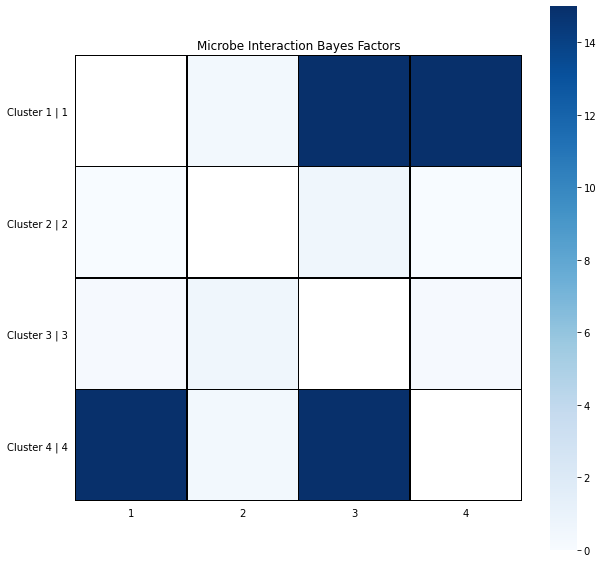

In [36]:
# Plot the posterior
clustering = mcmc.graph[STRNAMES.CLUSTERING_OBJ]
bf_taxa = md2.generate_interation_bayes_factors_posthoc(mcmc)
bf_clustering = md2.condense_fixed_clustering_interaction_matrix(bf_taxa, clustering=clustering)

labels = ['Cluster {} | {}'.format(i+1, i+1) for i in range(len(clustering))]
md2.visualization.render_bayes_factors(bf_clustering, yticklabels=labels)
plt.show()

# Cross validation

Take out a single subject and use that as initial conditions for forward simulation

In [37]:
# Make the data and validation Study objects
study = md2.dataset.parse(
    name='uc-toy-dataset', 
    taxonomy='data/uc-toy/taxonomy.tsv', 
    reads='data/uc-toy/reads.tsv', 
    qpcr='data/uc-toy/qpcr.tsv', 
    perturbations='data/uc-toy/perturbations.tsv', 
    metadata='data/uc-toy/metadata.tsv')

val = study.pop_subject('8')
val.name += '-validate'

print(study.name)
for subj in study:
    print(subj.name)
for pert in study.perturbations:
    print(pert)
print()
print(val.name)
for subj in val:
    print(subj.name)
for pert in val.perturbations:
    print(pert)


INFO:base.1275: TaxaSet parsng new taxonomy table. Resetting


uc-toy-dataset
10
6
7
9
Perturbation High Fat Diet:
	Subject 6: (21.5, 28.5)
	Subject 7: (21.5, 28.5)
	Subject 9: (21.5, 28.5)
	Subject 10: (21.5, 28.5)

Perturbation Vancomycin:
	Subject 6: (35.5, 42.5)
	Subject 7: (35.5, 42.5)
	Subject 9: (35.5, 42.5)
	Subject 10: (35.5, 42.5)

Perturbation Gentamicin:
	Subject 6: (50.5, 57.5)
	Subject 7: (50.5, 57.5)
	Subject 9: (50.5, 57.5)
	Subject 10: (50.5, 57.5)


unnamed-study-validate
8
Perturbation High Fat Diet:
	Subject 8: (21.5, 28.5)

Perturbation Vancomycin:
	Subject 8: (35.5, 42.5)

Perturbation Gentamicin:
	Subject 8: (50.5, 57.5)



In [38]:
# Learn the model
params = md2.config.MDSINE2ModelConfig(
    basepath='output/mdsine2/cv/'+study.name, seed=0, 
    burnin=50, n_samples=100, 
    negbin_a0=a0, negbin_a1=a1, checkpoint=50)
params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value_option'] = 'no-clusters'
mcmc = md2.initialize_graph(params=params, graph_name=study.name, subjset=study)
mcmc = md2.run_graph(mcmc, crash_if_error=True)

INFO:base.2727: max_value found: 1797837340792.1643, scaling_factor: 5.5622384590108656e-11
INFO:run.87: Normalizing abundances for a max value of 100. Normalization constant: 5.5622E-11
INFO:run.254: There are 297 qPCR measurements for 3 buckets. Each bucket is 99 measurements long
INFO:run.289: Initializing Filtering
INFO:posterior.2670: Setting up the essential timepoints
INFO:posterior.2683: Essential timepoints: [ 1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   6.   7.   8.   9.  10.  11.  14.  16.  18.  21.  21.5 22.  22.5 23.  23.5 24.  25.  28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  33.  35.  35.5 36.  36.5 37.  37.5 38.  39.  42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  47.  50.  50.5 51.  51.5 52.  52.5 53.  54.  57.  57.5 58.  58.5 59.  59.5 60.  60.5 61.  62.  63.  64.  64.5]
INFO:run.289: Initializing Zero inflation
INFO:design_matrices.851: Initializing LHS vector
INFO:design_matrices.1006: Initializing growth design matrix
INFO:design_matrices.932: Initializing self-inter

INFO:run.374: 		prior.loc: 0
INFO:run.372: 	perturbation Vancomycin
INFO:run.373: 		value: {100115: 0, 100116: 0, 100117: 0, 100118: 0, 100119: 0, 100120: 0, 100121: 0, 100122: 0, 100123: 0, 100124: 0, 100125: 0, 100126: 0, 100127: 0, 100128: 0, 100129: 0}
INFO:run.374: 		prior.loc: 0
INFO:run.372: 	perturbation Gentamicin
INFO:run.373: 		value: {100115: 0, 100116: 0, 100117: 0, 100118: 0, 100119: 0, 100120: 0, 100121: 0, 100122: 0, 100123: 0, 100124: 0, 100125: 0, 100126: 0, 100127: 0, 100128: 0, 100129: 0}
INFO:run.374: 		prior.loc: 0
INFO:run.375: Perturbation prior variances:
INFO:run.377: 		dof: 2.5
INFO:run.378: 		scale: 2000.0
INFO:run.379: 		value: 10000.0
INFO:run.377: 		dof: 2.5
INFO:run.378: 		scale: 2000.0
INFO:run.379: 		value: 10000.0
INFO:run.377: 		dof: 2.5
INFO:run.378: 		scale: 2000.0
INFO:run.379: 		value: 10000.0
INFO:run.380: Perturbation indicators:
INFO:run.383: 	perturbation High Fat Diet: [False False False False False False False False False False False False 

INFO:inference.456: Cluster interaction probability: 0.5907630856509913
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.02603936195373535s
perturbation High Fat Diet (9/15): [False  True False  True  True False  True  True  True  True False  True  True False False]
perturbation Vancomycin (10/15): [False  True False  True  True  True  True False  True False  True False  True  True  True]
perturbation Gentamicin (11/15): [False  True  True False  True  True False  True False  True  True  True  True  True  True]
INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.5032813527614807
	perturbation Vancomycin: 0.606532764595715
	perturbation Gentamicin: 0.65283684507178
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.1561304  0.39361365 0.65143108 0.36511188 0.60037192 0.

INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.08343731 0.21935548 0.45055237 0.08132064 0.66671448 0.71610887 0.152467   0.259189   0.29046298 0.30360319 0.32960671 0.44947594 1.45316177 0.76213581 0.15028379]
Self Interactions:
[1.88215473e-01 1.10014286e-01 1.68447523e-01 5.38095473e+00 1.23784027e+00 6.64952382e-01 5.98842899e-02 4.39603631e-01 3.69544485e+01 4.84587786e+01 1.37917981e+00 9.20794035e+01 3.78785974e+00 1.92941094e+00 3.31958442e+00]
Interactions:
[-76.98270038  68.23008154   4.79863125   0.99795047   3.4008842  -44.0271055    0.13252516  -0.40975003  97.33285797 -26.73860572 -23.78305834  -5.4921639    0.79531645  10.44121761  -1.35094035   7.13373344   2.47581292  -0.75713145  36.25984654 -20.93426006   9.1237103   -6.39001279 -13.47285215 -44.22444746 -19.05162269  -1.87190986 -22.29747116  14.11334439  66.25708272  -2.19687361   6.96958011   9.87724664   2.58918598  24.38410455 -58.90229762  -1.2

INFO:inference.456: Clustering concentration parameter: 2698.9912000084532
INFO:inference.447: 

Inference iteration 4/100, time: 0.3469705581665039
INFO:inference.456: Cluster interaction indicator parameter: [False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False  True False Fal

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -2.4843539449780985
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -119.14006393229901
	perturbation Vancomycin: -9.258626976098446
	perturbation Gentamicin: 20.009783278399667
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.4191071634859607, Acceptance rate: 1.0
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.2789934311021393, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 31.298263977838612
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 25245.826551965445
	perturbation Vancomycin: 4780.43595290712
	perturbation G

INFO:inference.456: Cluster interaction probability: 0.053223567657930494
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.013979673385620117s
perturbation High Fat Diet (0/14): [False False False False False False False False False False False False False False]
perturbation Vancomycin (1/14): [False  True False False False False False False False False False False False False]
perturbation Gentamicin (0/14): [False False False False False False False False False False False False False False]
INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.0008266084108613446
	perturbation Vancomycin: 0.05928057393067922
	perturbation Gentamicin: 0.002371445874271937
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.4029349  0.0296601  0.50147295 0.09993498 0.3339706  0.71740516

INFO:inference.456: Clustering concentration parameter: 92.22666078765575
INFO:posterior.1585: 0/15: 2
INFO:posterior.1585: 1/15: 7
INFO:posterior.1585: 2/15: 4
INFO:posterior.1585: 3/15: 11
INFO:posterior.1585: 4/15: 5
INFO:posterior.1585: 5/15: 8
INFO:posterior.1585: 6/15: 14
INFO:posterior.1585: 7/15: 3
INFO:posterior.1585: 8/15: 12
INFO:posterior.1585: 9/15: 6
INFO:posterior.1585: 10/15: 0
INFO:posterior.1585: 11/15: 9
INFO:posterior.1585: 12/15: 10
INFO:posterior.1585: 13/15: 1
INFO:posterior.1585: 14/15: 13
INFO:inference.447: 

Inference iteration 9/100, time: 0.8831050395965576
INFO:inference.456: Cluster interaction indicator parameter: [False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False Fal

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -2.5924740439711353
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -88.15743457749545
	perturbation Vancomycin: -3.941550297903161
	perturbation Gentamicin: 26.025190302474037
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.670138777383479, Acceptance rate: 1.0
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.37001466178474907, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 14.721298905803833
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1783.5716903701355
	perturbation Vancomycin: 2918.872126193267
	perturbation G

INFO:inference.456: Cluster interaction probability: 0.0039002884934129615
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.012031793594360352s
perturbation High Fat Diet (0/15): [False False False False False False False False False False False False False False False]
perturbation Vancomycin (2/15): [False False False False False False False False False False False False False  True  True]
perturbation Gentamicin (0/15): [False False False False False False False False False False False False False False False]
INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.13403722486135985
	perturbation Vancomycin: 0.28975308751028905
	perturbation Gentamicin: 0.02383443825128591
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.62932539 0.23430128 0.51906447 0.03786055 0.431

INFO:inference.456: Filtering: no-mp - Time: 0.2210, Acc: [0.615, 0.621, 0.615, 0.604], data/sec: 20362.61
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 15
Cluster 100180
	members: ['OTU_6']
	size: 1
Cluster 100182
	members: ['OTU_10']
	size: 1
Cluster 100184
	members: ['OTU_9']
	size: 1
Cluster 100186
	members: ['OTU_12']
	size: 1
Cluster 100187
	members: ['OTU_3']
	size: 1
Cluster 100189
	members: ['OTU_17']
	size: 1
Cluster 100190
	members: ['OTU_18']
	size: 1
Cluster 100192
	members: ['OTU_13']
	size: 1
Cluster 100194
	members: ['OTU_4']
	size: 1
Cluster 100196
	members: ['OTU_5']
	size: 1
Cluster 100197
	members: ['OTU_8']
	size: 1
Cluster 100198
	members: ['OTU_2']
	size: 1
Cluster 100199
	members: ['OTU_7']
	size: 1
Cluster 100201
	members: ['OTU_16']
	size: 1
Cluster 100203
	members: ['OTU_1']
	size: 1
no mp - Total time: 0.5539970397949219
INFO:inference.456: Clustering concentration parameter: 134

INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.006620855983310563
	perturbation Vancomycin: 0.2878068408213779
	perturbation Gentamicin: 0.014920839158986008
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.73060709 0.50733998 0.34498564 0.13920952 0.48051356 0.16036862 0.34458432 0.31590055 0.03872106 0.20304576 0.19336086 0.12959136 0.48733542 0.6729814  0.35118499]
Self Interactions:
[  0.46677599   0.25297994   0.15458181   6.10992812   0.65450507   0.78899535   1.96546683   1.71851399  90.25949321 154.29684804   1.29457929  66.39288162   4.44443235   2.50777984   4.59508585]
Interactions:
[-41.48616778]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-3.71813126 -2.76419939]
	 perturbation Gentamicin: []
INFO:inference.456: Mea

INFO:posterior.1585: 0/15: 11
INFO:posterior.1585: 1/15: 3
INFO:posterior.1585: 2/15: 13
INFO:posterior.1585: 3/15: 14
INFO:posterior.1585: 4/15: 10
INFO:posterior.1585: 5/15: 6
INFO:posterior.1585: 6/15: 0
INFO:posterior.1585: 7/15: 7
INFO:posterior.1585: 8/15: 1
INFO:posterior.1585: 9/15: 9
INFO:posterior.1585: 10/15: 12
INFO:posterior.1585: 11/15: 8
INFO:posterior.1585: 12/15: 4
INFO:posterior.1585: 13/15: 2
INFO:posterior.1585: 14/15: 5
INFO:inference.447: 

Inference iteration 17/100, time: 0.8790321350097656
INFO:inference.456: Cluster interaction indicator parameter: [False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False Fals

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -47.527024380881755
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 105.58517444413931
	perturbation Vancomycin: -12.733048409537728
	perturbation Gentamicin: 1.0007885216309866
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 2.741205296567615, Acceptance rate: 1.0
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.7725574838328727, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 21.353192117603484
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 9481.167420123391
	perturbation Vancomycin: 1990.760362190405
	perturbation Ge

INFO:inference.456: Cluster interaction probability: 0.008474569740740295
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.01200413703918457s
perturbation High Fat Diet (0/15): [False False False False False False False False False False False False False False False]
perturbation Vancomycin (3/15): [False False False  True False False False False False  True  True False False False False]
perturbation Gentamicin (0/15): [False False False False False False False False False False False False False False False]
INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.07708445111635516
	perturbation Vancomycin: 0.23930757068976252
	perturbation Gentamicin: 0.0015106194841068197
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.56785709 0.29919305 0.32888897 0.30366051 0.627

INFO:inference.456: Filtering: no-mp - Time: 0.2300, Acc: [0.611, 0.602, 0.625, 0.599], data/sec: 19564.08
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 13
Cluster 100199
	members: ['OTU_5', 'OTU_13']
	size: 2
Cluster 100226
	members: ['OTU_4']
	size: 1
Cluster 100229
	members: ['OTU_10']
	size: 1
Cluster 100231
	members: ['OTU_1']
	size: 1
Cluster 100233
	members: ['OTU_6']
	size: 1
Cluster 100235
	members: ['OTU_8', 'OTU_12']
	size: 2
Cluster 100237
	members: ['OTU_17']
	size: 1
Cluster 100239
	members: ['OTU_18']
	size: 1
Cluster 100241
	members: ['OTU_2']
	size: 1
Cluster 100243
	members: ['OTU_7']
	size: 1
Cluster 100246
	members: ['OTU_16']
	size: 1
Cluster 100247
	members: ['OTU_3']
	size: 1
Cluster 100250
	members: ['OTU_9']
	size: 1
no mp - Total time: 0.5050265789031982
INFO:inference.456: Clustering concentration parameter: 1829.1621511283902
INFO:inference.447: 

Inference iteration 22/100, time

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -153.35904257708745
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 6.9497161015385975
	perturbation Vancomycin: 25.851093347464897
	perturbation Gentamicin: -96.20545749259578
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 2.136272162537916, Acceptance rate: 1.0
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.3500486905907243, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 26.942031826903484
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 3414.6229656480205
	perturbation Vancomycin: 4254.137416828476
	perturbation Ge

INFO:inference.456: Cluster interaction probability: 0.00311287754968384
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.010020256042480469s
perturbation High Fat Diet (0/12): [False False False False False False False False False False False False]
perturbation Vancomycin (1/12): [ True False False False False False False False False False False False]
perturbation Gentamicin (1/12): [False False False False False False False  True False False False False]
INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.11481142993895396
	perturbation Vancomycin: 0.056586986501413146
	perturbation Gentamicin: 0.10535112009175719
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.48455364 0.33258858 0.52241952 0.2940643  0.47614961 0.24066341 0.19120547 0.39318104 0.33295677 0.068

INFO:inference.456: Cluster interaction probability: 0.0011798921315861422
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.009976625442504883s
perturbation High Fat Diet (0/12): [False False False False False False False False False False False False]
perturbation Vancomycin (1/12): [ True False False False False False False False False False False False]
perturbation Gentamicin (0/12): [False False False False False False False False False False False False]
INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.006060952579233037
	perturbation Vancomycin: 0.019652066264792375
	perturbation Gentamicin: 2.2942250181615867e-05
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.59281298 0.32007894 0.70261108 0.21823571 0.42088002 0.38779013 0.30667689 0.41640822 0.15055693

INFO:posterior.1585: 6/15: 8
INFO:posterior.1585: 7/15: 14
INFO:posterior.1585: 8/15: 0
INFO:posterior.1585: 9/15: 1
INFO:posterior.1585: 10/15: 9
INFO:posterior.1585: 11/15: 13
INFO:posterior.1585: 12/15: 2
INFO:posterior.1585: 13/15: 12
INFO:posterior.1585: 14/15: 5
INFO:inference.447: 

Inference iteration 29/100, time: 0.7659657001495361
INFO:inference.456: Cluster interaction indicator parameter: [False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False 

INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 11
Cluster 100237
	members: ['OTU_17']
	size: 1
Cluster 100264
	members: ['OTU_5']
	size: 1
Cluster 100272
	members: ['OTU_8']
	size: 1
Cluster 100274
	members: ['OTU_4']
	size: 1
Cluster 100275
	members: ['OTU_7']
	size: 1
Cluster 100278
	members: ['OTU_12', 'OTU_10']
	size: 2
Cluster 100279
	members: ['OTU_13', 'OTU_18']
	size: 2
Cluster 100281
	members: ['OTU_9', 'OTU_16']
	size: 2
Cluster 100284
	members: ['OTU_1', 'OTU_3']
	size: 2
Cluster 100285
	members: ['OTU_2']
	size: 1
Cluster 100290
	members: ['OTU_6']
	size: 1
no mp - Total time: 0.4610013961791992
INFO:inference.456: Clustering concentration parameter: 10.351467097602281
INFO:inference.447: 

Inference iteration 31/100, time: 0.30696535110473633
INFO:inference.456: Cluster interaction indicator parameter: [False False False False False False False False False False False False False False False Fal

INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 3938.130930181722
	perturbation Vancomycin: 2045.3911482325796
	perturbation Gentamicin: 1160.1632094753772
INFO:inference.456: Process Variance parameter: 3.526929747314283, empirical_variance: 3.54147
INFO:inference.456: Filtering: no-mp - Time: 0.2240, Acc: [0.609, 0.629, 0.628, 0.615], data/sec: 20089.35
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 11
Cluster 100237
	members: ['OTU_17']
	size: 1
Cluster 100264
	members: ['OTU_5']
	size: 1
Cluster 100272
	members: ['OTU_8']
	size: 1
Cluster 100274
	members: ['OTU_4']
	size: 1
Cluster 100275
	members: ['OTU_7']
	size: 1
Cluster 100278
	members: ['OTU_12', 'OTU_10']
	size: 2
Cluster 100279
	members: ['OTU_13', 'OTU_18']
	size: 2
Cluster 100281
	members: ['OTU_9', 'OTU_16']
	size: 2
Cluster 100284
	m

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 38.11040826126672
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 35.03647352538978
	perturbation Vancomycin: -10.714527591350828
	perturbation Gentamicin: 97.9921491399246
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.0290271077299324, Acceptance rate: 1.0
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.7417537374955931, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 6484.284087476507
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 15957.302839811073
	perturbation Vancomycin: 725.1812589707448
	perturbation Gentam

INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.07638337876697442
	perturbation Vancomycin: 0.17592393134667242
	perturbation Gentamicin: 0.10093166567242629
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.5366982  0.4322036  0.63889876 0.09095049 0.5717013  0.36372939 0.29876263 0.45476229 0.40141008 0.10670005 0.77689229 0.17993041 0.88909726 0.68570167 0.18800653]
Self Interactions:
[  0.48372002   0.29071363   0.21924886  11.33968084   1.08183495   1.20054213   1.23736047   1.26885733 183.8780146  117.69173039   3.08911909  84.02783207   3.98823756   4.62209119   4.54101843]
Interactions:
[]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: [3.47947995]
	 perturbation Vancomycin: [-2.52403442 -2.98085006]
	 perturbation Gentamicin: []
INFO:inference.456: Mean p

INFO:inference.456: Cluster interaction probability: 0.01816709328519292
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.010032415390014648s
perturbation High Fat Diet (0/11): [False False False False False False False False False False False]
perturbation Vancomycin (2/11): [ True False False False False  True False False False False False]
perturbation Gentamicin (0/11): [False False False False False False False False False False False]
INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.003645801793136214
	perturbation Vancomycin: 0.21503201388604756
	perturbation Gentamicin: 0.0011224681640126545
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.88308205 0.28821676 0.484981   0.21899661 0.51404046 0.49890956 0.40980905 0.4541502  0.39734331 0.17213076 0.29098464

INFO:inference.456: Cluster interaction probability: 0.014507523631974308
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.009977579116821289s
perturbation High Fat Diet (0/11): [False False False False False False False False False False False]
perturbation Vancomycin (2/11): [ True False False False False  True False False False False False]
perturbation Gentamicin (0/11): [False False False False False False False False False False False]
INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.01742981266255197
	perturbation Vancomycin: 0.08891809887500175
	perturbation Gentamicin: 0.0007200945866975301
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.65210273 0.45166122 0.26417422 0.23939261 0.57167617 0.77941943 0.41133721 0.37394926 0.42645402 0.15037685 0.64130131

INFO:inference.456: Clustering concentration parameter: 16.071639045463932
INFO:inference.447: 

Inference iteration 42/100, time: 0.3356199264526367
INFO:inference.456: Cluster interaction indicator parameter: [False False False False False  True False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False Fa

INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 4671.942715524161
	perturbation Vancomycin: 1950.4822131196909
	perturbation Gentamicin: 3184.335841276122
INFO:inference.456: Process Variance parameter: 3.333391203426855, empirical_variance: 3.26758
INFO:inference.456: Filtering: no-mp - Time: 0.2210, Acc: [0.634, 0.604, 0.628, 0.603], data/sec: 20357.91
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 13
Cluster 100237
	members: ['OTU_6', 'OTU_16']
	size: 2
Cluster 100303
	members: ['OTU_7']
	size: 1
Cluster 100330
	members: ['OTU_9']
	size: 1
Cluster 100332
	members: ['OTU_10']
	size: 1
Cluster 100333
	members: ['OTU_3']
	size: 1
Cluster 100335
	members: ['OTU_13']
	size: 1
Cluster 100337
	members: ['OTU_18', 'OTU_2']
	size: 2
Cluster 100339
	members: ['OTU_8']
	size: 1
Cluster 100341
	members: ['OT

INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.58476787 0.40236093 0.53450958 0.09498287 0.54778767 0.75754319 0.36085651 0.17885431 0.14396402 0.06091506 0.51716287 0.34185159 1.14301877 0.37304333 0.21842855]
Self Interactions:
[3.49661511e-01 1.96747622e-01 2.57111333e-01 4.97132811e+00 8.97731152e-01 3.98502736e-01 2.28753819e+00 4.82533479e-01 2.05845022e+02 2.49458687e+02 2.21784585e+00 1.08983549e+02 3.33456747e+00 3.49615382e+00 2.17831023e+00]
Interactions:
[ -0.28953501 -77.23594141 -42.41937457 -10.67803133 -37.62324098]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [5.9983684]
	 perturbation Gentamicin: []
INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -34.55015438915918
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturba

INFO:inference.456: Cluster interaction probability: 0.017993997166662147
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.012031793594360352s
perturbation High Fat Diet (0/13): [False False False False False False False False False False False False False]
perturbation Vancomycin (1/13): [False False False False False False False  True False False False False False]
perturbation Gentamicin (0/13): [False False False False False False False False False False False False False]
INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.06207795571681751
	perturbation Vancomycin: 0.055314182807224714
	perturbation Gentamicin: 0.06837800247875112
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.47148948 0.30585113 0.54124428 0.37971685 0.66590153 0.41918925 0.80977192 0.336148

INFO:inference.456: Clustering concentration parameter: 153.0726669666798
INFO:posterior.1585: 0/15: 11
INFO:posterior.1585: 1/15: 6
INFO:posterior.1585: 2/15: 0
INFO:posterior.1585: 3/15: 10
INFO:posterior.1585: 4/15: 8
INFO:posterior.1585: 5/15: 3
INFO:posterior.1585: 6/15: 2
INFO:posterior.1585: 7/15: 4
INFO:posterior.1585: 8/15: 9
INFO:posterior.1585: 9/15: 1
INFO:posterior.1585: 10/15: 5
INFO:posterior.1585: 11/15: 12
INFO:posterior.1585: 12/15: 13
INFO:posterior.1585: 13/15: 14
INFO:posterior.1585: 14/15: 7
INFO:inference.447: 

Inference iteration 49/100, time: 0.7609961032867432
INFO:inference.456: Cluster interaction indicator parameter: [False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False  True False False False False False False False False False False Fa

INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.082453447655408, Acceptance rate: 1.0
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.6497056218550121, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 5698.592609129466
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2992.2287785945086
	perturbation Vancomycin: 2524.685703069245
	perturbation Gentamicin: 5253.7390012017295
INFO:inference.456: Process Variance parameter: 3.0177516452539144, empirical_variance: 2.96223
INFO:inference.456: Filtering: no-mp - Time: 0.2161, Acc: [0.639, 0.608, 0.611, 0.617], data/sec: 20822.36
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 13
Cluste

INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.78838654 0.42154226 0.27856585 0.3828841  0.76611712 0.64033994 0.6777414  0.46994766 0.40925219 0.04671645 0.47183675 0.47980934 0.90832152 1.07063171 0.42607564]
Self Interactions:
[3.62391504e-01 2.77706835e-01 1.66877754e-01 5.76361132e+00 1.30772773e+00 5.22797459e-01 2.36519518e+00 1.24979921e+00 1.71319098e+02 1.90209061e+02 3.15928215e+00 8.54851661e+01 3.67227439e+00 5.18661517e+00 5.73681673e+00]
Interactions:
[  -1.02207917   -0.16479457 -128.37806375 -154.85723672   -0.28811141]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.7130154]
	 perturbation Gentamicin: []
INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 26.42212667116481
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	per

INFO:inference.456: Cluster interaction probability: 0.0925585622463167
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.00997614860534668s
perturbation High Fat Diet (0/11): [False False False False False False False False False False False]
perturbation Vancomycin (1/11): [False False False False False False False False False  True False]
perturbation Gentamicin (0/11): [False False False False False False False False False False False]
INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.12429313009673026
	perturbation Vancomycin: 0.17840341969314885
	perturbation Gentamicin: 0.030327354614069234
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.49788032 0.61218235 0.49903851 0.20906739 0.76931811 0.70886443 0.4961924  0.15006019 0.28176148 0.07182808 0.57267816 0.2

INFO:inference.456: Cluster interaction probability: 0.0666492369571409
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.01003122329711914s
perturbation High Fat Diet (0/11): [False False False False False False False False False False False]
perturbation Vancomycin (2/11): [ True False False False False False False False False  True False]
perturbation Gentamicin (0/11): [False False False False False False False False False False False]
INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.03975830922575344
	perturbation Vancomycin: 0.08107005433362273
	perturbation Gentamicin: 0.09766273073923384
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.54862744 0.48572263 0.31598078 0.30261633 0.4145239  0.59669177 0.50563128 0.25338584 0.38536596 0.13017759 0.69183306 0.11

INFO:inference.456: Clustering concentration parameter: 22.78503524256136
INFO:inference.447: 

Inference iteration 58/100, time: 0.3219926357269287
INFO:inference.456: Cluster interaction indicator parameter: [ True  True False  True False  True False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False  True False False False False False  True False False False False False False False False False False False False]
total time: 0.03699970245361328, n_interactions: 10/110, 0.09
INFO:inference.456: Cluster interaction probability: 0.14042184357

INFO:inference.456: Clustering concentration parameter: 9.26386293417959
INFO:inference.447: 

Inference iteration 60/100, time: 0.30699944496154785
INFO:inference.456: Cluster interaction indicator parameter: [False False False False False False False False False  True False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False  True False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False]
total time: 0.03999972343444824, n_interactions: 6/110, 0.05
INFO:inference.456: Cluster interaction probability: 0.046749654192

INFO:inference.456: Process Variance parameter: 2.7938552298137718, empirical_variance: 2.80957
INFO:inference.456: Filtering: no-mp - Time: 0.2210, Acc: [0.616, 0.613, 0.621, 0.621], data/sec: 20363.75
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 9
Cluster 100387
	members: ['OTU_16', 'OTU_7', 'OTU_6']
	size: 3
Cluster 100421
	members: ['OTU_4', 'OTU_17']
	size: 2
Cluster 100433
	members: ['OTU_5', 'OTU_12', 'OTU_2']
	size: 3
Cluster 100436
	members: ['OTU_8']
	size: 1
Cluster 100439
	members: ['OTU_13']
	size: 1
Cluster 100440
	members: ['OTU_1']
	size: 1
Cluster 100444
	members: ['OTU_3']
	size: 1
Cluster 100447
	members: ['OTU_10', 'OTU_18']
	size: 2
Cluster 100452
	members: ['OTU_9']
	size: 1
no mp - Total time: 0.3729994297027588
INFO:inference.456: Clustering concentration parameter: 10.862844093177554
INFO:inference.447: 

Inference iteration 62/100, time: 0.28799962997436523
INFO:inference.456: Clu

INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 9
Cluster 100387
	members: ['OTU_16', 'OTU_7', 'OTU_6']
	size: 3
Cluster 100421
	members: ['OTU_4', 'OTU_17']
	size: 2
Cluster 100433
	members: ['OTU_5', 'OTU_12', 'OTU_2']
	size: 3
Cluster 100436
	members: ['OTU_8']
	size: 1
Cluster 100439
	members: ['OTU_13']
	size: 1
Cluster 100440
	members: ['OTU_1']
	size: 1
Cluster 100444
	members: ['OTU_3']
	size: 1
Cluster 100447
	members: ['OTU_10', 'OTU_18']
	size: 2
Cluster 100452
	members: ['OTU_9']
	size: 1
no mp - Total time: 0.3729994297027588
INFO:inference.456: Clustering concentration parameter: 6.391974625127252
INFO:inference.447: 

Inference iteration 64/100, time: 0.2785670757293701
INFO:inference.456: Cluster interaction indicator parameter: [False  True False False False False False False False False False  True False False False False False False False  True False False False False False False False Fals

INFO:inference.456: Filtering: no-mp - Time: 0.2190, Acc: [0.616, 0.613, 0.623, 0.620], data/sec: 20544.69
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 6
Cluster 100387
	members: ['OTU_6', 'OTU_7', 'OTU_17', 'OTU_16']
	size: 4
Cluster 100455
	members: ['OTU_3', 'OTU_18', 'OTU_5', 'OTU_1', 'OTU_4', 'OTU_8', 'OTU_10']
	size: 7
Cluster 100459
	members: ['OTU_13']
	size: 1
Cluster 100460
	members: ['OTU_12']
	size: 1
Cluster 100465
	members: ['OTU_9']
	size: 1
Cluster 100470
	members: ['OTU_2']
	size: 1
no mp - Total time: 0.33499813079833984
INFO:inference.456: Clustering concentration parameter: 2.72157102041751
INFO:inference.447: 

Inference iteration 66/100, time: 0.27700066566467285
INFO:inference.456: Cluster interaction indicator parameter: [False False  True  True  True False False  True  True False False False False False False False False False False False False False False False False False False F

INFO:inference.456: Cluster interaction probability: 0.1526062347398
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.008025646209716797s
perturbation High Fat Diet (0/6): [False False False False False False]
perturbation Vancomycin (1/6): [ True False False False False False]
perturbation Gentamicin (1/6): [False  True False False False False]
INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.013722582803793367
	perturbation Vancomycin: 0.07934266407170532
	perturbation Gentamicin: 0.25995569684794023
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.8761383  0.36427717 0.63870509 0.25890639 0.5839393  0.66908849 0.49909164 0.71135399 0.19942674 0.28345968 0.67428113 0.10769672 0.62811253 0.71647566 0.58728153]
Self Interactions:
[  0.40489848   0.21131558   0.196

INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.019115035302488342
	perturbation Vancomycin: 0.16502985988310703
	perturbation Gentamicin: 0.02183034551265479
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.77644309 0.45661286 0.33717992 0.03550936 0.74488442 0.77413159 0.71250653 0.55468432 0.28647571 0.15393901 0.21620026 0.26996241 1.00338668 1.13775673 0.73231984]
Self Interactions:
[3.16695055e-01 2.29294359e-01 1.45371448e-01 6.02170360e+00 7.26345168e-01 4.47863220e-01 2.36777261e-01 5.81653868e-01 1.74630438e+02 1.36886228e+02 1.87867395e+00 1.09466688e+02 1.76215552e+00 3.47627238e+00 2.94532202e+00]
Interactions:
[ -0.11181289  -0.70382425 -21.82638907  -0.61948906  -0.91490906  -2.66834385  -6.03397576]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: [

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 0.8903973204469384
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -81.92519190375619
	perturbation Vancomycin: -39.03873475914688
	perturbation Gentamicin: -62.466708662106164
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.8159922130492767, Acceptance rate: 1.0
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 3.923746476759951, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 359.54748835349767
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1646.5919942510884
	perturbation Vancomycin: 2004.1817696407518
	perturbation G

INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.5507772122797514, Acceptance rate: 1.0
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 3.7158524471785426, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 154.63945136863305
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 297.82466546612386
	perturbation Vancomycin: 1464.2450806777508
	perturbation Gentamicin: 2381.3564259683394
INFO:inference.456: Process Variance parameter: 2.6594786692611954, empirical_variance: 2.63192
INFO:inference.456: Filtering: no-mp - Time: 0.2370, Acc: [0.615, 0.596, 0.640, 0.646], data/sec: 18987.25
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 7
Clus

INFO:inference.456: Process Variance parameter: 2.5052492261467036, empirical_variance: 2.58688
INFO:inference.456: Filtering: no-mp - Time: 0.2260, Acc: [0.629, 0.635, 0.620, 0.617], data/sec: 19910.78
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 7
Cluster 100387
	members: ['OTU_18', 'OTU_7', 'OTU_6', 'OTU_16', 'OTU_17']
	size: 5
Cluster 100455
	members: ['OTU_10', 'OTU_3']
	size: 2
Cluster 100472
	members: ['OTU_8', 'OTU_5', 'OTU_9', 'OTU_1']
	size: 4
Cluster 100495
	members: ['OTU_2']
	size: 1
Cluster 100497
	members: ['OTU_13']
	size: 1
Cluster 100499
	members: ['OTU_12']
	size: 1
Cluster 100504
	members: ['OTU_4']
	size: 1
no mp - Total time: 0.3009660243988037
INFO:inference.456: Clustering concentration parameter: 12.343728261940395
INFO:posterior.1585: 0/15: 7
INFO:posterior.1585: 1/15: 14
INFO:posterior.1585: 2/15: 2
INFO:posterior.1585: 3/15: 0
INFO:posterior.1585: 4/15: 5
INFO:posterior.1585: 5/

INFO:inference.456: Filtering: no-mp - Time: 0.2370, Acc: [0.644, 0.611, 0.611, 0.623], data/sec: 18984.94
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 8
Cluster 100387
	members: ['OTU_18', 'OTU_6', 'OTU_17', 'OTU_16', 'OTU_7']
	size: 5
Cluster 100472
	members: ['OTU_8', 'OTU_1', 'OTU_5']
	size: 3
Cluster 100510
	members: ['OTU_3', 'OTU_9']
	size: 2
Cluster 100515
	members: ['OTU_12']
	size: 1
Cluster 100517
	members: ['OTU_13']
	size: 1
Cluster 100520
	members: ['OTU_4']
	size: 1
Cluster 100522
	members: ['OTU_10']
	size: 1
Cluster 100526
	members: ['OTU_2']
	size: 1
no mp - Total time: 0.3130025863647461
INFO:inference.456: Clustering concentration parameter: 7.533991399841932
INFO:inference.447: 

Inference iteration 79/100, time: 0.2939882278442383
INFO:inference.456: Cluster interaction indicator parameter: [ True False  True False False False False False False  True False False False False False Fals

INFO:inference.456: Clustering concentration parameter: 8.106393928960612
INFO:posterior.1585: 0/15: 5
INFO:posterior.1585: 1/15: 9
INFO:posterior.1585: 2/15: 12
INFO:posterior.1585: 3/15: 11
INFO:posterior.1585: 4/15: 7
INFO:posterior.1585: 5/15: 10
INFO:posterior.1585: 6/15: 6
INFO:posterior.1585: 7/15: 14
INFO:posterior.1585: 8/15: 8
INFO:posterior.1585: 9/15: 4
INFO:posterior.1585: 10/15: 13
INFO:posterior.1585: 11/15: 2
INFO:posterior.1585: 12/15: 3
INFO:posterior.1585: 13/15: 0
INFO:posterior.1585: 14/15: 1
INFO:inference.447: 

Inference iteration 81/100, time: 0.5630290508270264
INFO:inference.456: Cluster interaction indicator parameter: [ True False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False]
total t

INFO:inference.456: Cluster interaction probability: 0.047539008766804995
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.00700068473815918s
perturbation High Fat Diet (1/6): [False False False  True False False]
perturbation Vancomycin (1/6): [ True False False False False False]
perturbation Gentamicin (0/6): [False False False False False False]
INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.01705889550006628
	perturbation Vancomycin: 0.22851584265743208
	perturbation Gentamicin: 0.024227922361710334
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.95805554 0.30726102 0.66561827 0.30044265 0.56317168 0.85870691 0.69473096 0.26351673 0.31595797 0.03714338 0.75822785 0.14657632 0.89512745 0.95228888 0.9755333 ]
Self Interactions:
[5.69342791e-01 2.13092768e-01

INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.7158465  0.38251496 0.61150481 0.10121685 0.53577352 0.92709839 0.67096784 0.36462023 0.35433072 0.06531875 0.61776178 0.13763225 0.9605739  0.96026523 0.41961594]
Self Interactions:
[4.09453032e-01 2.43267723e-01 2.62849135e-01 8.62957612e+00 9.69836719e-01 6.15899731e-01 2.02896004e-01 1.24955915e+00 3.13634029e+02 2.48245382e+02 2.41573027e+00 1.15984388e+02 2.09189346e+00 1.35893558e+00 4.79097996e-01]
Interactions:
[-0.26463951]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.1208631]
	 perturbation Gentamicin: []
INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -11.137009732715539
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -179.11116933077435
	perturbati

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -45.85951169752537
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 181.14884558498684
	perturbation Vancomycin: -18.62862470667453
	perturbation Gentamicin: -155.5963923451554
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.7116616747590203, Acceptance rate: 1.0
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.968521158186368, Acceptance rate: 0.98
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 325.7782827320764
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1833.9559450587387
	perturbation Vancomycin: 1990.6854121043614
	perturbation Ge

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -49.13295967407195
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 74.77776066019493
	perturbation Vancomycin: 67.47653879760429
	perturbation Gentamicin: 136.6769541157849
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.5550120784319317, Acceptance rate: 1.0
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.8913170582647227, Acceptance rate: 0.98
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 1042.118562183783
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2431.044273737161
	perturbation Vancomycin: 4211.7934366501495
	perturbation Genta

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -34.160849646878596
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -48.03333059609547
	perturbation Vancomycin: -16.97311539313401
	perturbation Gentamicin: 20.809099842091637
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 2.0080314371810446, Acceptance rate: 1.0
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.946910123131119, Acceptance rate: 0.98
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 2371.378894586614
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 3697.9830571571288
	perturbation Vancomycin: 1679.7074077925215
	perturbation G

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -42.67229693551906
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 47.81612470126898
	perturbation Vancomycin: -22.802780430483036
	perturbation Gentamicin: -32.970557886627155
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 2.416921323502989, Acceptance rate: 1.0
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.2893260976937944, Acceptance rate: 0.98
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 1946.9188973579874
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1118.755912793353
	perturbation Vancomycin: 1573.411904755594
	perturbation Ge

INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.591073877799576, Acceptance rate: 0.98
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 2114.6854909720055
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 5135.943491751765
	perturbation Vancomycin: 1071.2867896791954
	perturbation Gentamicin: 3383.1431713918428
INFO:inference.456: Process Variance parameter: 2.4110739986598952, empirical_variance: 2.36089
INFO:inference.456: Filtering: no-mp - Time: 0.2222, Acc: [0.608, 0.643, 0.621, 0.594], data/sec: 20251.12
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 8
Cluster 100387
	members: ['OTU_18', 'OTU_16', 'OTU_17', 'OTU_7', 'OTU_6']
	size: 5
Cluster 100472
	members: ['OTU_1', 'OTU_2', 'OTU_12']
	size: 

INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 3.1238564306125713, Acceptance rate: 0.98
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 4544.094506290717
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 538.2198569185896
	perturbation Vancomycin: 868.7507439168627
	perturbation Gentamicin: 80282.14729248022
INFO:inference.456: Process Variance parameter: 2.3594315747850185, empirical_variance: 2.37012
INFO:inference.456: Filtering: no-mp - Time: 0.2250, Acc: [0.614, 0.594, 0.627, 0.614], data/sec: 20000.26
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 8
Cluster 100387
	members: ['OTU_7', 'OTU_18', 'OTU_17', 'OTU_6', 'OTU_16']
	size: 5
Cluster 100472
	members: ['OTU_1', 'OTU_2']
	size: 2
Cluster 10

INFO:inference.456: Process Variance parameter: 2.3325827784465227, empirical_variance: 2.36231
INFO:inference.456: Filtering: no-mp - Time: 0.2211, Acc: [0.628, 0.610, 0.631, 0.596], data/sec: 20352.86
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 8
Cluster 100387
	members: ['OTU_7', 'OTU_18', 'OTU_17', 'OTU_6', 'OTU_16']
	size: 5
Cluster 100472
	members: ['OTU_1', 'OTU_2']
	size: 2
Cluster 100551
	members: ['OTU_12', 'OTU_8']
	size: 2
Cluster 100600
	members: ['OTU_5']
	size: 1
Cluster 100602
	members: ['OTU_10']
	size: 1
Cluster 100604
	members: ['OTU_13', 'OTU_3']
	size: 2
Cluster 100608
	members: ['OTU_4']
	size: 1
Cluster 100610
	members: ['OTU_9']
	size: 1
no mp - Total time: 0.3150026798248291
INFO:inference.456: Clustering concentration parameter: 2.4052444082688895
INFO:inference.488: Inference total time: 0.4094884419441223/Gibb step
INFO:inference.492: remove local traces
INFO:run.547: Denormali

In [39]:
# Forward simulate

# Get the initial conditions
subj = val['8']
M_truth = subj.matrix()['abs']
initial_conditions = M_truth[:,0]
initial_conditions[initial_conditions==0] = 1e5
times = subj.times

# Forward simulate for each gibb step
M = md2.model.gLVDynamicsSingleClustering.forward_sim_from_chain(
    mcmc, subj=subj, initial_conditions=initial_conditions, times=times, 
    simulation_dt=0.01)


INFO:model.116: 5/50 - 0.41903018951416016
INFO:model.116: 10/50 - 0.42055821418762207
INFO:model.116: 15/50 - 0.42603039741516113
INFO:model.116: 20/50 - 0.4220085144042969
INFO:model.116: 25/50 - 0.4030740261077881
INFO:model.116: 30/50 - 0.41000914573669434
INFO:model.116: 35/50 - 0.40996813774108887
INFO:model.116: 40/50 - 0.4169940948486328
INFO:model.116: 45/50 - 0.40703582763671875


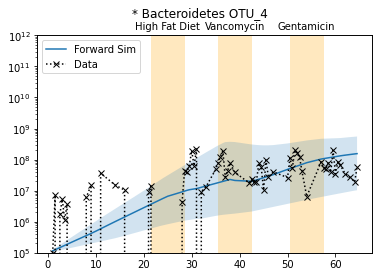

In [40]:
# Plot the forward sims, 25th-75th percentile
taxa = subj.taxa

low = np.percentile(M, q=25, axis=0)
high = np.percentile(M, q=75, axis=0)
med = np.percentile(M, q=50, axis=0)

oidx = 3

fig = plt.figure()
ax = fig.add_subplot(111)
ax.fill_between(times, y1=low[oidx, :], y2=high[oidx, :], alpha=0.2)
ax.plot(times, med[oidx,:], label='Forward Sim')
ax.plot(times, M_truth[oidx, :], label='Data', marker='x', color='black',
       linestyle=':')
ax.set_yscale('log')

md2.visualization.shade_in_perturbations(ax, perturbations=subj.perturbations, subj=subj)
ax.set_ylim(bottom=1e5, top=1e12)

ax.legend()

fig.suptitle(md2.taxaname_for_paper(taxa[oidx], taxa))
plt.show()

# Keystoneness
Calculate the keystoneness by using the `MDSINE2_Paper/keystoneness.py` script of the chain `uc100`.

Each line out table indicates which OTUs to leave out for that iteration of forward simulating to the steady state. Note that these are 0-based indecies for the OTUs.

In [41]:
# Make the leave out table - leave out each Cluster
os.makedirs('output/keystoneness', exist_ok=True)

mcmc = md2.BaseMCMC.load('output/mdsine2/uc100/mcmc.pkl')
clustering = mcmc.graph[STRNAMES.CLUSTERING_OBJ]
md2.generate_cluster_assignments_posthoc(clustering, set_as_value=True)
print(clustering)

txt = '\n'.join([','.join([str(oidx) for oidx in cluster.members]) for cluster in clustering])
f = open('output/keystoneness/leave_out_table.csv', 'w')
f.write(txt)
f.close()
print(txt)

!python ../keystoneness.py \
    --input output/mdsine2/uc0/mcmc.pkl \
    --study output/mdsine2/uc0/subjset.pkl \
    --leave-out-table output/keystoneness/leave_out_table.csv \
    --sep , \
    --simulation-dt 0.01 \
    --output-basepath output/keystoneness/ \
    --n-days 60

INFO:util.174: Number of clusters: 4
INFO:util.180: Clusters assigned: [0 0 0 0 1 3 3 0 0 0 2 1 3 3 3]


Clustering object (contains ability to change the cluster assignments), n_clusters: 4
Cluster 100138
	members: ['OTU_16', 'OTU_18', 'OTU_17', 'OTU_7', 'OTU_6']
	size: 5
Cluster 100539
	members: ['OTU_1', 'OTU_2', 'OTU_3', 'OTU_4', 'OTU_8', 'OTU_9', 'OTU_10']
	size: 7
Cluster 100540
	members: ['OTU_5', 'OTU_13']
	size: 2
Cluster 100541
	members: ['OTU_12']
	size: 1
12,14,13,6,5
0,1,2,3,7,8,9
4,11
10


INFO:keystoneness.187: "all" provided as index. Iterating over each index
INFO:keystoneness.205: Forward simulating
INFO:keystoneness.210: Input is an MDSINE2.BaseMCMC object
INFO:keystoneness.242: not indexing out anything
INFO:keystoneness.81: 5/50 - 0.46602702140808105
INFO:keystoneness.81: 10/50 - 0.46796631813049316
INFO:keystoneness.81: 15/50 - 0.4660007953643799
INFO:keystoneness.81: 20/50 - 0.4660935401916504
INFO:keystoneness.81: 25/50 - 0.4600059986114502
INFO:keystoneness.81: 30/50 - 0.4579651355743408
INFO:keystoneness.81: 35/50 - 0.4630002975463867
INFO:keystoneness.81: 40/50 - 0.4640026092529297
INFO:keystoneness.81: 45/50 - 0.45803165435791016
INFO:keystoneness.233: indexing out [12, 14, 13, 6, 5]
INFO:keystoneness.81: 5/50 - 0.4564187526702881
INFO:keystoneness.81: 10/50 - 0.44699668884277344
INFO:keystoneness.81: 15/50 - 0.4560251235961914
INFO:keystoneness.81: 20/50 - 0.4449765682220459
INFO:keystoneness.81: 25/50 - 0.44500160217285156
INFO:keystoneness.81: 30/50 - 0.

In [42]:
# Display the steady state table
df_steady_state = pd.read_csv('output/keystoneness/uc-toy-dataset/steady-state-table.tsv',
                sep='\t', index_col=0)
df_steady_state.head()

,OTU_1,OTU_2,OTU_3,OTU_4,OTU_5,OTU_6,OTU_7,OTU_8,OTU_9,OTU_10,OTU_12,OTU_13,OTU_16,OTU_17,OTU_18
base,3.093428e+10,1.815624e+10,4.236230e+10,89692.651509,9.435731e+09,1.315288e+10,8.232234e+09,5.233964e+09,3.692423e+06,1690.799349,3.812976e+09,3.530125e+07,4.806152e+09,3.075512e+09,6.914767e+08
9,3.093448e+10,1.815649e+10,4.236230e+10,89692.704823,9.435806e+09,1.315282e+10,8.232218e+09,5.233964e+09,3.692425e+06,NaN,3.813007e+09,3.530125e+07,4.806110e+09,3.075499e+09,6.914773e+08
"0,1,3,4,8,10",NaN,NaN,4.236230e+10,NaN,NaN,4.257117e+10,9.548776e+10,5.233964e+09,NaN,1690.799349,NaN,3.530125e+07,1.081247e+10,5.706281e+09,6.914767e+08
"2,7",3.093428e+10,1.815624e+10,NaN,89692.651509,9.435731e+09,1.315288e+10,8.232234e+09,NaN,3.692423e+06,1690.799349,3.812976e+09,3.530125e+07,4.806152e+09,3.075512e+09,6.914767e+08
11,3.092293e+10,1.814069e+10,4.236230e+10,89692.527527,9.431990e+09,1.316054e+10,8.241588e+09,5.233964e+09,3.692383e+06,1692.466952,3.811552e+09,NaN,4.808368e+09,3.077318e+09,6.915369e+08


In [43]:
# Display the keystoneness table
df_keystoneness = pd.read_csv('output/keystoneness/uc-toy-dataset/keystoneness.tsv',
                sep='\t', index_col=0)
df_keystoneness.head()

,l2 distance
9,3.523628e+05
"0,1,3,4,8,10",1.034113e+11
"2,7",6.276099e-06
11,2.331681e+07
"5,6,12,13",0.000000e+00


# Perturbation analysis

In [44]:
!python ../perturbation_analysis.py \
    --input output/mdsine2/uc0/mcmc.pkl \
    --study output/mdsine2/uc0/subjset.pkl \
    --leave-out-table output/keystoneness/leave_out_table.csv \
    --perturbation Vancomycin \
    --output-basepath output/keystoneness/pert_analysis \
    --start-perturbation 60 \
    --end-perturbation 120 \
    --n-days 180

<class 'mdsine2.pylab.base.Perturbations'>
0.01
120.0
60.0
180
18001
0.01
120.0
60.0
180
18001
0.01


INFO:perturbation_analysis.149: "all" provided as index. Iterating over each index
INFO:perturbation_analysis.169: Forward simulating
INFO:perturbation_analysis.174: Input is an MDSINE2.BaseMCMC object
INFO:perturbation_analysis.222: indexing out [12, 14, 13, 6, 5]
INFO:dynamics.280: Simulating 10000/18001
INFO:dynamics.280: Simulating 10000/18001
INFO:dynamics.280: Simulating 10000/18001
INFO:dynamics.280: Simulating 10000/18001
INFO:dynamics.280: Simulating 10000/18001
INFO:perturbation_analysis.57: 5/50 - 1.490027666091919
INFO:dynamics.280: Simulating 10000/18001
INFO:dynamics.280: Simulating 10000/18001
INFO:dynamics.280: Simulating 10000/18001
INFO:dynamics.280: Simulating 10000/18001
INFO:dynamics.280: Simulating 10000/18001
INFO:perturbation_analysis.57: 10/50 - 1.4820301532745361
INFO:dynamics.280: Simulating 10000/18001
INFO:dynamics.280: Simulating 10000/18001
INFO:dynamics.280: Simulating 10000/18001
INFO:dynamics.280: Simulating 10000/18001
INFO:dynamics.280: Simulating 10

120.0
60.0
180
18001
0.01
120.0
60.0
180
18001


INFO:dynamics.280: Simulating 10000/18001
INFO:dynamics.280: Simulating 10000/18001
INFO:dynamics.280: Simulating 10000/18001
INFO:dynamics.280: Simulating 10000/18001
INFO:dynamics.280: Simulating 10000/18001
INFO:perturbation_analysis.57: 5/50 - 1.5500643253326416
INFO:dynamics.280: Simulating 10000/18001
INFO:dynamics.280: Simulating 10000/18001
INFO:dynamics.280: Simulating 10000/18001
INFO:dynamics.280: Simulating 10000/18001
INFO:dynamics.280: Simulating 10000/18001
INFO:perturbation_analysis.57: 10/50 - 1.531132459640503
INFO:dynamics.280: Simulating 10000/18001
INFO:dynamics.280: Simulating 10000/18001
INFO:dynamics.280: Simulating 10000/18001
INFO:dynamics.280: Simulating 10000/18001
INFO:dynamics.280: Simulating 10000/18001
INFO:perturbation_analysis.57: 15/50 - 1.5336666107177734
INFO:dynamics.280: Simulating 10000/18001
INFO:dynamics.280: Simulating 10000/18001
INFO:dynamics.280: Simulating 10000/18001
INFO:dynamics.280: Simulating 10000/18001
INFO:dynamics.280: Simulating 

# Full Synthetic
Forward simulate with ICML dataset

INFO:synthetic.175: Forward simulating subj1
INFO:synthetic.175: Forward simulating subj2
INFO:synthetic.175: Forward simulating subj3
INFO:synthetic.175: Forward simulating subj4
INFO:synthetic.239: Fitting real data


13
4


<AxesSubplot:title={'center':'Abundance, Subject subj1, asv level'}, xlabel='Days', ylabel='CFUs/g'>

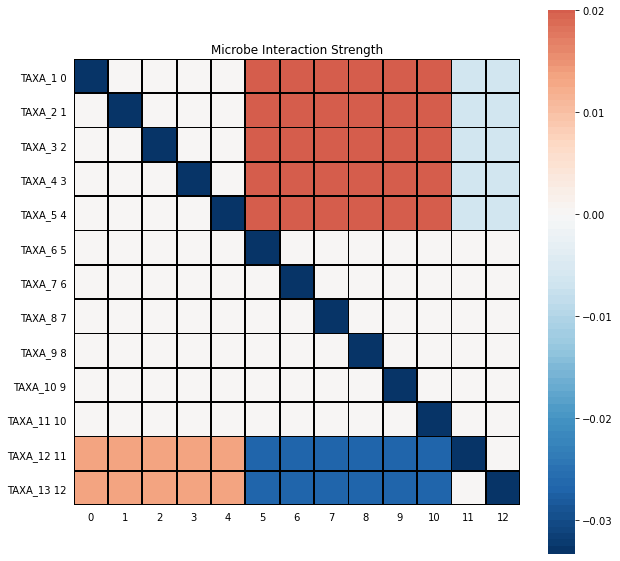

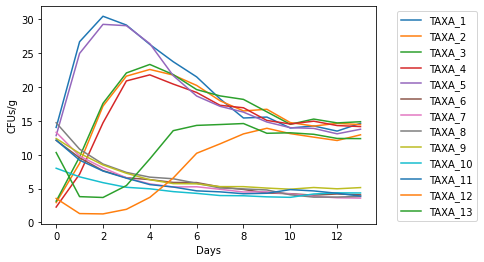

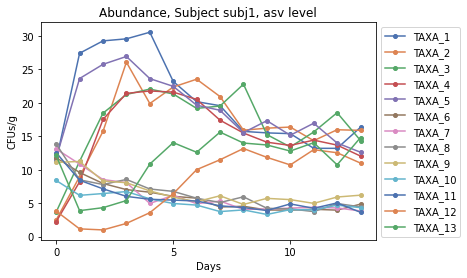

In [45]:
# Make the dynamics
syn = md2.Synthetic(name='icml', seed=0)
syn.icml_dynamics(n_taxa=13)

md2.visualization.render_interaction_strength(
    syn.model.interactions, log_scale=False, taxa=syn.taxa,
    center_colors=True)

# Set the number of subjects
syn.set_subjects(['subj{}'.format(i+1) for i in range(4)])
syn.subjs

# Set the timepoints
syn.set_timepoints(times=np.arange(14))
syn.times

# Forward simulate
pv = md2.model.MultiplicativeGlobal(0.05**2) # 5% process variation
syn.generate_trajectories(dt=0.01, init_dist=md2.variables.Uniform(low=2, high=15),
                          processvar=pv)

# Plot the data without measurement noise
fig = plt.figure()
ax = fig.add_subplot(111)
for taxon in range(13):
    ax.plot(syn.times, syn._data['subj1'][taxon, :], label=syn.taxa[taxon].name)
ax.legend(bbox_to_anchor=(1.05, 1))
ax.set_ylabel('CFUs/g')
ax.set_xlabel('Days')

# Make a study object and simulate measurement noise
study = syn.simulateMeasurementNoise(
    a0=1e-10, a1=0.01, qpcr_noise_scale=0.05, approx_read_depth=60000, 
    name='sim-study')

print(len(study.taxa))
print(len(study))
      

# Visualize with noise
md2.visualization.abundance_over_time(study['subj1'], dtype='abs', yscale_log=False)

In [46]:
# Inference with the ICML dataset
params = md2.config.MDSINE2ModelConfig(
    basepath='output/mdsine2', seed=82, burnin=100, n_samples=200, 
    checkpoint=100, negbin_a0=1e-10, negbin_a1=0.01)

params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value_option'] = 'no-clusters'
mcmc = md2.initialize_graph(params=params, graph_name='icml-graph', subjset=study)

clustering = mcmc.graph[STRNAMES.CLUSTERING_OBJ]
print(clustering.coclusters.value.shape)
print(len(clustering))

mcmc = md2.run_graph(mcmc, crash_if_error=True)


INFO:base.2727: max_value found: 177.00182255728237, scaling_factor: 0.5649659339956085
INFO:run.87: Normalizing abundances for a max value of 100. Normalization constant: 5.6497E-01
INFO:run.254: There are 56 qPCR measurements for 3 buckets. Each bucket is 18 measurements long
INFO:run.289: Initializing Filtering
INFO:posterior.2670: Setting up the essential timepoints
INFO:posterior.2683: Essential timepoints: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
INFO:run.289: Initializing Zero inflation
INFO:design_matrices.851: Initializing LHS vector
INFO:design_matrices.1006: Initializing growth design matrix
INFO:design_matrices.932: Initializing self-interactions design matrix
INFO:run.289: Initializing Clustering concentration parameter
INFO:posterior.875: Cluster Concentration initialization results:
	prior shape: 1e-05
	prior scale: 100000.0
	value: 1.0
INFO:run.289: Initializing Clustering parameter
INFO:posterior.1239: Cluster Assingments initialization results:
Clustering object (c

INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.24666224 0.7802734  0.4583899  0.73850432 0.34636934 0.0908845  0.04197426 0.0717127  0.07297758 0.05960865 0.11898436 0.24239406 0.17607867]
Self Interactions:
[0.02502993 0.08431166 0.04936789 0.08007334 0.03666027 0.04964371 0.03572621 0.04062178 0.03769423 0.0387381  0.05590746 0.03269711 0.02344336]
Interactions:
[]
Perturbations:
None
INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 0
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: 1
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: 0.038738095622392936
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 15.006400524496641
INFO:inference.456: Process Variance parameter: NA
INFO:inference.456: Filtering: parallel
INFO:inference.456: Clustering paramete

(13, 13)
13


INFO:inference.447: 

Inference iteration 3/200, time: 0.0900263786315918
INFO:inference.456: Cluster interaction indicator parameter: [False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False 

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -2.0488518009277117
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.0234935534556722, Acceptance rate: 0.8
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.028504776479755106, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 0.03906604779885836
INFO:inference.456: Process Variance parameter: 0.01375647913513906, empirical_variance: 0.01415
INFO:inference.456: Filtering: no-mp - Time: 0.0320, Acc: [0.181, 0.176, 0.231, 0.159], data/sec: 22774.39
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 11
Cluster 100118
	members: ['TAXA_2', 'TAXA_3']
	size: 2
Cluster 100128
	members: ['TAXA_8']
	size: 1
Cluster 100131
	members: ['TAXA_5', 'TAXA_12']
	size: 2
Clust

INFO:inference.456: Cluster interaction probability: 0.0015703703502623467
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.2685792  0.79539126 0.49442741 0.739775   0.3052205  0.07929022 0.08284289 0.12542287 0.10490917 0.11017671 0.15681228 0.27498228 0.16821498]
Self Interactions:
[0.03013131 0.08824461 0.05456554 0.07809413 0.03078972 0.0476674  0.04626174 0.04814865 0.05269066 0.05040884 0.06917322 0.04080161 0.02040885]
Interactions:
[]
Perturbations:
None
INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 8.80498065031265
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.2934278066703272, Acceptance rate: 0.875
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.021472042970877608, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the inter

INFO:inference.456: Cluster interaction probability: 0.003814120262250449
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.35144177 0.79362173 0.5539726  0.73385236 0.29109012 0.12564809 0.02237618 0.17242635 0.12930189 0.1036468  0.14114154 0.25713788 0.11301568]
Self Interactions:
[0.03458087 0.0868614  0.06086208 0.07851045 0.02744794 0.06186234 0.0283424  0.07273032 0.06058595 0.04962348 0.06911753 0.0374524  0.01105233]
Interactions:
[]
Perturbations:
None
INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 3.710848279454846
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.9189901806479055, Acceptance rate: 0.9090909090909091
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.004198153542825336, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 0.11486188639808652
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.1888162331572951, Acceptance rate: 0.9285714285714286
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.012574677871934722, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 0.5834865236879926
INFO:inference.456: Process Variance parameter: 0.02361044233494713, empirical_variance: 0.02271
INFO:inference.456: Filtering: no-mp - Time: 0.0370, Acc: [0.214, 0.225, 0.264, 0.236], data/sec: 19659.37
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 8
Cluster 100151
	members: ['TAXA_3']
	size: 1
Cluster 100152
	members: ['TAXA_2']
	size: 1
Cluster 100155
	members: ['TAXA_5']
	size: 1
Cluster 10016

INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 0.02515466827378517
INFO:inference.456: Process Variance parameter: 0.022453101868526164, empirical_variance: 0.02322
INFO:inference.456: Filtering: no-mp - Time: 0.0370, Acc: [0.247, 0.220, 0.192, 0.247], data/sec: 19671.52
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 8
Cluster 100155
	members: ['TAXA_2', 'TAXA_6', 'TAXA_5']
	size: 3
Cluster 100164
	members: ['TAXA_11']
	size: 1
Cluster 100170
	members: ['TAXA_8', 'TAXA_9']
	size: 2
Cluster 100180
	members: ['TAXA_12']
	size: 1
Cluster 100182
	members: ['TAXA_3']
	size: 1
Cluster 100185
	members: ['TAXA_4', 'TAXA_7']
	size: 2
Cluster 100187
	members: ['TAXA_1', 'TAXA_13']
	size: 2
Cluster 100191
	members: ['TAXA_10']
	size: 1
no mp - Total time: 0.18296313285827637
INFO:inference.456: Clustering concentration parameter: 8.885550142055658
INFO:inference.447: 

Inferen

INFO:inference.456: Clustering concentration parameter: 4.009260609755958
INFO:posterior.1585: 0/13: 12
INFO:posterior.1585: 1/13: 1
INFO:posterior.1585: 2/13: 10
INFO:posterior.1585: 3/13: 6
INFO:posterior.1585: 4/13: 3
INFO:posterior.1585: 5/13: 7
INFO:posterior.1585: 6/13: 0
INFO:posterior.1585: 7/13: 9
INFO:posterior.1585: 8/13: 4
INFO:posterior.1585: 9/13: 2
INFO:posterior.1585: 10/13: 8
INFO:posterior.1585: 11/13: 11
INFO:posterior.1585: 12/13: 5
INFO:inference.447: 

Inference iteration 21/200, time: 0.225999116897583
INFO:inference.456: Cluster interaction indicator parameter: [False  True False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False]
total time: 0.014002084732055664, n_interactions: 2/56, 0.04
INFO:infe

INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 0.07483241270935141
INFO:inference.456: Process Variance parameter: 0.016468999368674228, empirical_variance: 0.01590
INFO:inference.456: Filtering: no-mp - Time: 0.0340, Acc: [0.214, 0.154, 0.181, 0.176], data/sec: 21413.92
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 4
Cluster 100155
	members: ['TAXA_2', 'TAXA_4', 'TAXA_1', 'TAXA_5', 'TAXA_3']
	size: 5
Cluster 100170
	members: ['TAXA_8', 'TAXA_9', 'TAXA_6']
	size: 3
Cluster 100180
	members: ['TAXA_11', 'TAXA_7']
	size: 2
Cluster 100187
	members: ['TAXA_13', 'TAXA_10', 'TAXA_12']
	size: 3
no mp - Total time: 0.15297198295593262
INFO:inference.456: Clustering concentration parameter: 1.9093580962419499
INFO:posterior.1585: 0/13: 12
INFO:posterior.1585: 1/13: 7
INFO:posterior.1585: 2/13: 0
INFO:posterior.1585: 3/13: 9
INFO:posterior.1585: 4/13: 11
INFO:posterior.1585: 

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 0.01848936544639402
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.0751727870084795, Acceptance rate: 0.9285714285714286
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.026184089788215494, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 0.035363629846181154
INFO:inference.456: Process Variance parameter: 0.012989314900054293, empirical_variance: 0.01279
INFO:inference.456: Filtering: no-mp - Time: 0.0357, Acc: [0.198, 0.247, 0.203, 0.231], data/sec: 20406.28
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 4
Cluster 100155
	members: ['TAXA_1', 'TAXA_4', 'TAXA_5', 'TAXA_2', 'TAXA_3']
	size: 5
Cluster 100170
	members: ['TAXA_8', 'TAXA_9', 'TAXA_6']
	siz

INFO:inference.456: Cluster interaction probability: 0.07588495668494448
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.38314344 0.45231166 0.56918305 0.70795426 0.35732396 0.16948916 0.01987171 0.09609127 0.15669552 0.14612904 0.20437464 0.10082661 0.08464645]
Self Interactions:
[0.05199659 0.05719594 0.07100418 0.08722455 0.04860767 0.07662725 0.03270918 0.05494601 0.05254023 0.06886793 0.09542458 0.04792698 0.03854588]
Interactions:
[ 0.02685082 -0.01864799  0.01327856 -0.03682193]
Perturbations:
None
INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -0.06873020642026349
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.6442213939303625, Acceptance rate: 0.9375
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.03897101686239568, Acceptance rate: 1.0
INFO:inference.456: Var

INFO:inference.456: Clustering concentration parameter: 0.03635434020763146
INFO:inference.447: 

Inference iteration 36/200, time: 0.07004451751708984
INFO:inference.456: Cluster interaction indicator parameter: [ True  True False False  True  True]
total time: 0.004000425338745117, n_interactions: 4/6, 0.67
INFO:inference.456: Cluster interaction probability: 0.4845109267971034
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[4.11286891e-01 5.37659317e-01 6.31296769e-01 6.99696506e-01 4.09731148e-01 1.63676624e-01 1.23694015e-01 4.95784024e-02 1.15029670e-01 1.84469664e-01 2.21335443e-01 5.89115176e-02 3.99410961e-04]
Self Interactions:
[0.05183003 0.0619768  0.08051326 0.08619413 0.05252473 0.07417447 0.05574697 0.03296819 0.05217356 0.08963237 0.10358543 0.05032069 0.03612705]
Interactions:
[ 0.01621785 -0.01769546  0.0149138  -0.02356259]
Perturbations:
None
INFO:inference.456: Mean parameter for the normal prior of t

INFO:inference.456: Filtering: no-mp - Time: 0.0360, Acc: [0.225, 0.181, 0.203, 0.159], data/sec: 20234.28
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 4
Cluster 100155
	members: ['TAXA_2', 'TAXA_5', 'TAXA_1', 'TAXA_3', 'TAXA_4']
	size: 5
Cluster 100180
	members: ['TAXA_9', 'TAXA_6', 'TAXA_10', 'TAXA_8', 'TAXA_11']
	size: 5
Cluster 100187
	members: ['TAXA_12', 'TAXA_13']
	size: 2
Cluster 100256
	members: ['TAXA_7']
	size: 1
no mp - Total time: 0.11996293067932129
INFO:inference.456: Clustering concentration parameter: 1.1826124524038883
INFO:inference.447: 

Inference iteration 40/200, time: 0.07303261756896973
INFO:inference.456: Cluster interaction indicator parameter: [ True  True False False False False  True  True False False False False]
total time: 0.0060007572174072266, n_interactions: 4/12, 0.33
INFO:inference.456: Cluster interaction probability: 0.26176611781871956
INFO:inference.456: Logistic g

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 0.07677449224428137
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.1685902844881886, Acceptance rate: 0.9534883720930233
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.0348599363323047, Acceptance rate: 0.9767441860465116
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 0.03449259279968265
INFO:inference.456: Process Variance parameter: 0.007535812440617654, empirical_variance: 0.00723
INFO:inference.456: Filtering: no-mp - Time: 0.0380, Acc: [0.143, 0.143, 0.203, 0.225], data/sec: 19153.39
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 5
Cluster 100155
	members: ['TAXA_1', 'TAXA_4', 'TAXA_2', 'TAXA_5', 'TAXA_3']
	size: 5
Cluster 100180
	members: ['TAXA_6', 'TAXA_8', 'T

INFO:inference.456: Clustering concentration parameter: 2.04886902410778
INFO:inference.447: 

Inference iteration 47/200, time: 0.06996917724609375
INFO:inference.456: Cluster interaction indicator parameter: [ True  True False False False False False False  True  True False False False False False False False False False False]
total time: 0.009975433349609375, n_interactions: 4/20, 0.20
INFO:inference.456: Cluster interaction probability: 0.2154712836772154
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.39495707 0.45442053 0.59412274 0.70085023 0.49754663 0.13586819 0.11597966 0.0282479  0.10015377 0.16960847 0.26490915 0.07098603 0.00900414]
Self Interactions:
[0.04833077 0.05490856 0.07503346 0.0857979  0.06142743 0.06654986 0.05570571 0.03443462 0.04664536 0.07770245 0.11905795 0.06556155 0.05288651]
Interactions:
[ 0.03646724 -0.01962549  0.01619354 -0.04463745]
Perturbations:
None
INFO:inference.456: Mean param

INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 0.07974139288419288
INFO:inference.456: Process Variance parameter: 0.006269545848708902, empirical_variance: 0.00648
INFO:inference.456: Filtering: no-mp - Time: 0.0350, Acc: [0.170, 0.159, 0.209, 0.181], data/sec: 20796.83
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 4
Cluster 100155
	members: ['TAXA_3', 'TAXA_4', 'TAXA_5', 'TAXA_2', 'TAXA_1']
	size: 5
Cluster 100180
	members: ['TAXA_9', 'TAXA_6', 'TAXA_8']
	size: 3
Cluster 100187
	members: ['TAXA_13', 'TAXA_12']
	size: 2
Cluster 100278
	members: ['TAXA_11', 'TAXA_10', 'TAXA_7']
	size: 3
no mp - Total time: 0.12596845626831055
INFO:inference.456: Clustering concentration parameter: 1.8363137985250997
INFO:inference.447: 

Inference iteration 51/200, time: 0.06996750831604004
INFO:inference.456: Cluster interaction indicator parameter: [ True  True False False False 

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 0.006619035154613923
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.35151595954811266, Acceptance rate: 0.98
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.01801772889349726, Acceptance rate: 0.98
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 0.009535586657271874
INFO:inference.456: Process Variance parameter: 0.00610643602443312, empirical_variance: 0.00584
INFO:inference.456: Filtering: no-mp - Time: 0.0370, Acc: [0.225, 0.154, 0.264, 0.187], data/sec: 19657.97
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 4
Cluster 100155
	members: ['TAXA_3', 'TAXA_5', 'TAXA_1', 'TAXA_4', 'TAXA_2']
	size: 5
Cluster 100180
	members: ['TAXA_6', 'TAXA_9', 'TAXA_8']
	size: 3
Cluster 

INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.37932017 0.3833341  0.53570078 0.6503327  0.45998826 0.0839753  0.098874   0.11488451 0.09688541 0.14080578 0.2677879  0.07487825 0.10633171]
Self Interactions:
[0.05124144 0.05371714 0.07439279 0.08314064 0.0616746  0.04888223 0.05551188 0.0637778  0.05101851 0.07099094 0.11804286 0.05620686 0.0576122 ]
Interactions:
[ 0.03084501 -0.01895181  0.01578692 -0.03885875]
Perturbations:
None
INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 0.03148860315218271
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.07931181531579395, Acceptance rate: 0.98
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.04341270165817508, Acceptance rate: 0.98
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 0.01413

INFO:inference.456: Clustering concentration parameter: 2.5883553639676764
INFO:inference.447: 

Inference iteration 62/200, time: 0.06399726867675781
INFO:inference.456: Cluster interaction indicator parameter: [ True  True  True False False False  True  True False False False False]
total time: 0.007033586502075195, n_interactions: 5/12, 0.42
INFO:inference.456: Cluster interaction probability: 0.2364192506728105
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.38862083 0.40306488 0.57101584 0.65939909 0.46414026 0.09414509 0.15958756 0.14677191 0.09103718 0.15071693 0.24553753 0.09184426 0.14686753]
Self Interactions:
[0.05248096 0.05142406 0.07516343 0.08252748 0.0610654  0.05640094 0.0687848  0.07040898 0.04830167 0.06559146 0.10432625 0.06124229 0.06934206]
Interactions:
[ 0.03980482 -0.01892025 -0.01831589  0.01523457 -0.03597916]
Perturbations:
None
INFO:inference.456: Mean parameter for the normal prior of the i

INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 4
Cluster 100155
	members: ['TAXA_3', 'TAXA_4', 'TAXA_2', 'TAXA_1', 'TAXA_5']
	size: 5
Cluster 100180
	members: ['TAXA_6', 'TAXA_9', 'TAXA_8']
	size: 3
Cluster 100187
	members: ['TAXA_12', 'TAXA_13']
	size: 2
Cluster 100278
	members: ['TAXA_11', 'TAXA_7', 'TAXA_10']
	size: 3
no mp - Total time: 0.1320343017578125
INFO:inference.456: Clustering concentration parameter: 3.9496985628773604
INFO:inference.447: 

Inference iteration 66/200, time: 0.06396842002868652
INFO:inference.456: Cluster interaction indicator parameter: [ True  True False False False False  True  True  True False False False]
total time: 0.00800180435180664, n_interactions: 5/12, 0.42
INFO:inference.456: Cluster interaction probability: 0.5089876351173297
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.35524352 0.37368208 0.5542

INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.1309792525854367, Acceptance rate: 0.98
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 0.07285611899861347
INFO:inference.456: Process Variance parameter: 0.0061754036130724594, empirical_variance: 0.00588
INFO:inference.456: Filtering: no-mp - Time: 0.0360, Acc: [0.170, 0.176, 0.214, 0.170], data/sec: 20222.08
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 4
Cluster 100155
	members: ['TAXA_3', 'TAXA_5', 'TAXA_2', 'TAXA_1', 'TAXA_4']
	size: 5
Cluster 100180
	members: ['TAXA_9', 'TAXA_8', 'TAXA_6']
	size: 3
Cluster 100187
	members: ['TAXA_12', 'TAXA_13']
	size: 2
Cluster 100278
	members: ['TAXA_10', 'TAXA_7', 'TAXA_11']
	size: 3
no mp - Total time: 0.15401434898376465
INFO:inference.456: Clustering concentration parameter: 1.1204418197555925
INFO:inference.44

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 0.0598941959552142
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.6564973238615885, Acceptance rate: 1.0
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.10857280530264646, Acceptance rate: 0.98
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 0.06944030178108952
INFO:inference.456: Process Variance parameter: 0.005868180335168377, empirical_variance: 0.00574
INFO:inference.456: Filtering: no-mp - Time: 0.0370, Acc: [0.198, 0.181, 0.165, 0.181], data/sec: 19660.12
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 5
Cluster 100155
	members: ['TAXA_5', 'TAXA_2', 'TAXA_3', 'TAXA_4', 'TAXA_1']
	size: 5
Cluster 100180
	members: ['TAXA_8', 'TAXA_9', 'TAXA_6']
	size: 3
Cluster 1001

INFO:inference.456: Cluster interaction indicator parameter: [ True  True False False False False False False  True  True False False False False False False False False False False]
total time: 0.00799870491027832, n_interactions: 4/20, 0.20
INFO:inference.456: Cluster interaction probability: 0.19288098076084031
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.33725414 0.37339182 0.5013027  0.64595989 0.43044005 0.16901371 0.03646009 0.08266288 0.08298736 0.15091422 0.21197968 0.15249436 0.15510574]
Self Interactions:
[0.04817684 0.05419515 0.06791236 0.08282166 0.06181783 0.07764954 0.04423749 0.05080737 0.04316934 0.07272001 0.08523804 0.06850027 0.06377001]
Interactions:
[ 0.03668174 -0.01549474  0.01639553 -0.05217998]
Perturbations:
None
INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 0.030569791513586148
INFO:inference.456: Mean parameter for the truncated normal prior of the

INFO:inference.456: Clustering concentration parameter: 6.780739528542406
INFO:posterior.1585: 0/13: 8
INFO:posterior.1585: 1/13: 4
INFO:posterior.1585: 2/13: 10
INFO:posterior.1585: 3/13: 2
INFO:posterior.1585: 4/13: 7
INFO:posterior.1585: 5/13: 3
INFO:posterior.1585: 6/13: 5
INFO:posterior.1585: 7/13: 0
INFO:posterior.1585: 8/13: 6
INFO:posterior.1585: 9/13: 1
INFO:posterior.1585: 10/13: 9
INFO:posterior.1585: 11/13: 11
INFO:posterior.1585: 12/13: 12
INFO:inference.447: 

Inference iteration 81/200, time: 0.21454930305480957
INFO:inference.456: Cluster interaction indicator parameter: [ True  True False False False False False False  True  True False False False False False False False False False False]
total time: 0.007996082305908203, n_interactions: 4/20, 0.20
INFO:inference.456: Cluster interaction probability: 0.2640954132230204
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.35921253 0.38995156 0.508362   0.673

INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.7144959883929789, Acceptance rate: 0.98
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.02838936616708634, Acceptance rate: 0.98
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 0.03521480994528605
INFO:inference.456: Process Variance parameter: 0.004762745901908468, empirical_variance: 0.00506
INFO:inference.456: Filtering: no-mp - Time: 0.0400, Acc: [0.165, 0.198, 0.165, 0.165], data/sec: 18204.90
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 6
Cluster 100155
	members: ['TAXA_5', 'TAXA_3', 'TAXA_4', 'TAXA_1', 'TAXA_2']
	size: 5
Cluster 100180
	members: ['TAXA_9', 'TAXA_8', 'TAXA_6']
	size: 3
Cluster 100187
	members: ['TAXA_12', 'TAXA_13']
	size: 2
Cluster 100391
	members: ['TAXA_11']
	size: 1
Cluster 10039

INFO:inference.456: Cluster interaction indicator parameter: [ True  True False False False False False False  True  True False False False False False False False False False False]
total time: 0.010969161987304688, n_interactions: 4/20, 0.20
INFO:inference.456: Cluster interaction probability: 0.2506346209317504
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.35988942 0.38754746 0.50322379 0.70902775 0.46269124 0.10750533 0.08819834 0.09886916 0.09612244 0.15210038 0.1844274  0.12384999 0.17442582]
Self Interactions:
[0.05098361 0.05068425 0.06620666 0.0897977  0.06387686 0.05431194 0.04611576 0.04785393 0.04276222 0.06986899 0.08076573 0.07053911 0.06942102]
Interactions:
[ 0.03536049 -0.01667524  0.01630986 -0.0527291 ]
Perturbations:
None
INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 0.10472687941370919
INFO:inference.456: Mean parameter for the truncated normal prior of the 

INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 0.04839439416479825
INFO:inference.456: Process Variance parameter: 0.00497567310368281, empirical_variance: 0.00471
INFO:inference.456: Filtering: no-mp - Time: 0.0400, Acc: [0.187, 0.181, 0.148, 0.170], data/sec: 18203.06
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 6
Cluster 100155
	members: ['TAXA_4', 'TAXA_5', 'TAXA_2', 'TAXA_3', 'TAXA_1']
	size: 5
Cluster 100180
	members: ['TAXA_8', 'TAXA_6', 'TAXA_9']
	size: 3
Cluster 100187
	members: ['TAXA_13', 'TAXA_12']
	size: 2
Cluster 100403
	members: ['TAXA_7']
	size: 1
Cluster 100421
	members: ['TAXA_11']
	size: 1
Cluster 100430
	members: ['TAXA_10']
	size: 1
no mp - Total time: 0.14300107955932617
INFO:inference.456: Clustering concentration parameter: 6.784684296252078
INFO:inference.447: 

Inference iteration 92/200, time: 0.06897187232971191
INFO:inference.456: Clus

INFO:inference.456: Cluster interaction probability: 0.06124589043737206
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.35020097 0.42254702 0.47384575 0.65876327 0.47647154 0.06609365 0.13450905 0.07549503 0.04853239 0.1221324  0.21712263 0.15412499 0.14904466]
Self Interactions:
[0.05165503 0.05571713 0.0659633  0.08555095 0.06503374 0.04895585 0.06135149 0.05535891 0.0362898  0.05659772 0.09250812 0.07458174 0.06676616]
Interactions:
[ 0.03731073 -0.01710924  0.00980308  0.01731955 -0.05726759]
Perturbations:
None
INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -0.0860694737709011
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 2.1213385529743216, Acceptance rate: 0.96
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.026123052937052638, Acceptance rate: 0.96
INFO:inferen

INFO:inference.456: Process Variance parameter: 0.00440158779553477, empirical_variance: 0.00489
INFO:inference.456: Filtering: no-mp - Time: 0.0390, Acc: [0.236, 0.148, 0.225, 0.198], data/sec: 18680.35
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 6
Cluster 100155
	members: ['TAXA_2', 'TAXA_1', 'TAXA_3', 'TAXA_5', 'TAXA_4']
	size: 5
Cluster 100180
	members: ['TAXA_8', 'TAXA_9', 'TAXA_6']
	size: 3
Cluster 100187
	members: ['TAXA_12', 'TAXA_13']
	size: 2
Cluster 100447
	members: ['TAXA_7']
	size: 1
Cluster 100454
	members: ['TAXA_10']
	size: 1
Cluster 100458
	members: ['TAXA_11']
	size: 1
no mp - Total time: 0.15399932861328125
INFO:inference.456: Clustering concentration parameter: 8.85359904716403
INFO:inference.447: 

Inference iteration 99/200, time: 0.06799626350402832
INFO:inference.456: Cluster interaction indicator parameter: [ True  True False False False False False False  True False  True  True F

INFO:inference.456: Cluster interaction probability: 0.16997198259038268
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.40529221 0.43196571 0.52740047 0.62188288 0.3973505  0.10259474 0.16629852 0.08957704 0.06400586 0.13574322 0.19740127 0.1615547  0.13397403]
Self Interactions:
[0.05487138 0.05539997 0.06999037 0.0840656  0.05742415 0.05773899 0.06366563 0.05169573 0.03769447 0.06161633 0.08726196 0.07409449 0.06221448]
Interactions:
[ 0.0363616  -0.01662232  0.01728472 -0.05742754]
Perturbations:
None
INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 0.0130885963697925
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.017168589851151217, Acceptance rate: 0.96
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.08915115731325478, Acceptance rate: 0.96
INFO:inference.456: Vari

INFO:inference.456: Clustering concentration parameter: 2.0777637936546967
INFO:inference.447: 

Inference iteration 106/200, time: 0.06497979164123535
INFO:inference.456: Cluster interaction indicator parameter: [ True  True False False False False False False  True  True False False False False False False False False False False]
total time: 0.00803375244140625, n_interactions: 4/20, 0.20
INFO:inference.456: Cluster interaction probability: 0.28552948172978776
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.40405106 0.39496307 0.50758151 0.66831891 0.43819187 0.10728382 0.12128358 0.10096759 0.02785479 0.14695977 0.19850342 0.12856869 0.16777978]
Self Interactions:
[0.05243481 0.04912863 0.06574618 0.08062942 0.05869218 0.05783823 0.06445415 0.04695036 0.02701391 0.06226203 0.08384968 0.06267882 0.06421042]
Interactions:
[ 0.03529688 -0.01878325  0.01619811 -0.05470065]
Perturbations:
None
INFO:inference.456: Mean pa

INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 0.04374514332824997
INFO:inference.456: Process Variance parameter: 0.00499306860400196, empirical_variance: 0.00480
INFO:inference.456: Filtering: no-mp - Time: 0.0350, Acc: [0.209, 0.121, 0.176, 0.181], data/sec: 20800.52
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 4
Cluster 100155
	members: ['TAXA_4', 'TAXA_1', 'TAXA_5', 'TAXA_2', 'TAXA_3']
	size: 5
Cluster 100180
	members: ['TAXA_9', 'TAXA_6', 'TAXA_8']
	size: 3
Cluster 100187
	members: ['TAXA_13', 'TAXA_12']
	size: 2
Cluster 100489
	members: ['TAXA_11', 'TAXA_10', 'TAXA_7']
	size: 3
no mp - Total time: 0.13602089881896973
INFO:inference.456: Clustering concentration parameter: 1.4836391972612257
INFO:inference.447: 

Inference iteration 110/200, time: 0.06597638130187988
INFO:inference.456: Cluster interaction indicator parameter: [ True  True False False False 

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 0.05337942002086501
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.668497046441328, Acceptance rate: 0.94
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.09443908596013839, Acceptance rate: 0.94
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 0.012394763802623662
INFO:inference.456: Process Variance parameter: 0.005217002994045037, empirical_variance: 0.00496
INFO:inference.456: Filtering: no-mp - Time: 0.0350, Acc: [0.209, 0.181, 0.187, 0.187], data/sec: 20800.80
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 4
Cluster 100155
	members: ['TAXA_4', 'TAXA_2', 'TAXA_1', 'TAXA_5', 'TAXA_3']
	size: 5
Cluster 100180
	members: ['TAXA_8', 'TAXA_6', 'TAXA_9']
	size: 3
Cluster 10

INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.37115668 0.45247115 0.47287534 0.59249012 0.480315   0.1198674  0.12776615 0.08599648 0.10004424 0.12453533 0.19842367 0.09000591 0.17253064]
Self Interactions:
[0.05155189 0.05757799 0.06411413 0.07665704 0.06607491 0.06277585 0.0575174  0.04392198 0.0482616  0.06780343 0.0836029  0.06126374 0.06884976]
Interactions:
[ 0.0352187  -0.0162844   0.01624795 -0.0528817  -0.00019313]
Perturbations:
None
INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 0.15839554488178662
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.08356757576125, Acceptance rate: 0.94
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.13459945237183646, Acceptance rate: 0.94
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter

INFO:inference.456: Clustering concentration parameter: 4.389977735093014
INFO:posterior.1585: 0/13: 1
INFO:posterior.1585: 1/13: 9
INFO:posterior.1585: 2/13: 4
INFO:posterior.1585: 3/13: 8
INFO:posterior.1585: 4/13: 10
INFO:posterior.1585: 5/13: 3
INFO:posterior.1585: 6/13: 5
INFO:posterior.1585: 7/13: 6
INFO:posterior.1585: 8/13: 11
INFO:posterior.1585: 9/13: 12
INFO:posterior.1585: 10/13: 0
INFO:posterior.1585: 11/13: 7
INFO:posterior.1585: 12/13: 2
INFO:inference.447: 

Inference iteration 121/200, time: 0.21901202201843262
INFO:inference.456: Cluster interaction indicator parameter: [ True  True False False False False False False False False  True  True False False False False False False False False False False False False False False False False False False]
total time: 0.009997367858886719, n_interactions: 4/30, 0.13
INFO:inference.456: Cluster interaction probability: 0.16638181596288257
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/p

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -0.07020772548500787
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.6960340581224446, Acceptance rate: 0.94
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.1363636212754012, Acceptance rate: 0.94
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 0.03488490945283021
INFO:inference.456: Process Variance parameter: 0.005037518890878195, empirical_variance: 0.00495
INFO:inference.456: Filtering: no-mp - Time: 0.0390, Acc: [0.192, 0.148, 0.214, 0.181], data/sec: 18668.82
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 6
Cluster 100155
	members: ['TAXA_2', 'TAXA_5', 'TAXA_4', 'TAXA_1', 'TAXA_3']
	size: 5
Cluster 100180
	members: ['TAXA_9', 'TAXA_6', 'TAXA_8']
	size: 3
Cluster 10

INFO:inference.456: Clustering concentration parameter: 5.658320449433424
INFO:inference.447: 

Inference iteration 128/200, time: 0.06802892684936523
INFO:inference.456: Cluster interaction indicator parameter: [ True  True False False False False False False False False  True  True False False False False False False False False False False False False False False False False False False]
total time: 0.010000228881835938, n_interactions: 4/30, 0.13
INFO:inference.456: Cluster interaction probability: 0.15685110131624685
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.31920027 0.48567584 0.48726903 0.60477511 0.44811835 0.07366179 0.09855627 0.03507955 0.10808064 0.12234555 0.21078709 0.09930991 0.07592864]
Self Interactions:
[0.04655588 0.0630619  0.06407467 0.07562133 0.06194878 0.04333782 0.05211759 0.03273476 0.04340199 0.06369266 0.09923455 0.06522467 0.06013592]
Interactions:
[ 0.03723898 -0.01762337  0.01698233 

INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.8836867048367798, Acceptance rate: 0.96
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.1273905054897165, Acceptance rate: 0.96
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 0.031248176047144166
INFO:inference.456: Process Variance parameter: 0.005455695451196417, empirical_variance: 0.00521
INFO:inference.456: Filtering: no-mp - Time: 0.0390, Acc: [0.148, 0.170, 0.181, 0.132], data/sec: 18668.02
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 6
Cluster 100155
	members: ['TAXA_5', 'TAXA_3', 'TAXA_1', 'TAXA_2', 'TAXA_4']
	size: 5
Cluster 100180
	members: ['TAXA_6', 'TAXA_8', 'TAXA_9']
	size: 3
Cluster 100187
	members: ['TAXA_12', 'TAXA_13']
	size: 2
Cluster 100555
	members: ['TAXA_10']
	size: 1
Cluster 10055

INFO:inference.456: Clustering concentration parameter: 8.943982331253865
INFO:inference.447: 

Inference iteration 135/200, time: 0.06399893760681152
INFO:inference.456: Cluster interaction indicator parameter: [ True  True False False False False False False False False  True  True False False False False False False False False False False False False False False False False False False]
total time: 0.009035587310791016, n_interactions: 4/30, 0.13
INFO:inference.456: Cluster interaction probability: 0.06281248771307225
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.28489996 0.44783294 0.44066095 0.62207113 0.41618703 0.13217571 0.06059006 0.13084239 0.07194206 0.09616782 0.1883106  0.07896006 0.07072996]
Self Interactions:
[0.0470923  0.06226336 0.06632572 0.08166525 0.06390169 0.06925829 0.04077398 0.06127157 0.03228715 0.04806352 0.08209845 0.06988719 0.06714816]
Interactions:
[ 0.0363795  -0.01335939  0.01782328 

INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.219657582580307, Acceptance rate: 0.98
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.0752432964112521, Acceptance rate: 0.96
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 0.0158935684723938
INFO:inference.456: Process Variance parameter: 0.005462099647850263, empirical_variance: 0.00502
INFO:inference.456: Filtering: no-mp - Time: 0.0360, Acc: [0.165, 0.176, 0.236, 0.170], data/sec: 20221.55
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 5
Cluster 100155
	members: ['TAXA_1', 'TAXA_3', 'TAXA_4', 'TAXA_2', 'TAXA_5']
	size: 5
Cluster 100180
	members: ['TAXA_8', 'TAXA_9', 'TAXA_6']
	size: 3
Cluster 100187
	members: ['TAXA_13', 'TAXA_12']
	size: 2
Cluster 100583
	members: ['TAXA_10']
	size: 1
Cluster 100588
	

INFO:inference.456: Cluster interaction probability: 0.03678081347356756
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.31291329 0.48221388 0.43712397 0.6027846  0.37996831 0.10627909 0.0427133  0.11360967 0.08745261 0.02966376 0.17729625 0.06452315 0.07292714]
Self Interactions:
[0.04905968 0.06633098 0.06363274 0.07741473 0.05779225 0.05953103 0.03730795 0.05839786 0.03751824 0.03482769 0.07717334 0.06512376 0.06745192]
Interactions:
[ 0.03932093 -0.01604297  0.0185602  -0.05499085]
Perturbations:
None
INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 0.010429380759050347
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 2.278479184399892, Acceptance rate: 0.98
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.12829551831438687, Acceptance rate: 0.96
INFO:inference.456: Varia

INFO:inference.456: Process Variance parameter: 0.005421035702606721, empirical_variance: 0.00536
INFO:inference.456: Filtering: no-mp - Time: 0.0350, Acc: [0.170, 0.203, 0.181, 0.143], data/sec: 20805.48
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 6
Cluster 100155
	members: ['TAXA_3', 'TAXA_2', 'TAXA_4', 'TAXA_1', 'TAXA_5']
	size: 5
Cluster 100180
	members: ['TAXA_6', 'TAXA_8', 'TAXA_9']
	size: 3
Cluster 100187
	members: ['TAXA_13', 'TAXA_12']
	size: 2
Cluster 100614
	members: ['TAXA_10']
	size: 1
Cluster 100620
	members: ['TAXA_11']
	size: 1
Cluster 100622
	members: ['TAXA_7']
	size: 1
no mp - Total time: 0.15897274017333984
INFO:inference.456: Clustering concentration parameter: 2.400940515251367
INFO:inference.447: 

Inference iteration 146/200, time: 0.06801581382751465
INFO:inference.456: Cluster interaction indicator parameter: [ True  True False False False False False False False False  True  Tru

INFO:inference.456: Cluster interaction probability: 0.06846421887084359
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.31272248 0.47842143 0.42391272 0.52853508 0.35084644 0.16890792 0.04839093 0.15044264 0.08258865 0.13458401 0.17201982 0.00230957 0.09262443]
Self Interactions:
[0.05055051 0.06751839 0.06414925 0.07202917 0.0543873  0.08011385 0.04161883 0.06847139 0.04474005 0.06692369 0.08396655 0.0631579  0.07444663]
Interactions:
[ 0.03937948 -0.0151634   0.01819631 -0.04997741]
Perturbations:
None
INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -0.16566624651970766
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 2.8708011328943144, Acceptance rate: 0.98
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.1933014776535525, Acceptance rate: 0.98
INFO:inference.456: Varia

INFO:inference.456: Clustering concentration parameter: 3.6638899280520585
INFO:posterior.1585: 0/13: 6
INFO:posterior.1585: 1/13: 8
INFO:posterior.1585: 2/13: 4
INFO:posterior.1585: 3/13: 5
INFO:posterior.1585: 4/13: 11
INFO:posterior.1585: 5/13: 1
INFO:posterior.1585: 6/13: 12
INFO:posterior.1585: 7/13: 9
INFO:posterior.1585: 8/13: 0
INFO:posterior.1585: 9/13: 2
INFO:posterior.1585: 10/13: 3
INFO:posterior.1585: 11/13: 7
INFO:posterior.1585: 12/13: 10
INFO:inference.447: 

Inference iteration 153/200, time: 0.2149980068206787
INFO:inference.456: Cluster interaction indicator parameter: [ True  True False False False False False False False False  True  True False False False False False False False False False False False False False False False False False False]
total time: 0.010030031204223633, n_interactions: 4/30, 0.13
INFO:inference.456: Cluster interaction probability: 0.11024437084521924
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/p

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 0.027503729536978817
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.5626155799766575, Acceptance rate: 0.96
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.18879636828647914, Acceptance rate: 0.96
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 0.017611320774260433
INFO:inference.456: Process Variance parameter: 0.005680037831415501, empirical_variance: 0.00495
INFO:inference.456: Filtering: no-mp - Time: 0.0330, Acc: [0.192, 0.143, 0.220, 0.209], data/sec: 22083.43
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 6
Cluster 100155
	members: ['TAXA_5', 'TAXA_2', 'TAXA_1', 'TAXA_3', 'TAXA_4']
	size: 5
Cluster 100180
	members: ['TAXA_9', 'TAXA_6', 'TAXA_8']
	size: 3
Cluster 

INFO:inference.456: Cluster interaction probability: 0.11854059469630293
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.3073238  0.4487719  0.3894574  0.46032204 0.33669366 0.12655335 0.0784831  0.1507004  0.12432067 0.14708514 0.23494425 0.02429879 0.07547704]
Self Interactions:
[0.04726881 0.06422248 0.05734669 0.06408504 0.0526066  0.06750016 0.04422717 0.06782666 0.05456114 0.06773898 0.0902267  0.06634957 0.07034706]
Interactions:
[ 0.03837928 -0.01616869  0.01834276 -0.05134174]
Perturbations:
None
INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -0.01734214595970918
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.47490036131903096, Acceptance rate: 0.96
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.20817546314857013, Acceptance rate: 0.98
INFO:inference.456: Var

INFO:inference.456: Clustering concentration parameter: 2.496247793121149
INFO:inference.447: 

Inference iteration 164/200, time: 0.0650334358215332
INFO:inference.456: Cluster interaction indicator parameter: [ True  True False False False False False False  True  True False False False False False False False False False False]
total time: 0.008995532989501953, n_interactions: 4/20, 0.20
INFO:inference.456: Cluster interaction probability: 0.312066372796825
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.3305184  0.4585669  0.40788828 0.43756288 0.32979378 0.12358796 0.07900972 0.08885153 0.1279282  0.11183804 0.14924484 0.03247083 0.09830793]
Self Interactions:
[0.05305311 0.06609262 0.06055453 0.06280478 0.05394707 0.06249172 0.04494595 0.04769072 0.0572061  0.05766358 0.06886087 0.06299612 0.07287946]
Interactions:
[ 0.03762789 -0.01305407  0.01753525 -0.0493211 ]
Perturbations:
None
INFO:inference.456: Mean param

INFO:inference.456: Process Variance parameter: 0.00459349496816635, empirical_variance: 0.00535
INFO:inference.456: Filtering: no-mp - Time: 0.0350, Acc: [0.176, 0.181, 0.220, 0.203], data/sec: 20799.10
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 4
Cluster 100155
	members: ['TAXA_5', 'TAXA_2', 'TAXA_1', 'TAXA_4', 'TAXA_3']
	size: 5
Cluster 100180
	members: ['TAXA_9', 'TAXA_8', 'TAXA_6']
	size: 3
Cluster 100187
	members: ['TAXA_12', 'TAXA_13']
	size: 2
Cluster 100638
	members: ['TAXA_11', 'TAXA_7', 'TAXA_10']
	size: 3
no mp - Total time: 0.12499737739562988
INFO:inference.456: Clustering concentration parameter: 4.934395769366058
INFO:inference.447: 

Inference iteration 168/200, time: 0.06803655624389648
INFO:inference.456: Cluster interaction indicator parameter: [ True  True False False False False  True  True False False False False]
total time: 0.006030082702636719, n_interactions: 4/12, 0.33
INFO:in

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -0.07675982906640845
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.152983405940906, Acceptance rate: 0.94
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.26754033332828386, Acceptance rate: 0.98
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 0.016188692390545528
INFO:inference.456: Process Variance parameter: 0.005497298288448885, empirical_variance: 0.00532
INFO:inference.456: Filtering: no-mp - Time: 0.0370, Acc: [0.176, 0.148, 0.231, 0.225], data/sec: 19675.83
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 4
Cluster 100155
	members: ['TAXA_2', 'TAXA_5', 'TAXA_4', 'TAXA_3', 'TAXA_1']
	size: 5
Cluster 100180
	members: ['TAXA_8', 'TAXA_6', 'TAXA_9']
	size: 3
Cluster 1

INFO:inference.456: Cluster interaction probability: 0.299320336749494
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.31742065 0.45011286 0.3418106  0.41398113 0.35934892 0.12330421 0.07976268 0.16100578 0.11352381 0.12191132 0.18627784 0.06727893 0.05165829]
Self Interactions:
[0.04936363 0.06330925 0.05658483 0.06108104 0.05745301 0.06541891 0.04768616 0.07108209 0.05351425 0.05603746 0.08237621 0.06807183 0.06394011]
Interactions:
[ 0.03858098 -0.01454048  0.0184859  -0.05451335]
Perturbations:
None
INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 0.06812198746123503
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.20831835287293632, Acceptance rate: 0.94
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.2686997339909992, Acceptance rate: 0.98
INFO:inference.456: Varianc

INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 6
Cluster 100155
	members: ['TAXA_2', 'TAXA_1', 'TAXA_3', 'TAXA_4', 'TAXA_5']
	size: 5
Cluster 100180
	members: ['TAXA_8', 'TAXA_9', 'TAXA_6']
	size: 3
Cluster 100187
	members: ['TAXA_13', 'TAXA_12']
	size: 2
Cluster 100711
	members: ['TAXA_11']
	size: 1
Cluster 100719
	members: ['TAXA_10']
	size: 1
Cluster 100724
	members: ['TAXA_7']
	size: 1
no mp - Total time: 0.1450047492980957
INFO:inference.456: Clustering concentration parameter: 4.519723432486704
INFO:inference.447: 

Inference iteration 179/200, time: 0.06902909278869629
INFO:inference.456: Cluster interaction indicator parameter: [ True  True False False False False False False False False  True  True False False False False False False False False False False False False False False False False False False]
total time: 0.009035587310791016, n_interactions: 4/30, 0.13
INFO:inference.456: Cluster intera

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -0.04910090836790727
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.9775246915958247, Acceptance rate: 0.94
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.36411424848951457, Acceptance rate: 0.98
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 0.050827180564593864
INFO:inference.456: Process Variance parameter: 0.005828030429420813, empirical_variance: 0.00566
INFO:inference.456: Filtering: no-mp - Time: 0.0370, Acc: [0.253, 0.198, 0.231, 0.137], data/sec: 19665.70
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 5
Cluster 100155
	members: ['TAXA_4', 'TAXA_2', 'TAXA_5', 'TAXA_3', 'TAXA_1']
	size: 5
Cluster 100180
	members: ['TAXA_6', 'TAXA_9', 'TAXA_8']
	size: 3
Cluster 

INFO:inference.456: Cluster interaction indicator parameter: [ True  True False False False False False False  True  True False False False False False False False False False False]
total time: 0.009022712707519531, n_interactions: 4/20, 0.20
INFO:inference.456: Cluster interaction probability: 0.15566186238780405
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.34847264 0.46474004 0.35962931 0.43510467 0.37842832 0.11204673 0.07973524 0.14342322 0.11628198 0.14396252 0.18332689 0.02138101 0.01272693]
Self Interactions:
[0.05286265 0.06704717 0.05710891 0.06483815 0.05721612 0.0638595  0.0471415  0.0647297  0.05115049 0.0673553  0.08124626 0.06728724 0.06579175]
Interactions:
[ 0.03740414 -0.01439108  0.01984277 -0.05520972]
Perturbations:
None
INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -0.07912867337371493
INFO:inference.456: Mean parameter for the truncated normal prior of th

INFO:inference.456: Process Variance parameter: 0.006035382649204727, empirical_variance: 0.00562
INFO:inference.456: Filtering: no-mp - Time: 0.0350, Acc: [0.176, 0.192, 0.220, 0.192], data/sec: 20819.66
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 6
Cluster 100155
	members: ['TAXA_4', 'TAXA_1', 'TAXA_5', 'TAXA_3', 'TAXA_2']
	size: 5
Cluster 100180
	members: ['TAXA_8', 'TAXA_6', 'TAXA_9']
	size: 3
Cluster 100187
	members: ['TAXA_12', 'TAXA_13']
	size: 2
Cluster 100751
	members: ['TAXA_7']
	size: 1
Cluster 100764
	members: ['TAXA_11']
	size: 1
Cluster 100770
	members: ['TAXA_10']
	size: 1
no mp - Total time: 0.14300012588500977
INFO:inference.456: Clustering concentration parameter: 4.000335194776374
INFO:inference.447: 

Inference iteration 190/200, time: 0.06403326988220215
INFO:inference.456: Cluster interaction indicator parameter: [ True  True False False False False False False False False  True  Tru

INFO:inference.456: Cluster interaction probability: 0.11561757821707304
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.29879075 0.50270841 0.30011685 0.42340446 0.36950241 0.11333269 0.04577849 0.15555833 0.11444806 0.15043218 0.1957246  0.00829643 0.00612389]
Self Interactions:
[0.05054683 0.06850766 0.05023865 0.06254051 0.05823366 0.05644567 0.04177826 0.06923446 0.05393012 0.06229786 0.08454821 0.06283575 0.06187895]
Interactions:
[ 0.0372937  -0.01382778  0.01915645 -0.05385719]
Perturbations:
None
INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -0.024552688351341747
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.5714819724379325, Acceptance rate: 0.94
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.3706383167076587, Acceptance rate: 0.98
INFO:inference.456: Vari

INFO:inference.456: Clustering concentration parameter: 3.557362599971361
INFO:posterior.1585: 0/13: 7
INFO:posterior.1585: 1/13: 9
INFO:posterior.1585: 2/13: 2
INFO:posterior.1585: 3/13: 1
INFO:posterior.1585: 4/13: 10
INFO:posterior.1585: 5/13: 12
INFO:posterior.1585: 6/13: 8
INFO:posterior.1585: 7/13: 4
INFO:posterior.1585: 8/13: 11
INFO:posterior.1585: 9/13: 0
INFO:posterior.1585: 10/13: 3
INFO:posterior.1585: 11/13: 6
INFO:posterior.1585: 12/13: 5
INFO:inference.447: 

Inference iteration 197/200, time: 0.22099757194519043
INFO:inference.456: Cluster interaction indicator parameter: [ True  True  True False False False False False False False  True  True False False False False False False False False False False False False False False False False False False]
total time: 0.01100015640258789, n_interactions: 5/30, 0.17
INFO:inference.456: Cluster interaction probability: 0.11925238054087423
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/pe

<AxesSubplot:title={'center':'Microbe Interaction Strength'}>

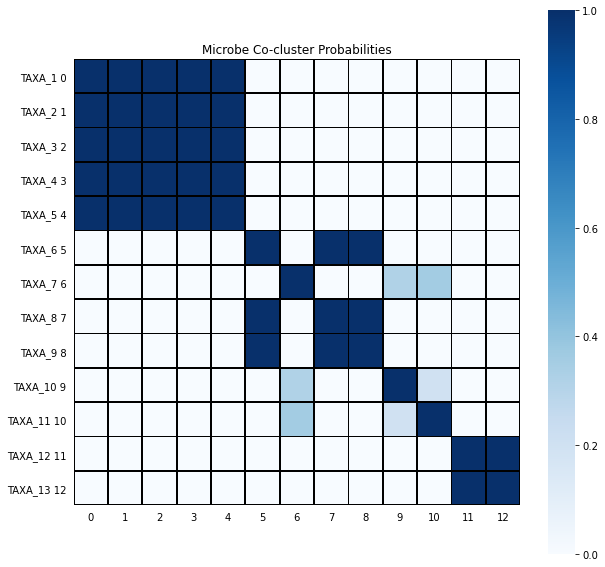

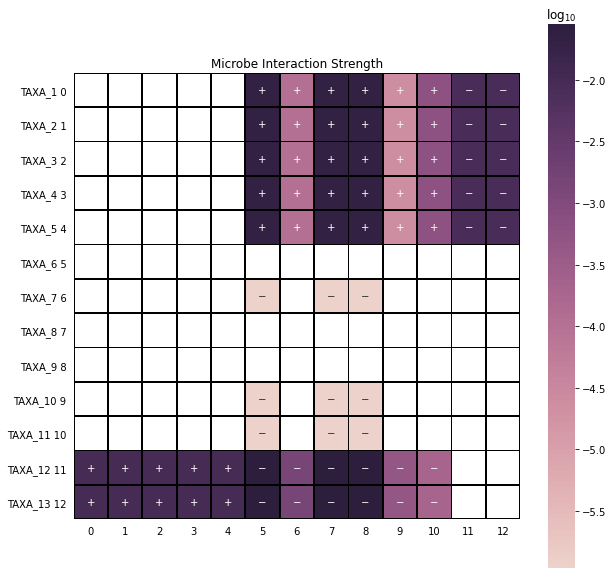

In [47]:
# Plot the posterior
clustering = mcmc.graph[STRNAMES.CLUSTERING_OBJ]
coclusters = md2.summary(clustering.coclusters)['mean']
md2.visualization.render_cocluster_probabilities(coclusters, taxa=study.taxa)

interactions = mcmc.graph[STRNAMES.INTERACTIONS_OBJ]
A = md2.summary(interactions, set_nan_to_0=True)['mean']
md2.visualization.render_interaction_strength(A, log_scale=True, taxa=study.taxa, 
                                              center_colors=True)



### Compute the errors between the predicted and the ground truth

Calculate the following statistics:
1. AUCROC of interactions
2. RMSE of interactions
3. RMSE growth values
4. relRMSE of predicted trajectory
5. Normalized mutual information of cluster assignments

In [48]:
# AUCROC
# ------

# Get truth
truth = syn.model.interactions

# Get predicted, set self-interactions as diagonal
pred = mcmc.graph[STRNAMES.INTERACTIONS_OBJ].get_trace_from_disk()
si = mcmc.graph[STRNAMES.SELF_INTERACTION_VALUE].get_trace_from_disk()
for i in range(len(study.taxa)):
    pred[:,i,i] = si[:, i]

roc_per_gibb = md2.metrics.rocauc_posterior_interactions(
    pred=pred, truth=truth, signed=True, per_gibb=True)
print('Average ROCAUC:', np.mean(roc_per_gibb))



Average ROCAUC: 0.815836781210228


In [49]:
# RMSE of interactions
# --------------------
arr = np.zeros(pred.shape[0])
for gibb in range(len(arr)):
    arr[gibb] = md2.metrics.RMSE(truth, pred[gibb])
print('Average RMSE error of interactions:', np.mean(arr))

Average RMSE error of interactions: 0.0333023698635899


In [50]:
# RMSE of growth values
# ---------------------

truth = syn.model.growth
pred = mcmc.graph[STRNAMES.GROWTH_VALUE].get_trace_from_disk()

arr = np.zeros(pred.shape[0])
for gibb in range(len(arr)):
    arr[gibb] = md2.metrics.RMSE(truth, pred[gibb])
print('Average RMSE error of growth values', np.mean(arr))

Average RMSE error of growth values 0.20240757206632654


INFO:synthetic.175: Forward simulating subj-validate
INFO:model.116: 5/100 - 0.07203245162963867
INFO:model.116: 10/100 - 0.07500171661376953
INFO:model.116: 15/100 - 0.07500195503234863
INFO:model.116: 20/100 - 0.07399725914001465
INFO:model.116: 25/100 - 0.07600116729736328
INFO:model.116: 30/100 - 0.07799935340881348
INFO:model.116: 35/100 - 0.07804465293884277
INFO:model.116: 40/100 - 0.07599997520446777
INFO:model.116: 45/100 - 0.07999992370605469
INFO:model.116: 50/100 - 0.08000063896179199
INFO:model.116: 55/100 - 0.07096481323242188
INFO:model.116: 60/100 - 0.07303929328918457
INFO:model.116: 65/100 - 0.07900309562683105
INFO:model.116: 70/100 - 0.07300209999084473
INFO:model.116: 75/100 - 0.07403230667114258
INFO:model.116: 80/100 - 0.07200026512145996
INFO:model.116: 85/100 - 0.07600021362304688
INFO:model.116: 90/100 - 0.07403087615966797
INFO:model.116: 95/100 - 0.0740349292755127


Average relRMSE error for pred trajectory: 0.007996416197161953


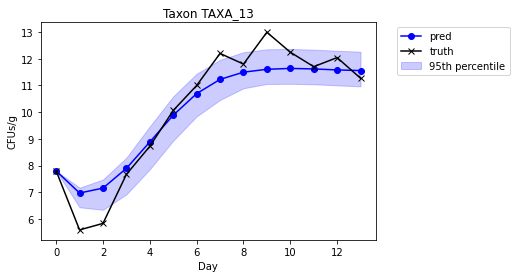

In [51]:
# relRMSE of predicted trajectories
# ---------------------------------

# Simulate a new trajectory
syn.add_subject('subj-validate')

syn.generate_trajectories(
    dt=0.01, init_dist=md2.variables.Uniform(low=2, high=15), 
    processvar=pv, seed=1010101) # only generates a new trajectory for the new subject

# Get the ground truth
truth = syn._data['subj-validate']

# Get the initial conditions
initial_conditions = truth[:, 0]

# forward simulate
pred = md2.model.gLVDynamicsSingleClustering.forward_sim_from_chain(
    mcmc=mcmc, subj=None, initial_conditions=initial_conditions,
    times=syn.times, simulation_dt=0.01)
pred.shape

# Plot the predicted trajectory for the last taxa
low = np.percentile(pred[:, -1, :], q=2.5, axis=0)
high = np.percentile(pred[:, -1, :], q=97.5, axis=0)
med = np.percentile(pred[:, -1, :], q=50, axis=0)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.fill_between(syn.times, low, high, alpha=0.2, color='blue',
                label='95th percentile')
ax.plot(syn.times, med, color='blue', label='pred', marker='o')
ax.plot(syn.times, truth[-1, :], color='black', marker='x', label='truth')
ax.legend(bbox_to_anchor=(1.05, 1))
ax.set_title('Taxon {}'.format(study.taxa[len(study.taxa)-1].name))
ax.set_xlabel('Day')
ax.set_ylabel('CFUs/g')

# Get the relRMSE error
errors = np.zeros(pred.shape[0])
for i in range(len(errors)):
    errors[i] = md2.metrics.relRMSE(pred=pred[i], truth=truth)
print('Average relRMSE error for pred trajectory:', np.mean(errors))


In [52]:
# Normalized mutual information for cluster assignments
# -----------------------------------------------------
import sklearn.metrics

truth = syn.G[STRNAMES.CLUSTERING_OBJ].toarray()

clustering = mcmc.graph[STRNAMES.CLUSTERING_OBJ]
coclusters = clustering.coclusters.get_trace_from_disk()

errors = np.zeros(coclusters.shape[0])
for i in range(len(errors)):
    pred = md2.pylab.cluster.toarray_from_cocluster(coclusters[i])
    errors[i] = sklearn.metrics.normalized_mutual_info_score(
        labels_true=truth, labels_pred=pred)
print('Average normalized mutual information:', np.mean(errors))

Average normalized mutual information: 0.8054775321882914


# Semi synthetic
Simulate from a fixed clustering dynamics learned from the data

In [53]:
# Learn a synthetic system
# ------------------------
# Learn the clustering
a0 = md2.summary(mcmc_negbin.graph[STRNAMES.NEGBIN_A0])['mean']
a1 = md2.summary(mcmc_negbin.graph[STRNAMES.NEGBIN_A1])['mean']

basepath = 'output/semisynth/unfixed'
os.makedirs(basepath, exist_ok=True)
params = md2.config.MDSINE2ModelConfig(
    basepath=basepath, seed=0, burnin=50, 
    n_samples=100, negbin_a0=a0, negbin_a1=a1, checkpoint=50)
params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value_option'] = 'no-clusters'
mcmc_uc0 = md2.initialize_graph(params=params, graph_name=uc_toy.name, subjset=uc_toy)
mcmc_uc0 = md2.run_graph(mcmc_uc0, crash_if_error=True)

# Fix the cluster assignments
basepath='output/semisynth/fixed'
params = md2.config.MDSINE2ModelConfig(
    basepath=basepath, seed=0, burnin=50, n_samples=100, 
    negbin_a0=a0, negbin_a1=a1, checkpoint=50)
params.LEARN[STRNAMES.CLUSTERING] = False
params.LEARN[STRNAMES.CONCENTRATION] = False
params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value_option'] = 'fixed-clustering'
params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value'] = 'output/semisynth/unfixed/mcmc.pkl'
mcmc = md2.initialize_graph(params=params, graph_name=uc_toy.name, subjset=uc_toy)
mcmc = md2.run_graph(mcmc, crash_if_error=True)

INFO:base.2727: max_value found: 1797837340792.1643, scaling_factor: 5.5622384590108656e-11
INFO:run.87: Normalizing abundances for a max value of 100. Normalization constant: 5.5622E-11
INFO:run.254: There are 372 qPCR measurements for 3 buckets. Each bucket is 124 measurements long
INFO:run.289: Initializing Filtering
INFO:posterior.2670: Setting up the essential timepoints
INFO:posterior.2683: Essential timepoints: [ 1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   6.   7.   8.   9.  10.  11.  14.  16.  18.  21.  21.5 22.  22.5 23.  23.5 24.  25.  28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  33.  35.  35.5 36.  36.5 37.  37.5 38.  39.  42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  47.  50.  50.5 51.  51.5 52.  52.5 53.  54.  57.  57.5 58.  58.5 59.  59.5 60.  60.5 61.  62.  63.  64.  64.5]
INFO:run.289: Initializing Zero inflation
INFO:design_matrices.851: Initializing LHS vector
INFO:design_matrices.1006: Initializing growth design matrix
INFO:design_matrices.932: Initializing self-inte

INFO:run.374: 		prior.loc: 0
INFO:run.372: 	perturbation Vancomycin
INFO:run.373: 		value: {100115: 0, 100116: 0, 100117: 0, 100118: 0, 100119: 0, 100120: 0, 100121: 0, 100122: 0, 100123: 0, 100124: 0, 100125: 0, 100126: 0, 100127: 0, 100128: 0, 100129: 0}
INFO:run.374: 		prior.loc: 0
INFO:run.372: 	perturbation Gentamicin
INFO:run.373: 		value: {100115: 0, 100116: 0, 100117: 0, 100118: 0, 100119: 0, 100120: 0, 100121: 0, 100122: 0, 100123: 0, 100124: 0, 100125: 0, 100126: 0, 100127: 0, 100128: 0, 100129: 0}
INFO:run.374: 		prior.loc: 0
INFO:run.375: Perturbation prior variances:
INFO:run.377: 		dof: 2.5
INFO:run.378: 		scale: 2000.0
INFO:run.379: 		value: 10000.0
INFO:run.377: 		dof: 2.5
INFO:run.378: 		scale: 2000.0
INFO:run.379: 		value: 10000.0
INFO:run.377: 		dof: 2.5
INFO:run.378: 		scale: 2000.0
INFO:run.379: 		value: 10000.0
INFO:run.380: Perturbation indicators:
INFO:run.383: 	perturbation High Fat Diet: [False False False False False False False False False False False False 

INFO:inference.456: Cluster interaction probability: 0.6043018889441922
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.027968406677246094s
perturbation High Fat Diet (11/15): [ True  True False  True  True  True  True  True  True  True False  True  True False False]
perturbation Vancomycin (9/15): [False False False False  True  True  True False  True  True  True False  True  True  True]
perturbation Gentamicin (11/15): [False  True  True False  True False  True  True False  True  True  True  True  True  True]
INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.5920580173583005
	perturbation Vancomycin: 0.549680099301045
	perturbation Gentamicin: 0.65283684507178
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.13888075 0.38883838 0.74198946 0.31702922 0.6896659  0

INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.11337249 0.38859499 0.33014617 0.16887064 0.59203325 0.69092359 0.49483672 0.29434092 0.33698284 0.16648646 0.2863119  0.41301181 1.11932416 1.0522816  0.15503763]
Self Interactions:
[6.04604003e-02 1.92413895e-01 1.93158557e-01 6.93214556e-01 9.73754823e-01 8.24754963e-01 9.56571917e-01 7.91711182e-01 6.63315959e+01 1.04319589e+02 9.47963187e-01 1.11336927e+02 3.82490755e+00 3.12101908e+00 2.96078865e+00]
Interactions:
[-72.45039622  98.12626978 -93.54565691 134.83306348 136.00236192 -53.33429919  -0.20539336 -35.13039073 -92.81703672 -42.11358682  -5.56666542  -0.26252615  -0.22398897   4.83342818   0.49025318  -3.15168711 -38.33025929   2.42504201  27.12817503  11.47123513 -25.27745425  -0.59560067   1.80613917 -17.39412038 -21.3997764   41.28376106  -0.21061135 107.3118267    2.27839898  -0.92800089 -28.07395469 -21.49237607  -2.14547836]
Perturbations:
Perturbation Ma

INFO:inference.456: Clustering concentration parameter: 3448.097096069401
INFO:inference.447: 

Inference iteration 4/100, time: 0.4100303649902344
INFO:inference.456: Cluster interaction indicator parameter: [False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False Fals

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 16.452398585960815
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 28.1503907712881
	perturbation Vancomycin: -26.45763937533464
	perturbation Gentamicin: -72.33467992925952
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.3405548591587161, Acceptance rate: 1.0
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.2757919470218595, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 462.4907627126775
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 4710.193698528133
	perturbation Vancomycin: 1871.8211868210165
	perturbation Genta

INFO:inference.456: Cluster interaction probability: 9.513074801944283e-06
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.010997772216796875s
perturbation High Fat Diet (0/14): [False False False False False False False False False False False False False False]
perturbation Vancomycin (1/14): [False False False False  True False False False False False False False False False]
perturbation Gentamicin (1/14): [False False False False False False False  True False False False False False False]
INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.0033579122500730454
	perturbation Vancomycin: 0.0746805089595243
	perturbation Gentamicin: 0.05108652575560181
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.09508797 0.05021257 0.67220491 0.07540306 0.50136328 0.07226197 

INFO:inference.456: Clustering concentration parameter: 88.03515278651948
INFO:posterior.1585: 0/15: 12
INFO:posterior.1585: 1/15: 7
INFO:posterior.1585: 2/15: 9
INFO:posterior.1585: 3/15: 2
INFO:posterior.1585: 4/15: 1
INFO:posterior.1585: 5/15: 0
INFO:posterior.1585: 6/15: 4
INFO:posterior.1585: 7/15: 13
INFO:posterior.1585: 8/15: 14
INFO:posterior.1585: 9/15: 5
INFO:posterior.1585: 10/15: 11
INFO:posterior.1585: 11/15: 8
INFO:posterior.1585: 12/15: 3
INFO:posterior.1585: 13/15: 10
INFO:posterior.1585: 14/15: 6
INFO:inference.447: 

Inference iteration 9/100, time: 0.8730001449584961
INFO:inference.456: Cluster interaction indicator parameter: [False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False Fal

INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 156.37432526118457
	perturbation Vancomycin: 20.53808434245524
	perturbation Gentamicin: 81.25794655663718
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.4936765075951804, Acceptance rate: 1.0
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.7714071216402885, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 74.00730122023141
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 4488.441349107303
	perturbation Vancomycin: 1817.7365164281423
	perturbation Gentamicin: 3168.222944435099
INFO:inference.456: Process Variance parameter: 4.269004284966113, empirical_var

INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.010996580123901367s
perturbation High Fat Diet (0/14): [False False False False False False False False False False False False False False]
perturbation Vancomycin (3/14): [False  True False False False False False  True False  True False False False False]
perturbation Gentamicin (0/14): [False False False False False False False False False False False False False False]
INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.020233801328186665
	perturbation Vancomycin: 0.12651278617704334
	perturbation Gentamicin: 0.009497945751149574
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.6616632  0.36674976 0.57593883 0.19522078 0.48030598 0.34150619 0.18034939 0.34123364 0.02546247 0.00678891 0.23081727 0.30983779 0.582903

INFO:inference.456: Clustering concentration parameter: 296.0224368190666
INFO:inference.447: 

Inference iteration 14/100, time: 0.3809981346130371
INFO:inference.456: Cluster interaction indicator parameter: [False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False Fal

INFO:inference.456: Process Variance parameter: 4.140838549153522, empirical_variance: 4.09071
INFO:inference.456: Filtering: no-mp - Time: 0.2850, Acc: [0.634, 0.615, 0.622, 0.623, 0.618], data/sec: 19734.39
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 13
Cluster 100154
	members: ['OTU_17', 'OTU_9', 'OTU_16']
	size: 3
Cluster 100160
	members: ['OTU_13']
	size: 1
Cluster 100175
	members: ['OTU_7']
	size: 1
Cluster 100179
	members: ['OTU_10']
	size: 1
Cluster 100181
	members: ['OTU_5']
	size: 1
Cluster 100183
	members: ['OTU_1']
	size: 1
Cluster 100185
	members: ['OTU_6']
	size: 1
Cluster 100186
	members: ['OTU_18']
	size: 1
Cluster 100187
	members: ['OTU_8']
	size: 1
Cluster 100189
	members: ['OTU_3']
	size: 1
Cluster 100191
	members: ['OTU_4']
	size: 1
Cluster 100193
	members: ['OTU_12']
	size: 1
Cluster 100194
	members: ['OTU_2']
	size: 1
no mp - Total time: 0.4620075225830078
INFO:inference.456: Cluster

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 3.358772701106344
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 53.590013475648405
	perturbation Vancomycin: 57.862769813821
	perturbation Gentamicin: -135.39893013639534
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.5683769711832217, Acceptance rate: 1.0
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.0890186577351004, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 25.67923971303971
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 54252.7669649094
	perturbation Vancomycin: 3756.6911121095454
	perturbation Gentami

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 10.19790711035418
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 100.53885263209533
	perturbation Vancomycin: 20.79504632717145
	perturbation Gentamicin: 100.84023198028589
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.14495067566962627, Acceptance rate: 1.0
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.9696825030964185, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 68.4567102198941
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 14147.426292385268
	perturbation Vancomycin: 3999.5646884126454
	perturbation Gent

INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.79508747 0.39449399 0.60322871 0.08643502 0.47175138 0.25397105 0.31035797 0.31011284 0.16236486 0.19428609 0.51092815 0.07466683 1.24452173 0.88750287 0.33543884]
Self Interactions:
[  0.28715886   0.21592317   0.33241744   3.07829437   0.64936087   0.57066249   1.72839398   0.93828919 186.17469328 107.36673294   2.16406355  54.65717902   5.01337987   3.84123539   5.47723169]
Interactions:
[-1.34497766 -0.12949302]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.34642878]
	 perturbation Gentamicin: []
INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 2.1244405856306017
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 13.526869696912074
	perturbation Vancomycin: 42.1

INFO:inference.456: Cluster interaction probability: 0.03004264249514047
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.009999990463256836s
perturbation High Fat Diet (0/12): [False False False False False False False False False False False False]
perturbation Vancomycin (1/12): [ True False False False False False False False False False False False]
perturbation Gentamicin (1/12): [False False False False False False False False False False  True False]
INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 5.1049575320348055e-05
	perturbation Vancomycin: 0.1692775205149808
	perturbation Gentamicin: 0.20217154112192734
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.62176898 0.34763856 0.68748121 0.08499238 0.4695292  0.53881491 0.45433607 0.39738528 0.10872566 0.25

INFO:posterior.1585: 3/15: 13
INFO:posterior.1585: 4/15: 4
INFO:posterior.1585: 5/15: 8
INFO:posterior.1585: 6/15: 9
INFO:posterior.1585: 7/15: 14
INFO:posterior.1585: 8/15: 6
INFO:posterior.1585: 9/15: 5
INFO:posterior.1585: 10/15: 12
INFO:posterior.1585: 11/15: 2
INFO:posterior.1585: 12/15: 10
INFO:posterior.1585: 13/15: 3
INFO:posterior.1585: 14/15: 1
INFO:inference.447: 

Inference iteration 25/100, time: 0.8199994564056396
INFO:inference.456: Cluster interaction indicator parameter: [False False False  True False False False False False False False False False False False False False False False  True False False False  True False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False  True False  True False False Fa

INFO:inference.456: Filtering: no-mp - Time: 0.2840, Acc: [0.633, 0.635, 0.615, 0.637, 0.636], data/sec: 19804.85
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 10
Cluster 100207
	members: ['OTU_17', 'OTU_7', 'OTU_6', 'OTU_16']
	size: 4
Cluster 100231
	members: ['OTU_1', 'OTU_8']
	size: 2
Cluster 100240
	members: ['OTU_13', 'OTU_2']
	size: 2
Cluster 100242
	members: ['OTU_5']
	size: 1
Cluster 100244
	members: ['OTU_9']
	size: 1
Cluster 100246
	members: ['OTU_10']
	size: 1
Cluster 100247
	members: ['OTU_18']
	size: 1
Cluster 100251
	members: ['OTU_3']
	size: 1
Cluster 100253
	members: ['OTU_12']
	size: 1
Cluster 100255
	members: ['OTU_4']
	size: 1
no mp - Total time: 0.44700026512145996
INFO:inference.456: Clustering concentration parameter: 26.94289324668471
INFO:inference.447: 

Inference iteration 27/100, time: 0.36997389793395996
INFO:inference.456: Cluster interaction indicator parameter: [ True False Fa

INFO:inference.456: Process Variance parameter: 3.467352221535047, empirical_variance: 3.52300
INFO:inference.456: Filtering: no-mp - Time: 0.2790, Acc: [0.626, 0.612, 0.628, 0.628, 0.612], data/sec: 20161.63
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 10
Cluster 100207
	members: ['OTU_17', 'OTU_7', 'OTU_6', 'OTU_16']
	size: 4
Cluster 100231
	members: ['OTU_1', 'OTU_8']
	size: 2
Cluster 100240
	members: ['OTU_13', 'OTU_2']
	size: 2
Cluster 100242
	members: ['OTU_5']
	size: 1
Cluster 100244
	members: ['OTU_9']
	size: 1
Cluster 100246
	members: ['OTU_10']
	size: 1
Cluster 100247
	members: ['OTU_18']
	size: 1
Cluster 100251
	members: ['OTU_3']
	size: 1
Cluster 100253
	members: ['OTU_12']
	size: 1
Cluster 100255
	members: ['OTU_4']
	size: 1
no mp - Total time: 0.44700026512145996
INFO:inference.456: Clustering concentration parameter: 18.990508800173227
INFO:posterior.1585: 0/15: 7
INFO:posterior.1585: 1/15: 

INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.4670233390869742, Acceptance rate: 1.0
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.403308442464499, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 12.455414982186138
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 8034.858508336491
	perturbation Vancomycin: 1710.980978809604
	perturbation Gentamicin: 784.820803277324
INFO:inference.456: Process Variance parameter: 3.41562127734201, empirical_variance: 3.47771
INFO:inference.456: Filtering: no-mp - Time: 0.2910, Acc: [0.641, 0.615, 0.598, 0.631, 0.619], data/sec: 19331.87
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 10
Clu

INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.7217800769173863, Acceptance rate: 1.0
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.6683689248283455, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 21.3245710546052
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1367.666637312224
	perturbation Vancomycin: 766.8062349411834
	perturbation Gentamicin: 3712.289517492893
INFO:inference.456: Process Variance parameter: 3.3959177140317958, empirical_variance: 3.40323
INFO:inference.456: Filtering: no-mp - Time: 0.2851, Acc: [0.633, 0.620, 0.631, 0.666, 0.613], data/sec: 19733.34
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 10
C

INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 2.7512514918333144, Acceptance rate: 1.0
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 3.051038049490372, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 59.47769265090355
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 507.0975056723121
	perturbation Vancomycin: 1321.9245506718044
	perturbation Gentamicin: 2036.903076324488
INFO:inference.456: Process Variance parameter: 3.402256530920826, empirical_variance: 3.32714
INFO:inference.456: Filtering: no-mp - Time: 0.2930, Acc: [0.628, 0.602, 0.614, 0.650, 0.609], data/sec: 19196.08
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 7
Cl

INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 7
Cluster 100207
	members: ['OTU_16', 'OTU_17', 'OTU_6', 'OTU_5', 'OTU_7']
	size: 5
Cluster 100242
	members: ['OTU_13']
	size: 1
Cluster 100262
	members: ['OTU_2', 'OTU_1', 'OTU_8', 'OTU_10']
	size: 4
Cluster 100280
	members: ['OTU_18']
	size: 1
Cluster 100282
	members: ['OTU_12', 'OTU_3']
	size: 2
Cluster 100288
	members: ['OTU_4']
	size: 1
Cluster 100290
	members: ['OTU_9']
	size: 1
no mp - Total time: 0.3849976062774658
INFO:inference.456: Clustering concentration parameter: 2.6476327794037173
INFO:posterior.1585: 0/15: 3
INFO:posterior.1585: 1/15: 1
INFO:posterior.1585: 2/15: 4
INFO:posterior.1585: 3/15: 9
INFO:posterior.1585: 4/15: 12
INFO:posterior.1585: 5/15: 11
INFO:posterior.1585: 6/15: 10
INFO:posterior.1585: 7/15: 8
INFO:posterior.1585: 8/15: 14
INFO:posterior.1585: 9/15: 7
INFO:posterior.1585: 10/15: 2
INFO:posterior.1585: 11/15: 6
INFO:posterior.158

INFO:inference.456: Cluster interaction probability: 0.08438111538047556
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.004010438919067383s
perturbation High Fat Diet (0/4): [False False False False]
perturbation Vancomycin (1/4): [ True False False False]
perturbation Gentamicin (0/4): [False False False False]
INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.00015349593414716925
	perturbation Vancomycin: 0.6062826139516916
	perturbation Gentamicin: 0.0035264625188093316
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.62834914 0.35387466 0.50442724 0.24765312 1.0237121  0.68951898 0.52319806 0.3318652  0.14115849 0.18070927 0.42756473 0.25282155 1.08594628 1.26008173 0.35396187]
Self Interactions:
[4.18768167e-01 2.53563681e-01 2.29242992e-01 9.50833809e+00 5.

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -13.86257636620126
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 27.978501849028376
	perturbation Vancomycin: 8.623468525836321
	perturbation Gentamicin: 3.0590377567276033
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 2.8163090655633614, Acceptance rate: 1.0
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.7634209543838881, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 43.105213345464456
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2646.8238425744103
	perturbation Vancomycin: 2018.956351499195
	perturbation Gen

INFO:inference.456: Clustering concentration parameter: 1.222632254024677
INFO:inference.447: 

Inference iteration 44/100, time: 0.33296990394592285
INFO:inference.456: Cluster interaction indicator parameter: [ True False False  True False False False  True False False False False False False False False False False False False]
total time: 0.011980533599853516, n_interactions: 3/20, 0.15
INFO:inference.456: Cluster interaction probability: 0.1326804697996742
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.0060007572174072266s
perturbation High Fat Diet (0/5): [False False False False False]
perturbation Vancomycin (1/5): [ True False False False False]
perturbation Gentamicin (0/5): [False False False False False]
INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.06323218926396762
	perturbation Vancomycin: 0.2758478583239249


INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.59811155 0.42814742 0.54168437 0.18600103 0.76059954 0.99466302 0.82034298 0.4905009  0.1121394  0.04890201 0.29810462 0.3300236  1.21265704 1.13571718 0.08862902]
Self Interactions:
[  0.35646139   0.24707006   0.23825672   9.02145999   0.19590776   0.45822667   0.40244027   1.55627198 135.78800344 150.20711248   1.7938208   90.08487986   3.31962003   2.70615077   2.87781208]
Interactions:
[-0.18274383]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-0.89217266]
	 perturbation Gentamicin: []
INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 7.066085585020877
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 43.42147162101267
	perturbation Vancomycin: 23.079808954534602

INFO:inference.456: Process Variance parameter: 2.9930012087326, empirical_variance: 2.96613
INFO:inference.456: Filtering: no-mp - Time: 0.3000, Acc: [0.645, 0.604, 0.636, 0.611, 0.616], data/sec: 18752.07
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 3
Cluster 100207
	members: ['OTU_17', 'OTU_5', 'OTU_6', 'OTU_16', 'OTU_7']
	size: 5
Cluster 100262
	members: ['OTU_10', 'OTU_2', 'OTU_12', 'OTU_1', 'OTU_4', 'OTU_13']
	size: 6
Cluster 100305
	members: ['OTU_18', 'OTU_9', 'OTU_3', 'OTU_8']
	size: 4
no mp - Total time: 0.2149968147277832
INFO:inference.456: Clustering concentration parameter: 1.4416645144112217
INFO:posterior.1585: 0/15: 14
INFO:posterior.1585: 1/15: 12
INFO:posterior.1585: 2/15: 8
INFO:posterior.1585: 3/15: 3
INFO:posterior.1585: 4/15: 1
INFO:posterior.1585: 5/15: 6
INFO:posterior.1585: 6/15: 5
INFO:posterior.1585: 7/15: 2
INFO:posterior.1585: 8/15: 11
INFO:posterior.1585: 9/15: 13
INFO:poster

INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.022639504687605217
	perturbation Vancomycin: 0.29138719972538607
	perturbation Gentamicin: 0.10368903860380017
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.80031193 0.38628434 0.76624862 0.08421609 0.88328962 0.70200612 0.7176599  0.69016056 0.13309459 0.2216119  0.38490831 0.04488763 1.31476026 0.8943853  0.57428348]
Self Interactions:
[4.27543692e-01 2.98296202e-01 2.50561918e-01 1.02004788e+01 1.75935631e-01 2.91610223e-01 6.37229642e-01 1.72933410e+00 1.59394466e+02 2.34777925e+02 2.01178071e+00 8.35754619e+01 2.51021811e+00 3.36553734e+00 5.72108136e+00]
Interactions:
[-0.16293277]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-0.80636172]
	 perturbation Gentamicin: [-1.49203

INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 2.0703035510895176, Acceptance rate: 1.0
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 3.0401964026102046, Acceptance rate: 0.98
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 56.6899618179315
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 4573.221335735359
	perturbation Vancomycin: 3979.850785322681
	perturbation Gentamicin: 1811.08039618511
INFO:inference.456: Process Variance parameter: 2.8276393894327834, empirical_variance: 2.86935
INFO:inference.456: Filtering: no-mp - Time: 0.2830, Acc: [0.615, 0.613, 0.615, 0.652, 0.605], data/sec: 19876.23
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 3
Cl

INFO:inference.456: Cluster interaction probability: 0.1102030701461803
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.006021738052368164s
perturbation High Fat Diet (0/3): [False False False]
perturbation Vancomycin (1/3): [ True False False]
perturbation Gentamicin (1/3): [False False  True]
INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.02625087083235413
	perturbation Vancomycin: 0.23503088454618035
	perturbation Gentamicin: 0.5916201351363407
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.785155   0.66436911 0.81661496 0.25103608 0.55806552 0.59795906 0.43994829 0.73066265 0.33076759 0.33269677 0.66989455 0.10505549 0.93514939 0.83922315 0.71971621]
Self Interactions:
[3.07041925e-01 3.27549609e-01 2.00977618e-01 1.04812267e+01 1.23073691e-01 6.84340959e

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -1.183656755372128
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -136.44784067439969
	perturbation Vancomycin: -26.718133573080525
	perturbation Gentamicin: 17.57578696764979
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 3.0767136112215123, Acceptance rate: 1.0
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 3.3790569553283336, Acceptance rate: 0.98
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 20.093213676831276
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 24745.824523314113
	perturbation Vancomycin: 2512.895912811492
	perturbation 

INFO:inference.456: Clustering concentration parameter: 0.616401867308753
INFO:posterior.1585: 0/15: 10
INFO:posterior.1585: 1/15: 2
INFO:posterior.1585: 2/15: 7
INFO:posterior.1585: 3/15: 5
INFO:posterior.1585: 4/15: 0
INFO:posterior.1585: 5/15: 3
INFO:posterior.1585: 6/15: 13
INFO:posterior.1585: 7/15: 9
INFO:posterior.1585: 8/15: 12
INFO:posterior.1585: 9/15: 14
INFO:posterior.1585: 10/15: 11
INFO:posterior.1585: 11/15: 8
INFO:posterior.1585: 12/15: 6
INFO:posterior.1585: 13/15: 4
INFO:posterior.1585: 14/15: 1
INFO:inference.447: 

Inference iteration 61/100, time: 0.5140266418457031
INFO:inference.456: Cluster interaction indicator parameter: [ True  True False False False  True]
total time: 0.008020639419555664, n_interactions: 3/6, 0.50
INFO:inference.456: Cluster interaction probability: 0.2379047578720197
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.0049896240234375s
perturbation High Fat Diet (0/4): [False False False False]
perturbat

INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.65163855 0.56756829 0.58977139 0.32921564 0.80644993 0.8168133  0.63205478 0.6632107  0.22626622 0.37063908 0.60729064 0.38066386 1.18209228 0.96148114 0.6866253 ]
Self Interactions:
[3.19189436e-01 2.07846134e-01 2.07604081e-01 5.20475182e+00 7.51819097e-02 3.45646023e-01 8.59679417e-01 7.98787754e-01 2.38650633e+02 1.71331541e+02 3.41487604e+00 1.25871814e+02 3.15431877e+00 3.91020634e+00 1.97059719e+00]
Interactions:
[-0.93685576 -0.05975863 -1.02792516]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-0.97275083]
	 perturbation Gentamicin: []
INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -4.468234861988806
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -4.3707

INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 2.1666207325370896, Acceptance rate: 1.0
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.975169124613961, Acceptance rate: 0.98
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 45.24984403848461
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 5853.623836752447
	perturbation Vancomycin: 3934.0770080974153
	perturbation Gentamicin: 5422.034925994741
INFO:inference.456: Process Variance parameter: 2.5806774736037186, empirical_variance: 2.57891
INFO:inference.456: Filtering: no-mp - Time: 0.2950, Acc: [0.635, 0.624, 0.608, 0.604, 0.604], data/sec: 19067.55
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 5


INFO:inference.456: Clustering concentration parameter: 4.256746568885342
INFO:inference.447: 

Inference iteration 68/100, time: 0.33500051498413086
INFO:inference.456: Cluster interaction indicator parameter: [ True False  True False False False False False False False False False False False False False False False False  True]
total time: 0.012001514434814453, n_interactions: 3/20, 0.15
INFO:inference.456: Cluster interaction probability: 0.12570742545579774
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.0069997310638427734s
perturbation High Fat Diet (0/5): [False False False False False]
perturbation Vancomycin (1/5): [ True False False False False]
perturbation Gentamicin (1/5): [False False False False  True]
INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.057508148919926144
	perturbation Vancomycin: 0.049065788132113

INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.05731839327908066
	perturbation Vancomycin: 0.3086289126015055
	perturbation Gentamicin: 0.09818264708306
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.75471201 0.37818391 0.74596967 0.14160622 0.85746256 0.85050197 0.78996002 0.60685738 0.19214987 0.18599677 0.54582437 0.15191825 1.27363835 1.22006846 0.69198694]
Self Interactions:
[5.44469245e-01 3.14381235e-01 1.94436599e-01 7.72350826e+00 2.58524966e-01 4.51450457e-01 1.49048809e-01 1.76636441e+00 2.05011144e+02 1.88253454e+02 2.99569266e+00 1.68543654e+02 3.13877993e+00 3.54390523e+00 5.23940514e-01]
Interactions:
[-0.16362341 -0.52344696 -0.86517974]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-0.92169414]
	 perturbation Ge

INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.914413785067707, Acceptance rate: 1.0
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 3.1100285076205068, Acceptance rate: 0.98
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 49.812197756425945
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1321.4964807063984
	perturbation Vancomycin: 734.6172849116489
	perturbation Gentamicin: 839.6201378895638
INFO:inference.456: Process Variance parameter: 2.4777637981278415, empirical_variance: 2.48362
INFO:inference.456: Filtering: no-mp - Time: 0.2900, Acc: [0.644, 0.612, 0.637, 0.612, 0.604], data/sec: 19394.58
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 5

INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 4
Cluster 100207
	members: ['OTU_17', 'OTU_6', 'OTU_18', 'OTU_16', 'OTU_5', 'OTU_7']
	size: 6
Cluster 100305
	members: ['OTU_2', 'OTU_4', 'OTU_13', 'OTU_1']
	size: 4
Cluster 100410
	members: ['OTU_10', 'OTU_3', 'OTU_9', 'OTU_8']
	size: 4
Cluster 100441
	members: ['OTU_12']
	size: 1
no mp - Total time: 0.20998024940490723
INFO:inference.456: Clustering concentration parameter: 1.9433649970161848
INFO:inference.447: 

Inference iteration 75/100, time: 0.3249955177307129
INFO:inference.456: Cluster interaction indicator parameter: [ True False  True False False False False False  True False False False]
total time: 0.007031679153442383, n_interactions: 3/12, 0.25
INFO:inference.456: Cluster interaction probability: 0.2782251525226648
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.007967233657836914s
perturbation High Fat Die

INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.004320414349864127
	perturbation Vancomycin: 0.047012133570686336
	perturbation Gentamicin: 0.03572172937127516
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.66192241 0.40082205 0.75000324 0.20521227 0.86304837 0.90752178 0.657599   0.40482453 0.43143391 0.35443499 0.90687733 0.0908429  1.45468114 1.19131596 0.78771796]
Self Interactions:
[4.22021799e-01 1.94868593e-01 2.06546510e-01 8.27402503e+00 2.08025349e-01 3.28195647e-01 3.13657771e-01 8.29224321e-01 1.90506291e+02 2.35543173e+02 2.15577433e+00 1.52392961e+02 2.52012747e+00 3.85283226e+00 2.41764345e+00]
Interactions:
[-0.15179778 -0.54192764 -0.96646356 -0.11254167]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.03805982]

INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 80.91872353234368
	perturbation Vancomycin: 4.448272090864227
	perturbation Gentamicin: -141.39139815246858
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.1467972045716395, Acceptance rate: 1.0
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 3.7798831001798816, Acceptance rate: 0.96
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 22.581787470424228
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 685.2270830108139
	perturbation Vancomycin: 716.1146349674145
	perturbation Gentamicin: 8278.045126595667
INFO:inference.456: Process Variance parameter: 2.4332844956899455, empirical_

INFO:inference.456: Process Variance parameter: 2.304201495413861, empirical_variance: 2.45874
INFO:inference.456: Filtering: no-mp - Time: 0.2746, Acc: [0.615, 0.608, 0.609, 0.605, 0.613], data/sec: 20487.61
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 3
Cluster 100207
	members: ['OTU_18', 'OTU_7', 'OTU_17', 'OTU_16', 'OTU_5', 'OTU_6']
	size: 6
Cluster 100305
	members: ['OTU_2', 'OTU_1', 'OTU_13', 'OTU_10']
	size: 4
Cluster 100410
	members: ['OTU_9', 'OTU_8', 'OTU_12', 'OTU_4', 'OTU_3']
	size: 5
no mp - Total time: 0.2069990634918213
INFO:inference.456: Clustering concentration parameter: 0.5959370410630707
INFO:inference.447: 

Inference iteration 82/100, time: 0.3320319652557373
INFO:inference.456: Cluster interaction indicator parameter: [ True False False False False  True]
total time: 0.004982948303222656, n_interactions: 2/6, 0.33
INFO:inference.456: Cluster interaction probability: 0.18888670952857

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -5.411903579006351
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 126.53823239588348
	perturbation Vancomycin: 51.35112373539638
	perturbation Gentamicin: 6.060692934875761
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.30890684711494276, Acceptance rate: 0.98
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 3.5421307404456903, Acceptance rate: 0.96
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 132.55332617775215
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 3499.493512854751
	perturbation Vancomycin: 6447.727800006681
	perturbation Ge

INFO:inference.456: Process Variance parameter: 2.5555651504803096, empirical_variance: 2.45284
INFO:inference.456: Filtering: no-mp - Time: 0.2980, Acc: [0.613, 0.620, 0.617, 0.604, 0.616], data/sec: 18877.63
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 4
Cluster 100207
	members: ['OTU_6', 'OTU_18', 'OTU_5', 'OTU_17', 'OTU_7', 'OTU_16']
	size: 6
Cluster 100305
	members: ['OTU_2', 'OTU_13', 'OTU_9', 'OTU_1']
	size: 4
Cluster 100410
	members: ['OTU_12', 'OTU_4', 'OTU_3', 'OTU_8']
	size: 4
Cluster 100492
	members: ['OTU_10']
	size: 1
no mp - Total time: 0.16600775718688965
INFO:inference.456: Clustering concentration parameter: 0.3855250090457216
INFO:inference.447: 

Inference iteration 87/100, time: 0.327009916305542
INFO:inference.456: Cluster interaction indicator parameter: [ True False False False False False False  True False False False False]
total time: 0.011959552764892578, n_interactions: 2/12, 0

INFO:inference.456: Cluster interaction probability: 0.2386967135334957
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.007012844085693359s
perturbation High Fat Diet (0/3): [False False False]
perturbation Vancomycin (1/3): [ True False False]
perturbation Gentamicin (0/3): [False False False]
INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.03265126766822083
	perturbation Vancomycin: 0.11663842989828958
	perturbation Gentamicin: 0.0526810210362794
INFO:inference.456: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.6782926  0.25512666 0.74910907 0.44654758 0.60394137 0.73288358 0.50370842 0.50319791 0.46472989 0.12128556 0.89341423 0.30866448 1.06635136 0.83925783 0.76987281]
Self Interactions:
[4.61187316e-01 2.12273496e-01 2.48544693e-01 2.88524884e+00 1.22026051e-01 4.56645704e

INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.5031435882784066, Acceptance rate: 0.98
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 3.907903305378094, Acceptance rate: 0.96
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 99.52893141060483
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 6224.160434733384
	perturbation Vancomycin: 1543.13801715162
	perturbation Gentamicin: 60388.58175260183
INFO:inference.456: Process Variance parameter: 2.38420150086713, empirical_variance: 2.46525
INFO:inference.456: Filtering: no-mp - Time: 0.2990, Acc: [0.610, 0.613, 0.616, 0.607, 0.628], data/sec: 18814.76
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 3
Clu

INFO:inference.456: Clustering concentration parameter: 0.615299233750806
INFO:inference.447: 

Inference iteration 94/100, time: 0.34902119636535645
INFO:inference.456: Cluster interaction indicator parameter: [ True False False False False  True]
total time: 0.006002187728881836, n_interactions: 2/6, 0.33
INFO:inference.456: Cluster interaction probability: 0.0956165186905601
INFO:inference.456: Perturbation indicator parameter: Perturbation Indicators - time: 0.004998445510864258s
perturbation High Fat Diet (0/3): [False False False]
perturbation Vancomycin (1/3): [ True False False]
perturbation Gentamicin (1/3): [ True False False]
INFO:inference.456: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.08809603222010622
	perturbation Vancomycin: 0.03565548766113413
	perturbation Gentamicin: 0.08977086191695592
INFO:inference.456: Logistic growth parameters (growth, self-interactions, 

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 2.681788739438014
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 213.06172990597295
	perturbation Vancomycin: -113.13762341567029
	perturbation Gentamicin: 17.23294260915946
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.5555762390828511, Acceptance rate: 0.96
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 3.9023687909089504, Acceptance rate: 0.98
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 45.3459666701269
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 8186.00432537024
	perturbation Vancomycin: 1663.1925672950983
	perturbation Gent

INFO:inference.456: Process Variance parameter: 2.3874075713567677, empirical_variance: 2.33502
INFO:inference.456: Filtering: no-mp - Time: 0.2996, Acc: [0.631, 0.596, 0.621, 0.636, 0.624], data/sec: 18775.98
INFO:inference.456: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 5
Cluster 100207
	members: ['OTU_7', 'OTU_16', 'OTU_18', 'OTU_5', 'OTU_6', 'OTU_17', 'OTU_8']
	size: 7
Cluster 100305
	members: ['OTU_1', 'OTU_13', 'OTU_2']
	size: 3
Cluster 100410
	members: ['OTU_3', 'OTU_12', 'OTU_4']
	size: 3
Cluster 100526
	members: ['OTU_9']
	size: 1
Cluster 100534
	members: ['OTU_10']
	size: 1
no mp - Total time: 0.19998455047607422
INFO:inference.456: Clustering concentration parameter: 1.7471638267313294
INFO:inference.447: 

Inference iteration 99/100, time: 0.3320028781890869
INFO:inference.456: Cluster interaction indicator parameter: [ True False False False False False False False False  True  True  True False False False Fals

INFO:run.289: Initializing Cluster interaction value parameter
INFO:run.289: Initializing Cluster interaction indicator parameter
INFO:design_matrices.1453: Initializing interactions base design matrix
INFO:design_matrices.1582: Initialized interactions mixing design matrix
INFO:design_matrices.1923: Initializing interactions matrix
INFO:run.289: Initializing Cluster interaction probability
INFO:posterior.4135: Indicator Probability initialization results:
	prior a: 0.5
	prior b: 4.9146595004514415
	value: 0.09234190994988938
INFO:run.289: Initializing Mean parameter for the normal prior of the perturbation parameter
INFO:run.289: Initializing Variance parameter for the normal prior of the perturbation parameter
INFO:posterior.8102: Prior Variance Interactions initialization results:
	prior dof: 2.5
	prior scale: 2000.0
	value: 10000.0
INFO:posterior.8102: Prior Variance Interactions initialization results:
	prior dof: 2.5
	prior scale: 2000.0
	value: 10000.0
INFO:posterior.8102: Prior

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 0
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 0
	perturbation Vancomycin: 0
	perturbation Gentamicin: 0
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: 1
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: 1.1868489034922658
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 14086.10319720794
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 10000.0
	perturbation Vancomycin: 10000.0
	perturbation Gentamicin: 10000.0
INFO:inference.456: Process Variance parameter: NA
INFO:inference.456: Filtering: parallel
INFO:inference.447: 

Inference iteration 1/100, time: 0

INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -68.09790793123923
	perturbation Vancomycin: 24.329666161889836
	perturbation Gentamicin: -45.55458731417844
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.37258651808739407, Acceptance rate: 1.0
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.9427368485535569, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 467.462903260416
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2868.838623213101
	perturbation Vancomycin: 2025.985458475806
	perturbation Gentamicin: 4721.935296306459
INFO:inference.456: Process Variance parameter: 4.492254866345717, empirical_va

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 11.09790874692667
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -49.399434588193145
	perturbation Vancomycin: -0.5668279954758456
	perturbation Gentamicin: -160.64664587478325
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.6686788627663933, Acceptance rate: 0.8333333333333334
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.37881079049494226, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 110.88608426213095
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1633.6945582201754
	perturbation Vancomycin: 942.439745809944

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 3.6700279465172048
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 83.23787664199091
	perturbation Vancomycin: -19.467103529795462
	perturbation Gentamicin: -225.10282924480674
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.36264582003984525, Acceptance rate: 0.8888888888888888
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.09933731894980176, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 627.5965016837238
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 12428.126198420869
	perturbation Vancomycin: 1035.526818476082

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 3.000689002228267
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -48.2413541267313
	perturbation Vancomycin: -10.417585442818806
	perturbation Gentamicin: -126.65586769949641
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.5407578677288898, Acceptance rate: 0.9166666666666666
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.37952486818436937, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 147.93158893475638
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 16184.235250923217
	perturbation Vancomycin: 1013.7568138436617

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -0.22769621357401093
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 206.70884000606503
	perturbation Vancomycin: 22.231696795942632
	perturbation Gentamicin: -105.5515156768873
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.17047639023132843, Acceptance rate: 0.9333333333333333
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.9118530505808096, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 38.81905549994081
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1754.4202086112361
	perturbation Vancomycin: 2519.857230890999

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 9.662439324467258
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -63.072134980480676
	perturbation Vancomycin: -102.8671196045024
	perturbation Gentamicin: -94.42775046013723
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.26395829801447546, Acceptance rate: 0.9444444444444444
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.4893740888264784, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 58.953725260151174
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 5586.025366780175
	perturbation Vancomycin: 2841.616107125404
	

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -2.514819502016132
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -100.66388595049673
	perturbation Vancomycin: 1.7581579133280667
	perturbation Gentamicin: 163.49809460105797
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.455838931087948, Acceptance rate: 0.9523809523809523
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.4846798670852464, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 56.05728991192845
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 6019.009827961446
	perturbation Vancomycin: 2158.3498803643024
	p

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 10.578762005925368
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 218.00887017566146
	perturbation Vancomycin: 10.508640186995944
	perturbation Gentamicin: -90.11201469403044
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.3385313600313515, Acceptance rate: 0.9583333333333334
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.493528237503594, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 249.59904087112176
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1137.865439314043
	perturbation Vancomycin: 696.521925467642
	per

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -0.5507894839074944
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -185.0919920034092
	perturbation Vancomycin: -18.161294771476996
	perturbation Gentamicin: -20.09221273185249
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.9190685700244401, Acceptance rate: 0.9629629629629629
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.800798315194129, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 14.80235662899079
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 4469.508059977139
	perturbation Vancomycin: 764.7936115449452
	p

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -1.8670948670458807
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -119.74276956385663
	perturbation Vancomycin: 39.66737351842299
	perturbation Gentamicin: -41.021869278032874
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.989560563725282, Acceptance rate: 0.9666666666666667
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.3658663893603666, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 14.87386826409482
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 3631.8199199125893
	perturbation Vancomycin: 849.3637699596169
	

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 4.020661994680977
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 106.57242572841751
	perturbation Vancomycin: -8.37557395117783
	perturbation Gentamicin: -36.045363799384944
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.8111664216552281, Acceptance rate: 0.9696969696969697
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.350363797330198, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 59.52468012764073
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2727.5605355197417
	perturbation Vancomycin: 1310.459317072502
	per

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -7.059862426443598
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 140.10467894094964
	perturbation Vancomycin: 183.6412873332955
	perturbation Gentamicin: 130.11347020831906
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.4637358583008908, Acceptance rate: 0.9722222222222222
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.338848810847244, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 89.2159105477748
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2975.9524445000798
	perturbation Vancomycin: 21298.204595885512
	per

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 0.15326406274504245
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 135.59464915488869
	perturbation Vancomycin: 29.427441778524102
	perturbation Gentamicin: 33.879825230846606
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.5283842047349925, Acceptance rate: 0.9743589743589743
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.4554471132869193, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 25.91662727928375
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2681.5855874638473
	perturbation Vancomycin: 1424.747385041481
	

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 3.246924064018898
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -93.79475952614882
	perturbation Vancomycin: 13.869235457396615
	perturbation Gentamicin: -139.48401928346433
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.0257882863803383, Acceptance rate: 0.9761904761904762
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.0438310575938528, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 28.951146953275543
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 742.3966000277602
	perturbation Vancomycin: 9973.35445075867
	pe

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 2.9781703072061947
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 125.15849696328642
	perturbation Vancomycin: -23.058340252378635
	perturbation Gentamicin: -101.3491026593933
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.3313223309777384, Acceptance rate: 0.9777777777777777
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.8498994108878333, Acceptance rate: 0.9555555555555556
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 12.766313758841818
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 777.8179431743758
	perturbation Vancomycin: 2499

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -0.4247185662915782
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 111.25428478378694
	perturbation Vancomycin: 1.377274260179193
	perturbation Gentamicin: 65.28852023734808
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.3925301809149395, Acceptance rate: 0.9791666666666666
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.3245699436300737, Acceptance rate: 0.9583333333333334
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 19.348992596699595
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 715.5024078712555
	perturbation Vancomycin: 18763.

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -1.3574477982796564
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 153.24171768567686
	perturbation Vancomycin: -13.12156442940173
	perturbation Gentamicin: 81.32362345468613
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.7733148985293231, Acceptance rate: 0.98
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.4138936373188082, Acceptance rate: 0.96
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 33.11473873709359
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1545.9118288935053
	perturbation Vancomycin: 1072.1069223049365
	perturbation 

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -0.32180118430557625
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 120.78961346112725
	perturbation Vancomycin: 146.58171795860844
	perturbation Gentamicin: 171.53811663232878
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.5912011299746087, Acceptance rate: 0.98
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 3.4491867523749904, Acceptance rate: 0.96
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 57.74177686688639
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2217.1277980514183
	perturbation Vancomycin: 6117.730959842264
	perturbation

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 2.7608597094268013
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 99.98868676134418
	perturbation Vancomycin: -7.454793463557786
	perturbation Gentamicin: 132.3544230805223
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.5901913776034033, Acceptance rate: 1.0
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 4.120809593547814, Acceptance rate: 0.96
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 67.5109573676108
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1543.7659363683
	perturbation Vancomycin: 2347.871776557205
	perturbation Gentamici

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -1.520531070557872
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -97.59209971282051
	perturbation Vancomycin: 0.8796777703381743
	perturbation Gentamicin: 112.04641498590485
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 2.668280973468378, Acceptance rate: 1.0
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 3.577043188494866, Acceptance rate: 0.96
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 59.85882765449143
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2133.369706843265
	perturbation Vancomycin: 4105.273957951309
	perturbation Genta

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 1.4859050356714363
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -57.72800381336906
	perturbation Vancomycin: 70.2617602600365
	perturbation Gentamicin: 57.09582027006035
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 3.1007400459228958, Acceptance rate: 1.0
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 3.9670166607468444, Acceptance rate: 0.96
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 15.14134349613984
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 11644.894843407632
	perturbation Vancomycin: 4013.498405452355
	perturbation Genta

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -2.1629885462304106
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 14.52996540743586
	perturbation Vancomycin: -28.142939853007263
	perturbation Gentamicin: 138.2018116670181
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 2.9054989700946274, Acceptance rate: 0.98
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 3.9228933949333062, Acceptance rate: 0.96
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 19.19178144399557
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 9820.104605448052
	perturbation Vancomycin: 2260.7716916449267
	perturbation G

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 3.483402134236057
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 73.5328011812402
	perturbation Vancomycin: -10.04028031190116
	perturbation Gentamicin: -210.91299053408622
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 2.5563445036402532, Acceptance rate: 0.98
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 4.467502272428464, Acceptance rate: 0.96
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 25.84396125675531
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 6436.794577129082
	perturbation Vancomycin: 2914.3327479390186
	perturbation Gent

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -0.9551980501602217
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 96.35532049680583
	perturbation Vancomycin: -17.409553304801374
	perturbation Gentamicin: -0.241879127611657
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.607901669969808, Acceptance rate: 0.98
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 4.488491455976822, Acceptance rate: 0.96
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 28.970818211692222
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 4261.427017197134
	perturbation Vancomycin: 750.2340942973185
	perturbation Ge

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 4.811038272237627
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -66.61932417538408
	perturbation Vancomycin: -17.74645392689254
	perturbation Gentamicin: 84.99691735318859
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.3401510447885137, Acceptance rate: 0.98
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 4.801093729853566, Acceptance rate: 0.96
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 77.33396689684002
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 5396.548436432088
	perturbation Vancomycin: 2980.5104171898865
	perturbation Gent

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -0.13712919671543933
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -55.417508368440835
	perturbation Vancomycin: 13.45557990850938
	perturbation Gentamicin: 42.487971217889566
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.8719269845753792, Acceptance rate: 0.98
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 5.601346473220155, Acceptance rate: 0.96
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 19.78110856273774
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 24810.114502868455
	perturbation Vancomycin: 2438.8164648052452
	perturbation

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -3.782624213805242
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 14.29802718594958
	perturbation Vancomycin: -31.47254331285146
	perturbation Gentamicin: -0.3320552944249348
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.0369027543783755, Acceptance rate: 0.98
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 6.121996760282917, Acceptance rate: 0.96
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 27.32819734233588
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 8269.949266181351
	perturbation Vancomycin: 1148.124129293846
	perturbation Gen

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 0.7640619444944788
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -206.6990783982758
	perturbation Vancomycin: 7.677054121830633
	perturbation Gentamicin: 7.672256531270713
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.5446990478648692, Acceptance rate: 0.98
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 5.9965054120683785, Acceptance rate: 0.96
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 19.752202564577697
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 61344.489458208845
	perturbation Vancomycin: 994.6900398723683
	perturbation Ge

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: 8.202095589323791
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -35.00931168528064
	perturbation Vancomycin: 32.79751283035881
	perturbation Gentamicin: 5.826658269906243
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.4276506406862826, Acceptance rate: 0.98
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 5.484856874394037, Acceptance rate: 0.96
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 93.57249371114675
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 4066.5317702450475
	perturbation Vancomycin: 1881.146774545069
	perturbation Genta

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -2.3036349939256167
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -19.104782314525984
	perturbation Vancomycin: -39.62767728143889
	perturbation Gentamicin: -18.84651817916954
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.300539060673502, Acceptance rate: 0.98
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 6.208529588350716, Acceptance rate: 0.96
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 32.11302830231003
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2044.4366801263002
	perturbation Vancomycin: 3127.196963084138
	perturbation G

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -0.82479223816632
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -5.5078768163066165
	perturbation Vancomycin: 38.445216433916336
	perturbation Gentamicin: -14.538417268338279
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.4256175234244557, Acceptance rate: 0.98
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 5.402465421005608, Acceptance rate: 0.96
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 40.97947844467836
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 3940.988377176923
	perturbation Vancomycin: 1178.3991180915498
	perturbation G

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -1.5973984403359243
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -7.22359323225608
	perturbation Vancomycin: 23.614847139300107
	perturbation Gentamicin: 63.44773650746644
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.5173149197014753, Acceptance rate: 0.98
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 4.1458476423089134, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 51.05864330927781
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 5611.13004244545
	perturbation Vancomycin: 2487.678074517365
	perturbation Genta

INFO:inference.456: Mean parameter for the normal prior of the interaction parameter: -1.2270362273986497
INFO:inference.456: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 19.671992478716927
	perturbation Vancomycin: 16.892467270050005
	perturbation Gentamicin: -178.78541158822983
INFO:inference.456: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.6089144890903446, Acceptance rate: 0.98
INFO:inference.456: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 4.366270859607312, Acceptance rate: 1.0
INFO:inference.456: Variance parameter for the normal prior of the interaction parameter: 14.5362811418712
INFO:inference.456: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 486.11319253042484
	perturbation Vancomycin: 2355.873842746023
	perturbation Ge

In [70]:
# Make the synthetic system
syn = md2.synthetic.make_semisynthetic(
    mcmc, min_bayes_factor=10, name='semisynth', set_times=True)

# make subject names
syn.set_subjects(['subj-{}'.format(i+1) for i in range(4)])

# Generate the trajectories
# YOURE HERE, WHY IS THIS RETURNING NAN
syn.generate_trajectories(dt=0.01, init_dist=md2.variables.Uniform(
    low=1e5, high=1e7), processvar=md2.model.MultiplicativeGlobal(0.1**2),
    seed=1111)

d = syn._data['subj-1']
print(d)

# fig = plt.figure()
# ax = fig.add_subplot(111)
# for i in range(d.shape[0]):
#     ax.plot(syn.times, d[i, :], label=syn.taxa[i].name)
# plt.show()


# # Simulate noise
# study = syn.simulateMeasurementNoise(a0=1e-10, a1=0.05, qpcr_noise_scale=0.25, 
#                                      approx_read_depth=50000, name='semi-synth')

INFO:synthetic.175: Forward simulating subj-1
INFO:synthetic.175: Forward simulating subj-2
INFO:synthetic.175: Forward simulating subj-3
INFO:synthetic.175: Forward simulating subj-4


[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan n